# COMS4060A - Introduction of Data Visualisation & Exploration: Assignment 1 

## Group Members
* Lisa Godiwn - 2437980
* Nihal Ranchod - 2427378
* Zach Schwark - 2434346

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Information about Coding practices

- df is the original data
- updated_df is a copy od df and the continuously updated dataframe 
    - we continuesly updated this dataframe, by adding columns, modiefiying values etc, so that we can have access to the previously perfromed work in one dataframe

- for certain operations and pieces of work a new copy of the updated_df will be created
    - this will be for work that we do not want to be added to or change the updated_df

### Function Definitions:

In [ ]:
def extract_car_details(url):
    # Remove 'https://www.somewebsite.com/' and split by '/'
    parts = url.replace('https://www.somewebsite.com/', '').split('/')
    
    if len(parts) == 4:
        # do normally
        make = parts[0]
        model = parts[1]
        year = parts[2]
        user_id = parts[3]
    elif len(parts) == 3:
        # handle mispelled ones with out a model
        # make = parts[0]
        # can potentially be:
        make = "incorrect_make"
        # or
        # make = "other"
        model = "not applicable"
        year = parts[1]
        user_id = parts[2]
    elif len(parts) == 5:
        # handle ones that have extra "other" part 
        # ignore first other part
        make = parts[1]
        model = parts[2]
        year = parts[3]
        user_id = parts[4]

    
    return pd.Series([make, model, year, user_id])

# Function to check if a string is a valid date
def is_valid_date(date_str):
    if isinstance(date_str, str) and date_str.strip():
        try:
            parse(date_str, fuzzy=False) # fuzzy paramter ensures that the parsing is strict and does not allow partial matches.
            return True
        except ValueError:
            return False
    return False

# Function to fill in date_fueled with date_captured if date_fueled is invalid
def fill_invalid_date(row):
    if not is_valid_date(row['date_fueled']):
        if is_valid_date(row['date_captured']):
            return row['date_captured']
    return row['date_fueled']

# Function to calculate missing values
def fill_missing_values(row):
    if pd.isnull(row['miles']) and pd.notnull(row['gallons']) and pd.notnull(row['mpg']):
        row['miles'] = row['gallons'] * row['mpg']
    elif pd.isnull(row['gallons']) and pd.notnull(row['miles']) and pd.notnull(row['mpg']):
        row['gallons'] = row['miles'] / row['mpg']
    elif pd.isnull(row['mpg']) and pd.notnull(row['miles']) and pd.notnull(row['gallons']):
        row['mpg'] = row['miles'] / row['gallons']
    return row

# Function to clean and convert to float
def clean_and_convert(value):
    if pd.isna(value):
        return None
    # Remove commas
    value = value.replace(',', '')
    # Remove currency symbols
    value = re.sub(r'[^\d.]', '', value)
    try:
        return float(value)
    except ValueError:
        return None

def remove_outliers_iqr(df_clean, column):
    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1
    return df_clean[(df_clean[column] >= (Q1 - 1.5 * IQR)) & (df_clean[column] <= (Q3 + 1.5 * IQR))]

# Function to determine the currency type
def determine_currency_type(currency):
    if '$' == currency:
        return 'US'
    elif '£' == currency:
        return 'UK'
    else:
        return 'Other'

# Function to convert miles to kilometers
def miles_to_km(miles):
    if pd.isna(miles):
        return None
    return miles * 1.60934  # Convert miles to kilometers

# Function to calculate liters per 100 kilometers
def calculate_liters_per_100km(liters, km):
    if pd.isna(liters) or pd.isna(km) or km == 0:
        return None
    return (liters / km) * 100

# Function to calculate useful statistics
def calculate_stats(df, currency, columns):
    df_currency = df[df['currency'] == currency].copy()
    stats = df_currency[columns].describe(percentiles=[0.25, 0.5, 0.75])
    
    # Calculate Interquartile Range (IQR)
    iqr = stats.loc['75%'] - stats.loc['25%']
    
    print(f"Statistics for {currency}:")
    print(stats)
    print("\nIQR:")
    print(iqr)
    print("=" * 40)

# Function to apply currency-specific outlier removal
def remove_outliers_by_currency(df_copy, currency, thresholds):
    df_currency = df_copy[df_copy['currency'] == currency].copy()

    for col, (low,high) in thresholds.items():
        df_currency = df_currency[(df_currency[col] >= low) & (df_currency[col] <= high)]
    
    return df_currency


### Question 1: Data Cleaning

In [52]:
df = pd.read_csv('logbook_assignment1.csv')
updated_df = df.copy()
# View initial first few rows
updated_df.head()

C:\Users\zachs\AppData\Local\Temp\ipykernel_34404\4100994650.py:1: DtypeWarning: Columns (3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('logbook_assignment1.csv')


date_fueled date_captured  odometer  \
0  Cooling System, Heating System, Lights, Spark ...    Apr 7 2022   73,370    
1                                         Nov 7 2012   Aug 30 2016   11,983    
2                                        Sep 22 2012   Sep 28 2012   98,233    
3                                         May 4 2019    May 4 2019  163,802    
4                                        Feb 15 2022   Feb 15 2022       NaN   

  gallons cost_per_gallon total_spent   mpg    miles  \
0     NaN             NaN         NaN   NaN      NaN   
1  12.120          $5.599      $67.86  31.6      NaN   
2   7.991           £5.45      £43.53  28.5      NaN   
3  10.575           £5.11      £54.00  46.8      NaN   
4  11.651          $3.029      $35.29  21.0   244.4    

                                            user_url  
0  https://www.somewebsite.com/suzuki/swift/2015/...  
1     https://www.somewebsite.com/bmw/x3/2009/461150  
2  https://www.somewebsite.com/mercedes-benz/e300...  
3   https://www.somewebsite.com/bmw/320d/2010/247233  
4  https://www.somewebsite.com/honda/passport/201...

[1.1] Date Fields: 1. Identify what percentage of date_fueled entries that are not proper dates.
* Checking valid date for any order of 'mmm dd yyyy'

In [53]:
from dateutil.parser import parse

# Apply the function to the date_fueled column
#   updated_df['is_valid_date'] = updated_df['date_fueled'].apply(is_valid_date)

# Calculate the percentage of improper dates
#   total_entries = len(updated_df)
#   improper_dates_count = updated_df['is_valid_date'].value_counts().get(False, 0)
#   percentage_improper_dates = (improper_dates_count / total_entries) * 100

# code without adding to the dataframe

is_valid_date_series = updated_df['date_fueled'].apply(is_valid_date)

total_entries = len(updated_df)
improper_dates_count = is_valid_date_series.value_counts().get(False, 0)
percentage_improper_dates = (improper_dates_count / total_entries) * 100


print(f"Total entries: {total_entries}")
print(f"Improper date entries: {improper_dates_count}")
print(f"Percentage of improper dates: {percentage_improper_dates:.2f}%")

Total entries: 1174870
Improper date entries: 135141
Percentage of improper dates: 11.50%


[1.1] Date Fields: 2. If date fueled is not entered correctly (or is not a date), and the date
captured is a valid date, then fill in this value as a proxy.

In [55]:

# Apply the function to the DataFrame
updated_df['date_fueled'] = updated_df.apply(fill_invalid_date, axis=1)

# Apply the function to check if the date_fueled is valid
#   updated_df['is_valid_date'] = updated_df['date_fueled'].apply(is_valid_date)

# Calculate the percentage of improper dates
#   total_entries = len(updated_df)
#   improper_dates_count = updated_df['is_valid_date'].value_counts().get(False, 0)
#   percentage_improper_dates = (improper_dates_count / total_entries) * 100

# code without adding to the dateframe

after_filled_is_valid_date_series = updated_df['date_fueled'].apply(is_valid_date)

total_entries = len(updated_df)
improper_dates_count = after_filled_is_valid_date_series.value_counts().get(False, 0)
percentage_improper_dates = (improper_dates_count / total_entries) * 100

# Output the results
print(f"Total entries: {total_entries}")
print(f"Improper date entries: {improper_dates_count}")
print(f"Percentage of improper dates: {percentage_improper_dates:.2f}%")

Total entries: 1174870
Improper date entries: 0
Percentage of improper dates: 0.00%


[1.1] Date Fields: 3. Convert the column to a date format, setting any invalid date fueled entries
to NaT.

In [5]:
# Convert the date_fueled and date_captured column to datetime, setting invalid entries to NaT
updated_df['date_fueled'] = pd.to_datetime(updated_df['date_fueled'], errors='coerce')
updated_df['date_captured'] = pd.to_datetime(updated_df['date_captured'], errors='coerce')

updated_df.head()

date_fueled date_captured  odometer gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07   73,370      NaN             NaN         NaN   
1  2012-11-07    2016-08-30   11,983   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28   98,233    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04  163,802   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15       NaN  11.651          $3.029      $35.29   

    mpg    miles                                           user_url  \
0   NaN      NaN  https://www.somewebsite.com/suzuki/swift/2015/...   
1  31.6      NaN     https://www.somewebsite.com/bmw/x3/2009/461150   
2  28.5      NaN  https://www.somewebsite.com/mercedes-benz/e300...   
3  46.8      NaN   https://www.somewebsite.com/bmw/320d/2010/247233   
4  21.0   244.4   https://www.somewebsite.com/honda/passport/201...   

   is_valid_date  
0           True  
1           True  
2           True  
3           True  
4           True

[1.1] Date Fields: 4. Remove dates that are in the future, or dates that are earlier than 2005.
- Removing dates for both 'date_fueled' and 'date_captured' in this range:

    * Consistency Across Columns: If one column (date_fueled or date_captured) has a valid date while the other column has an invalid date (in the future or before 2005), it could lead to inconsistencies. For example, analyzing time differences between fueling and capturing, such inconsistencies could distort the results.

    * Simplification: By removing invalid dates from both columns, it simplifies the data cleaning process, ensuring that all remaining records are within the valid date range.

In [6]:
from datetime import datetime

# Define the date range
start_date = datetime(2005, 1, 1)
end_date = datetime.now()

# Filter out dates that are in the future or earlier than 2005
updated_df = updated_df[(updated_df['date_fueled'] >= start_date) & (updated_df['date_fueled'] <= end_date)]
updated_df = updated_df[(updated_df['date_captured'] >= start_date) & (updated_df['date_captured'] <= end_date)]

[1.1] Date Fields: 5. Plot the distribution of fueling dates and comment on the results.

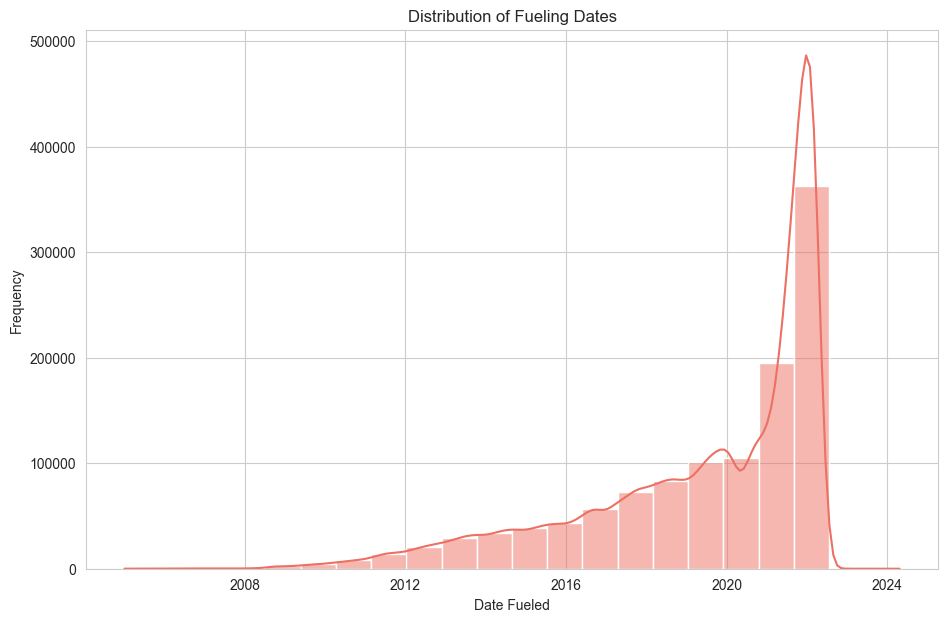

In [7]:
plt.figure(figsize=(11, 7))
sns.set_style('whitegrid')
sns.histplot(updated_df['date_fueled'].dropna(),
                bins='sturges',
                stat='count',
                kde=True,
                color='#ec7063')
plt.title('Distribution of Fueling Dates')
plt.xlabel('Date Fueled')
plt.ylabel('Frequency')
plt.show()


The histogram shows the distribution of valid fueling dates within the specificed range (from 2005 to the current date). 
1. Distribution of Fueling Dates:
    * The data seems to be heavily skewed towards the more recent dates.
    * The KDE line peaks significantly towards the right-hand side of the plot, suggesting that most of the refueling entries occurred within a more condensed recent time period.

2. Historical Refueling Activity:
    * There is a gradual increase in the number of entries over time, with a sharp rise as you approach the more recent dates.
    * This could indicate that the dataset either has more recent entries or that vehicle refueling was recorded more frequently as time progressed.

3. Binning:
    * The histogram bins are wide enough to capture general trends, but there might be clustering towards specific time periods, which the KDE line emphasizes.

[1.2] Numeric Fields: 1. Identify what percentage of gallons, miles, and odometer entries are missing.

In [8]:
# Calculate the percentage of missing values in each of the specified columns
columns = ['gallons', 'miles', 'odometer']
percent_missing = updated_df[columns].isnull().mean() * 100

for column, percentage in percent_missing.items():
    print(f"Percentage of missing entries in '{column}': {percentage:.2f}%")

Percentage of missing entries in 'gallons': 6.32%
Percentage of missing entries in 'miles': 87.60%
Percentage of missing entries in 'odometer': 12.65%


[1.2] Numeric Fields: 2. The miles, gallons and mpg columns are interdependent. If one is missing, the other two can be used to calculate it.

In [9]:
# Convert odometer, gallons and miles to floats
updated_df['gallons'] = updated_df['gallons'].astype(str)
updated_df['gallons'] = updated_df['gallons'].str.replace(',', '').str.strip()
updated_df['gallons'] = pd.to_numeric(updated_df['gallons'], errors='coerce')

updated_df['miles'] = updated_df['miles'].astype(str)
updated_df['miles'] = updated_df['miles'].str.replace(',', '').str.strip()
updated_df['miles'] = pd.to_numeric(updated_df['miles'], errors='coerce')

updated_df['mpg'] = updated_df['mpg'].astype(str)
updated_df['mpg'] = updated_df['mpg'].str.replace(',', '').str.strip()
updated_df['mpg'] = pd.to_numeric(updated_df['mpg'], errors="coerce")

# Display the first few rows to check the conversion
print(updated_df[['gallons', 'miles', 'mpg']].head())


# Apply the function to each row in the DataFrame
updated_df = updated_df.apply(fill_missing_values, axis=1)

# Display the updated DataFrame to check the changes
print(updated_df[['gallons','miles','mpg']])

   gallons  miles   mpg
0      NaN    NaN   NaN
1   12.120    NaN  31.6
2    7.991    NaN  28.5
3   10.575    NaN  46.8
4   11.651  244.4  21.0
         gallons     miles   mpg
0            NaN       NaN   NaN
1         12.120  382.9920  31.6
2          7.991  227.7435  28.5
3         10.575  494.9100  46.8
4         11.651  244.4000  21.0
...          ...       ...   ...
1174865   13.046  335.2822  25.7
1174866   12.637  252.7400  20.0
1174867   10.002  285.0570  28.5
1174868   10.493  382.9945  36.5
1174869   17.350    0.0000   0.0

[1172225 rows x 3 columns]


[1.2] Numeric Fields: 3. The values will be read in as objects (or strings) by Pandas. Convert these values to float (note the point above about commas in the value).

In [10]:
print(updated_df[['odometer', 'cost_per_gallon', 'total_spent']].head())

updated_df['odometer'] = updated_df['odometer'].astype(str)
updated_df['odometer'] = updated_df['odometer'].str.replace(',', '').str.strip()
updated_df['odometer'] = pd.to_numeric(updated_df['odometer'], errors='coerce')


# Apply the function to create new float columns
updated_df['cost_per_gallon_float'] = updated_df['cost_per_gallon'].apply(clean_and_convert)
updated_df['total_spent_float'] = updated_df['total_spent'].apply(clean_and_convert)

updated_df.head()

   odometer cost_per_gallon total_spent
0   73,370              NaN         NaN
1   11,983           $5.599      $67.86
2   98,233            £5.45      £43.53
3  163,802            £5.11      £54.00
4       NaN          $3.029      $35.29


date_fueled date_captured  odometer  gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07   73370.0      NaN             NaN         NaN   
1  2012-11-07    2016-08-30   11983.0   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28   98233.0    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04  163802.0   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15       NaN   11.651          $3.029      $35.29   

    mpg     miles                                           user_url  \
0   NaN       NaN  https://www.somewebsite.com/suzuki/swift/2015/...   
1  31.6  382.9920     https://www.somewebsite.com/bmw/x3/2009/461150   
2  28.5  227.7435  https://www.somewebsite.com/mercedes-benz/e300...   
3  46.8  494.9100   https://www.somewebsite.com/bmw/320d/2010/247233   
4  21.0  244.4000  https://www.somewebsite.com/honda/passport/201...   

   is_valid_date  cost_per_gallon_float  total_spent_float  
0           True                    NaN                NaN  
1           True                  5.599              67.86  
2           True                  5.450              43.53  
3           True                  5.110              54.00  
4           True                  3.029              35.29

[1.2] Numeric Fields: 4. Plot the distributions and comment on the distributions. 


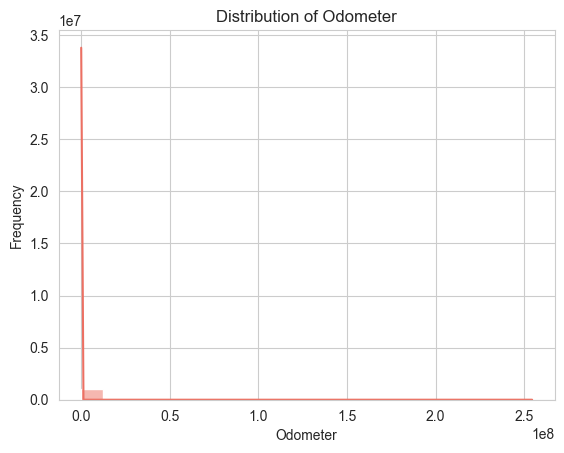

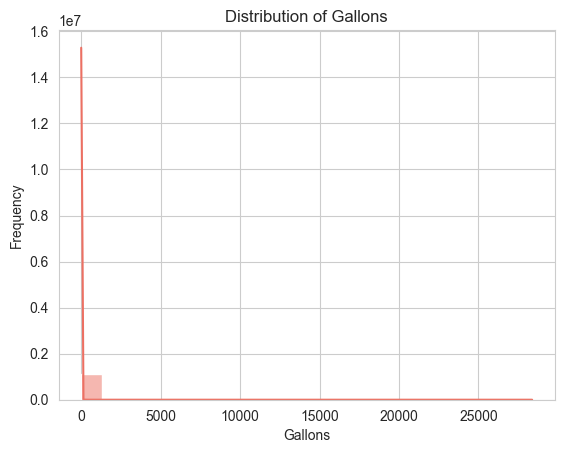

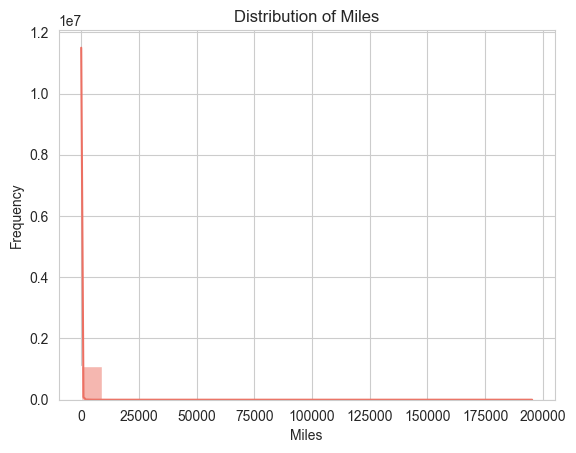

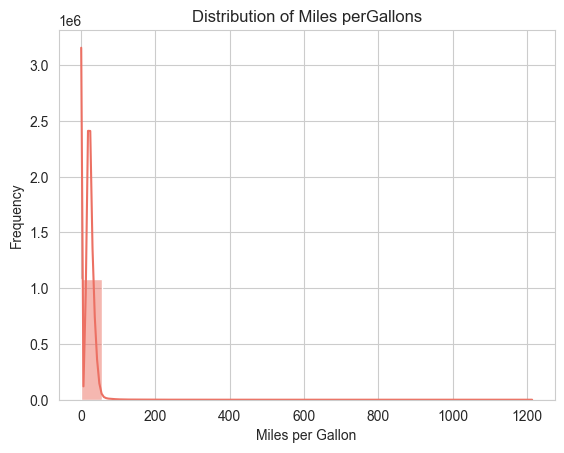

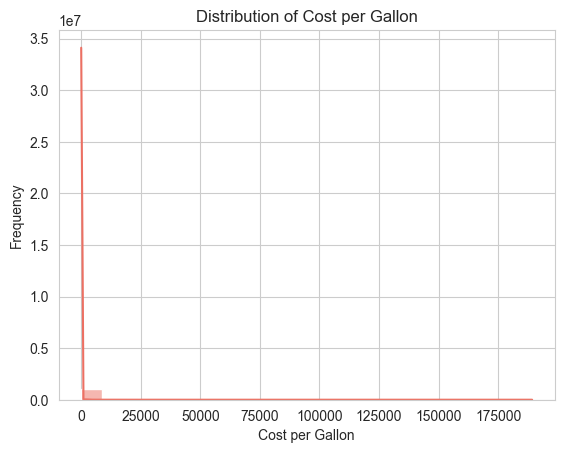

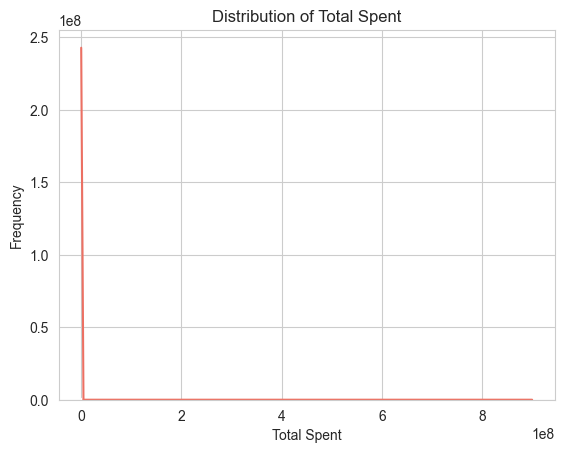

In [11]:
updated_df.head()
sns.set_style('whitegrid')
sns.histplot(updated_df['odometer'].dropna(),
             bins='sturges',
             stat='count',
             kde=True,
             color='#ec7063')
plt.title('Distribution of Odometer')
plt.xlabel('Odometer')
plt.ylabel('Frequency')
plt.show()

sns.set_style('whitegrid')
sns.histplot(updated_df['gallons'].dropna(),
             bins='sturges',
             stat='count',
             kde=True,
             color='#ec7063')
plt.title('Distribution of Gallons')
plt.xlabel('Gallons')
plt.ylabel('Frequency')
plt.show()

sns.set_style('whitegrid')
sns.histplot(updated_df['miles'].dropna(),
             bins='sturges',
             stat='count',
             kde=True,
             color='#ec7063')
plt.title('Distribution of Miles')
plt.xlabel('Miles')
plt.ylabel('Frequency')
plt.show()

sns.set_style('whitegrid')
sns.histplot(updated_df['mpg'].dropna(),
             bins='sturges',
             stat='count',
             kde=True,
             color='#ec7063')
plt.title('Distribution of Miles perGallons')
plt.xlabel('Miles per Gallon')
plt.ylabel('Frequency')
plt.show()

sns.set_style('whitegrid')
sns.histplot(updated_df['cost_per_gallon_float'].dropna(),
             bins='sturges',
             stat='count',
             kde=True,
             color='#ec7063')
plt.title('Distribution of Cost per Gallon')
plt.xlabel('Cost per Gallon')
plt.ylabel('Frequency')
plt.show()

sns.set_style('whitegrid')
sns.histplot(updated_df['total_spent_float'].dropna(),
             bins='sturges',
             stat='count',
             kde=True,
             color='#ec7063')
plt.title('Distribution of Total Spent')
plt.xlabel('Total Spent')
plt.ylabel('Frequency')
plt.show()

We are unable to make meaningful observations about this graph due to the lack of a clear distribution. This suggests the presence of significant outliers that obscure our data, making it difficult to draw conclusions. Given the diverse range of currencies involved, it was anticipated that interpreting Total Spent and Cost per Gallon would be challenging. So we are going to use a boxplot to help us see the outliers and where they should be removed.


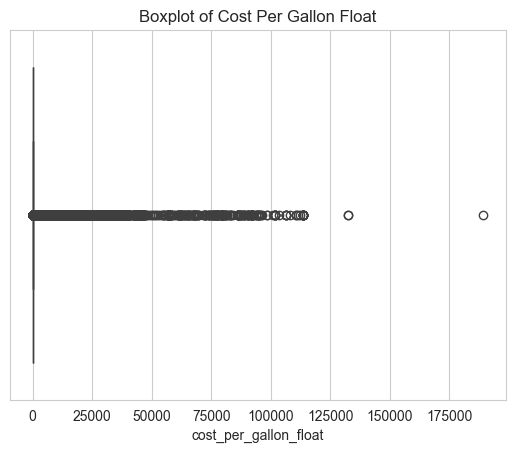

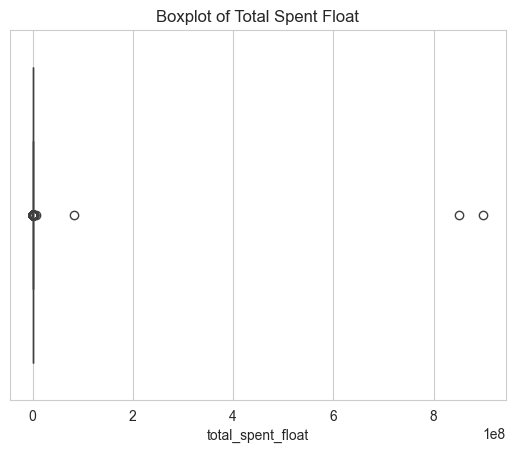

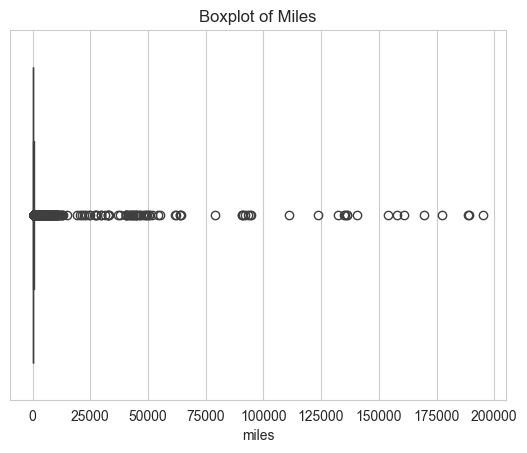

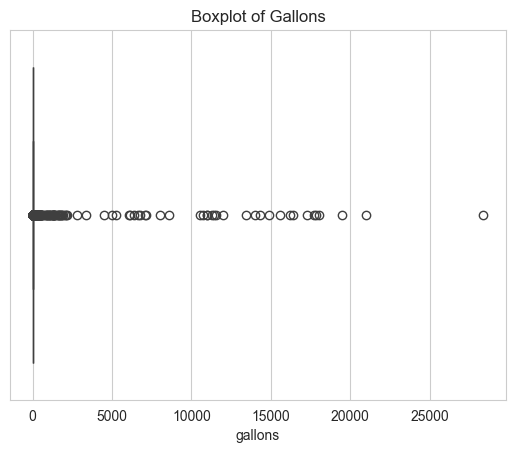

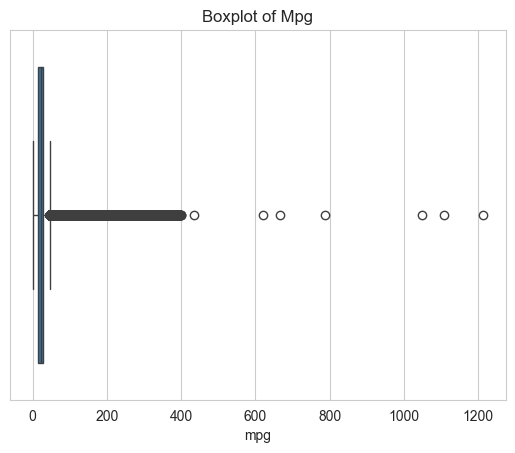

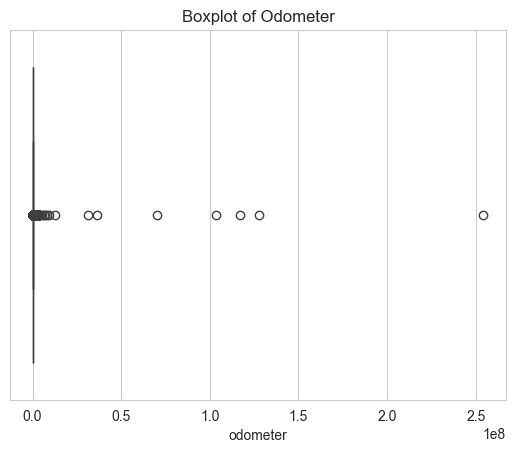

In [12]:
# List of columns to plot
columns = ['cost_per_gallon_float', 'total_spent_float', 'miles', 'gallons', 'mpg', 'odometer']

# Loop through each column and generate a boxplot
for column in columns:
    sns.boxplot(x=updated_df[column])
    plt.title(f'Boxplot of {column.replace("_", " ").title()}')
    plt.show()

After examining the boxplots, it is evident that there are significant outliers present in the data. These outliers skew the distributions, making it challenging to draw accurate and informed conclusions. Therefore, we filter out these extreme values using percentiles before conducting further analysis.

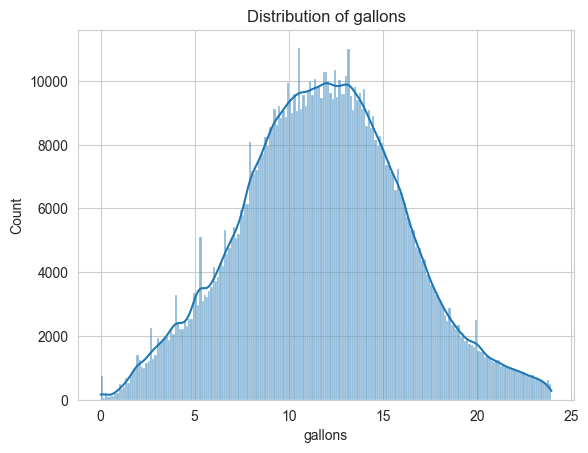

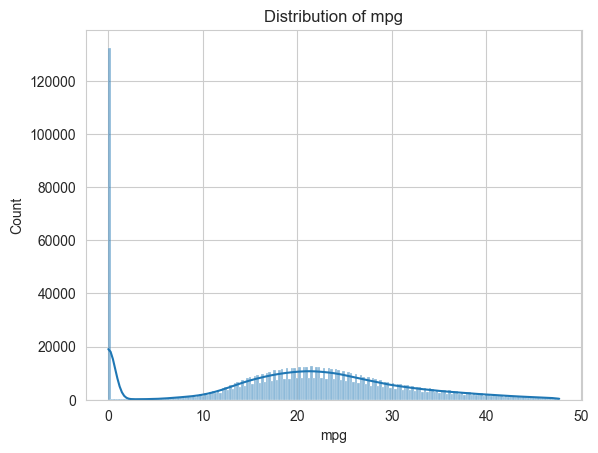

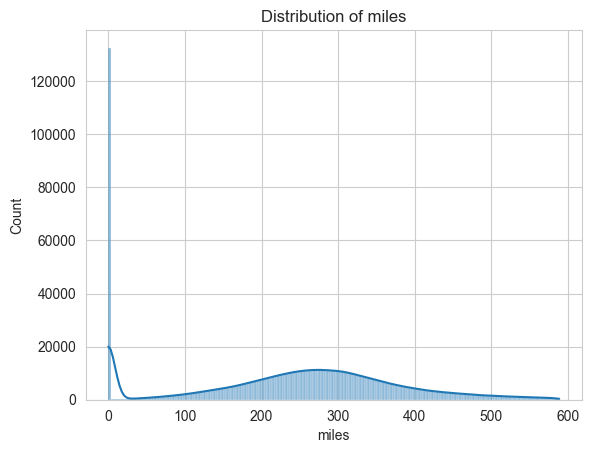

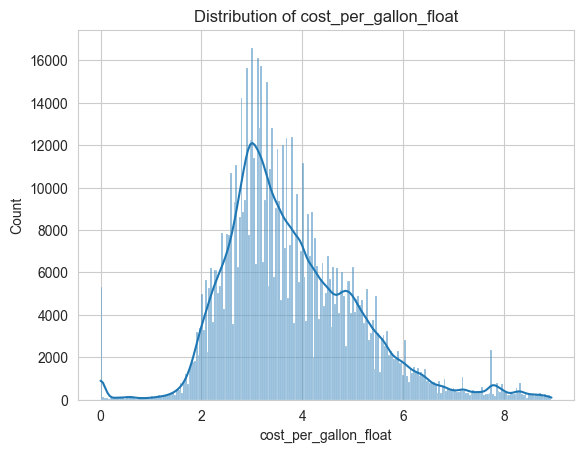

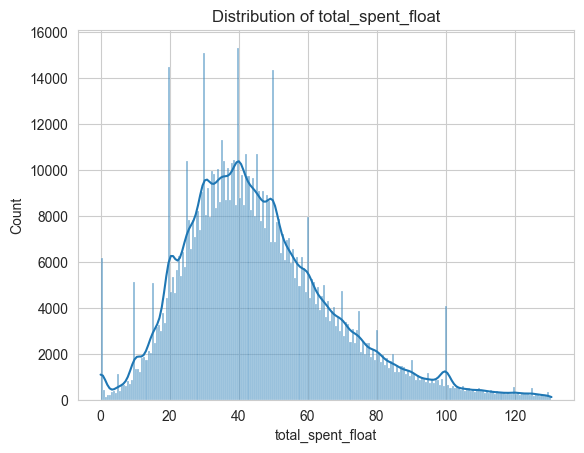

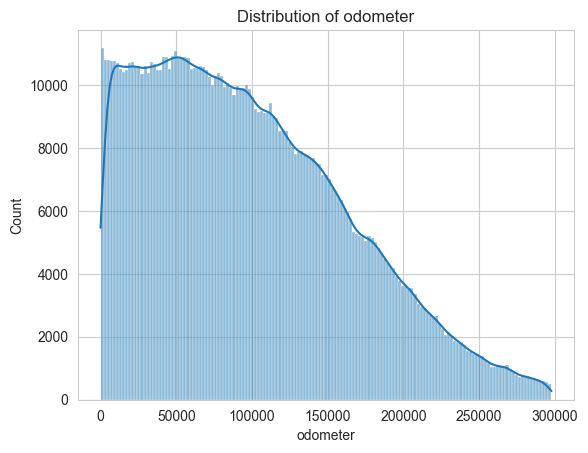

In [13]:
numerical_na_removal_df = updated_df.dropna(subset=['gallons', 'mpg', 'miles', 'cost_per_gallon_float', 'total_spent_float', 'odometer'])


# Apply to each column
df_cleaned_gallons = remove_outliers_iqr(numerical_na_removal_df, 'gallons')
df_cleaned_mpg = remove_outliers_iqr(numerical_na_removal_df, 'mpg')
df_cleaned_miles = remove_outliers_iqr(numerical_na_removal_df, 'miles')
df_cleaned_cost_per_gallon = remove_outliers_iqr(numerical_na_removal_df, 'cost_per_gallon_float')
df_cleaned_total_spent = remove_outliers_iqr(numerical_na_removal_df, 'total_spent_float')
df_cleaned_odometer = remove_outliers_iqr(numerical_na_removal_df, 'odometer')

def plot_distribution(column, df_clean):
    sns.histplot(df_clean[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

# Plot cleaned data distributions
plot_distribution('gallons', df_cleaned_gallons)
plot_distribution('mpg', df_cleaned_mpg)
plot_distribution('miles', df_cleaned_miles)
plot_distribution('cost_per_gallon_float', df_cleaned_cost_per_gallon)
plot_distribution('total_spent_float', df_cleaned_total_spent)
plot_distribution('odometer', df_cleaned_odometer)

[1.2] Numeric Fields: 5. Compute the statistical description of the columns: mean, standard deviation, max, min, most frequent, and quartiles. Do these results make sense?

In [14]:
pd.set_option('display.float_format', '{:.3f}'.format)
print(updated_df.describe())

                         date_fueled                  date_captured  \
count                        1172225                        1172225   
mean   2019-06-06 12:11:33.905008896  2019-09-05 00:33:22.591652352   
min              2005-01-02 00:00:00            2008-08-07 00:00:00   
25%              2017-10-18 00:00:00            2018-03-05 00:00:00   
50%              2020-08-04 00:00:00            2020-09-10 00:00:00   
75%              2021-10-26 00:00:00            2021-11-01 00:00:00   
max              2024-04-20 00:00:00            2022-04-16 00:00:00   
std                              NaN                            NaN   

           odometer     gallons         mpg       miles  \
count   1023994.000 1098092.000 1098092.000 1098092.000   
mean     104002.796      12.798      22.159     269.429   
min           0.000       0.000       0.000       0.000   
25%       45927.000       8.988      15.500     181.335   
50%       91883.500      11.953      21.800     267.016   
75%   

The summary statistics of the dataset reveal several significant data quality issues, making it challenging to draw accurate conclusions. Most notably, the presence of extremely high standard deviations and unrealistic maximum values across multiple columns suggests the presence of severe outliers and possible data entry errors. For instance, the odometer reading has a maximum value of 254 million miles, which is highly implausible, while the gallons, MPG, miles, cost per gallon, and total spent columns also exhibit similarly exaggerated maximum values. Additionally, minimum values of zero in several columns may indicate missing or misentered data. The monetary columns (such as cost per gallon and total spent) are particularly difficult to analyze due to the presence of over 100 different currencies in the dataset, which likely contributes to the extreme variability observed.


### Question 2: Feature Engineering

[2.1] 1. Create a new column with the currency.

In [15]:
# Define a regular expression pattern to match all characters until the first digit
currency_pattern = r'^([^\d]+)'

# Extract the currency symbols/abbreviations from the cost_per_gallon column
updated_df['currency'] = updated_df['cost_per_gallon'].str.extract(currency_pattern, expand=False).str.strip()

print(updated_df['currency'].value_counts())
updated_df.head()

currency
$      738396
£       86147
€       58441
CA$     46234
R       36034
        ...  
CV$        11
KGS         9
L$          9
IQD         8
YR          4
Name: count, Length: 121, dtype: int64


date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07  73370.000      NaN             NaN         NaN   
1  2012-11-07    2016-08-30  11983.000   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28  98233.000    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04 163802.000   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15        NaN   11.651          $3.029      $35.29   

     mpg   miles                                           user_url  \
0    NaN     NaN  https://www.somewebsite.com/suzuki/swift/2015/...   
1 31.600 382.992     https://www.somewebsite.com/bmw/x3/2009/461150   
2 28.500 227.743  https://www.somewebsite.com/mercedes-benz/e300...   
3 46.800 494.910   https://www.somewebsite.com/bmw/320d/2010/247233   
4 21.000 244.400  https://www.somewebsite.com/honda/passport/201...   

   is_valid_date  cost_per_gallon_float  total_spent_float currency  
0           True                    NaN                NaN      NaN  
1           True                  5.599             67.860        $  
2           True                  5.450             43.530        £  
3           True                  5.110             54.000        £  
4           True                  3.029             35.290        $

[2.1] 2. Create a new column containing the float value of the total spend and the cost per gallon.

In [16]:
# Calculate the total spend by multiplying the cost per gallon by the number of gallons
updated_df['total_spend'] = updated_df['cost_per_gallon_float'] * updated_df['gallons']

updated_df.head()

date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07  73370.000      NaN             NaN         NaN   
1  2012-11-07    2016-08-30  11983.000   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28  98233.000    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04 163802.000   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15        NaN   11.651          $3.029      $35.29   

     mpg   miles                                           user_url  \
0    NaN     NaN  https://www.somewebsite.com/suzuki/swift/2015/...   
1 31.600 382.992     https://www.somewebsite.com/bmw/x3/2009/461150   
2 28.500 227.743  https://www.somewebsite.com/mercedes-benz/e300...   
3 46.800 494.910   https://www.somewebsite.com/bmw/320d/2010/247233   
4 21.000 244.400  https://www.somewebsite.com/honda/passport/201...   

   is_valid_date  cost_per_gallon_float  total_spent_float currency  \
0           True                    NaN                NaN      NaN   
1           True                  5.599             67.860        $   
2           True                  5.450             43.530        £   
3           True                  5.110             54.000        £   
4           True                  3.029             35.290        $   

   total_spend  
0          NaN  
1       67.860  
2       43.551  
3       54.038  
4       35.291

[2.1] 3. Car make, model, year, User ID: use the url (the last value in the URL is
the user ID).

In [17]:
# Apply the function to extract details and add new columns to the DataFrame
updated_df[['make', 'model', 'year', 'user_id']] = updated_df['user_url'].apply(extract_car_details)
updated_df.head()

date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07  73370.000      NaN             NaN         NaN   
1  2012-11-07    2016-08-30  11983.000   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28  98233.000    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04 163802.000   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15        NaN   11.651          $3.029      $35.29   

     mpg   miles                                           user_url  \
0    NaN     NaN  https://www.somewebsite.com/suzuki/swift/2015/...   
1 31.600 382.992     https://www.somewebsite.com/bmw/x3/2009/461150   
2 28.500 227.743  https://www.somewebsite.com/mercedes-benz/e300...   
3 46.800 494.910   https://www.somewebsite.com/bmw/320d/2010/247233   
4 21.000 244.400  https://www.somewebsite.com/honda/passport/201...   

   is_valid_date  cost_per_gallon_float  total_spent_float currency  \
0           True                    NaN                NaN      NaN   
1           True                  5.599             67.860        $   
2           True                  5.450             43.530        £   
3           True                  5.110             54.000        £   
4           True                  3.029             35.290        $   

   total_spend           make     model  year  user_id  
0          NaN         suzuki     swift  2015   674857  
1       67.860            bmw        x3  2009   461150  
2       43.551  mercedes-benz      e300  1998   133501  
3       54.038            bmw      320d  2010   247233  
4       35.291          honda  passport  2019  1038865

[2.2] 1. litres filled: use the gallons - consider whether to use UK or US gallons.

In [18]:


# Apply the function to determine currency type
updated_df['currency_type'] = updated_df['currency'].apply(determine_currency_type)

# Count the occurrences of each currency type
currency_counts = updated_df['currency_type'].value_counts()

# Determine the predominant currency
predominant_currency = 'US' if currency_counts.get('US', 0) > currency_counts.get('UK', 0) else 'UK'

# Conversion factor based on the predominant currency
if predominant_currency == 'US':
    conversion_factor = 3.78541  # US gallon to liters
    print(f'Using US gallon to litre conversion factor: {conversion_factor}')
else:
    conversion_factor = 4.54609  # UK gallon to liters
    print(f'Using UK gallon to litre conversion factor: {conversion_factor}')

# Function to convert gallons to liters
def convert_gallons_to_litres(gallons):
    if pd.isna(gallons):
        return None
    return gallons * conversion_factor

# Apply the conversion to create a new 'liters_filled' column
updated_df['litres_filled'] = updated_df['gallons'].apply(convert_gallons_to_litres)

updated_df.head()


Using US gallon to litre conversion factor: 3.78541


date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07  73370.000      NaN             NaN         NaN   
1  2012-11-07    2016-08-30  11983.000   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28  98233.000    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04 163802.000   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15        NaN   11.651          $3.029      $35.29   

     mpg   miles                                           user_url  \
0    NaN     NaN  https://www.somewebsite.com/suzuki/swift/2015/...   
1 31.600 382.992     https://www.somewebsite.com/bmw/x3/2009/461150   
2 28.500 227.743  https://www.somewebsite.com/mercedes-benz/e300...   
3 46.800 494.910   https://www.somewebsite.com/bmw/320d/2010/247233   
4 21.000 244.400  https://www.somewebsite.com/honda/passport/201...   

   is_valid_date  cost_per_gallon_float  total_spent_float currency  \
0           True                    NaN                NaN      NaN   
1           True                  5.599             67.860        $   
2           True                  5.450             43.530        £   
3           True                  5.110             54.000        £   
4           True                  3.029             35.290        $   

   total_spend           make     model  year  user_id currency_type  \
0          NaN         suzuki     swift  2015   674857         Other   
1       67.860            bmw        x3  2009   461150            US   
2       43.551  mercedes-benz      e300  1998   133501            UK   
3       54.038            bmw      320d  2010   247233            UK   
4       35.291          honda  passport  2019  1038865            US   

   litres_filled  
0            NaN  
1         45.879  
2         30.249  
3         40.031  
4         44.104

[2.2] 2. km driven: use the miles driven to compute this.

In [19]:

# Apply the function to create a new 'km_driven' column
updated_df['km_driven'] = updated_df['miles'].apply(miles_to_km)

updated_df.head()

date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07  73370.000      NaN             NaN         NaN   
1  2012-11-07    2016-08-30  11983.000   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28  98233.000    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04 163802.000   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15        NaN   11.651          $3.029      $35.29   

     mpg   miles                                           user_url  \
0    NaN     NaN  https://www.somewebsite.com/suzuki/swift/2015/...   
1 31.600 382.992     https://www.somewebsite.com/bmw/x3/2009/461150   
2 28.500 227.743  https://www.somewebsite.com/mercedes-benz/e300...   
3 46.800 494.910   https://www.somewebsite.com/bmw/320d/2010/247233   
4 21.000 244.400  https://www.somewebsite.com/honda/passport/201...   

   is_valid_date  ...  total_spent_float  currency total_spend           make  \
0           True  ...                NaN       NaN         NaN         suzuki   
1           True  ...             67.860         $      67.860            bmw   
2           True  ...             43.530         £      43.551  mercedes-benz   
3           True  ...             54.000         £      54.038            bmw   
4           True  ...             35.290         $      35.291          honda   

      model  year  user_id currency_type litres_filled  km_driven  
0     swift  2015   674857         Other           NaN        NaN  
1        x3  2009   461150            US        45.879    616.364  
2      e300  1998   133501            UK        30.249    366.517  
3      320d  2010   247233            UK        40.031    796.478  
4  passport  2019  1038865            US        44.104    393.323  

[5 rows x 21 columns]

[2.2] 3. litres per 100km: use the two new features to calculate this.

In [20]:

# Apply the function to create a new 'liters_per_100km' column
updated_df['litres_per_100km'] = updated_df.apply(lambda row: calculate_liters_per_100km(row['litres_filled'], row['km_driven']), axis=1)

updated_df.head()

date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07  73370.000      NaN             NaN         NaN   
1  2012-11-07    2016-08-30  11983.000   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28  98233.000    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04 163802.000   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15        NaN   11.651          $3.029      $35.29   

     mpg   miles                                           user_url  \
0    NaN     NaN  https://www.somewebsite.com/suzuki/swift/2015/...   
1 31.600 382.992     https://www.somewebsite.com/bmw/x3/2009/461150   
2 28.500 227.743  https://www.somewebsite.com/mercedes-benz/e300...   
3 46.800 494.910   https://www.somewebsite.com/bmw/320d/2010/247233   
4 21.000 244.400  https://www.somewebsite.com/honda/passport/201...   

   is_valid_date  ...  currency  total_spend           make     model  year  \
0           True  ...       NaN          NaN         suzuki     swift  2015   
1           True  ...         $       67.860            bmw        x3  2009   
2           True  ...         £       43.551  mercedes-benz      e300  1998   
3           True  ...         £       54.038            bmw      320d  2010   
4           True  ...         $       35.291          honda  passport  2019   

   user_id currency_type litres_filled km_driven  litres_per_100km  
0   674857         Other           NaN       NaN               NaN  
1   461150            US        45.879   616.364             7.444  
2   133501            UK        30.249   366.517             8.253  
3   247233            UK        40.031   796.478             5.026  
4  1038865            US        44.104   393.323            11.213  

[5 rows x 22 columns]

### Question 3: Vehicle Exploration


[3.1] Plot the number of unique users per country (remember, we proxy this by
currency).

<Axes: xlabel='count', ylabel='currency'>

C:\Users\zachs\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from current font.
  func(*args, **kwargs)
C:\Users\zachs\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


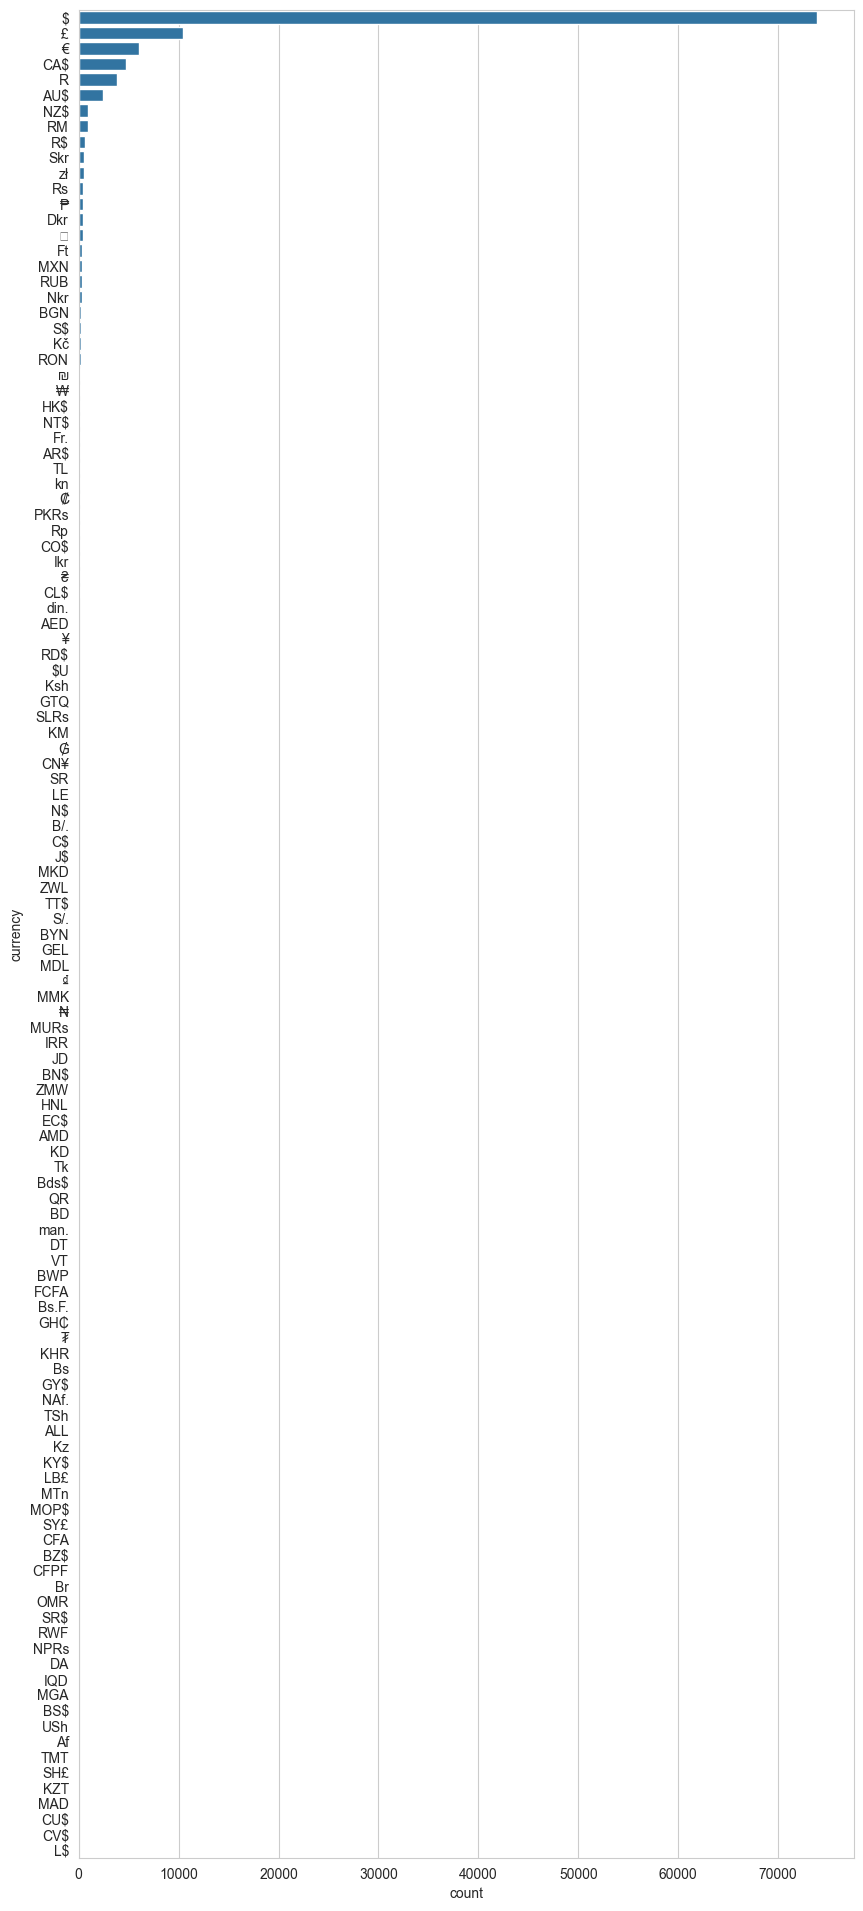

In [21]:
unique_users_df = updated_df.drop_duplicates(subset ='user_url')
#unique_users_df['currency'].value_counts()
plt.figure(figsize=(10, 24))
sns.barplot(unique_users_df['currency'].value_counts(),orient = 'y',log_scale=False)

[3.2] Look at the popularity of the app: plot the number of unique users per
day.

<Axes: xlabel='caputured_day_of_month', ylabel='count'>

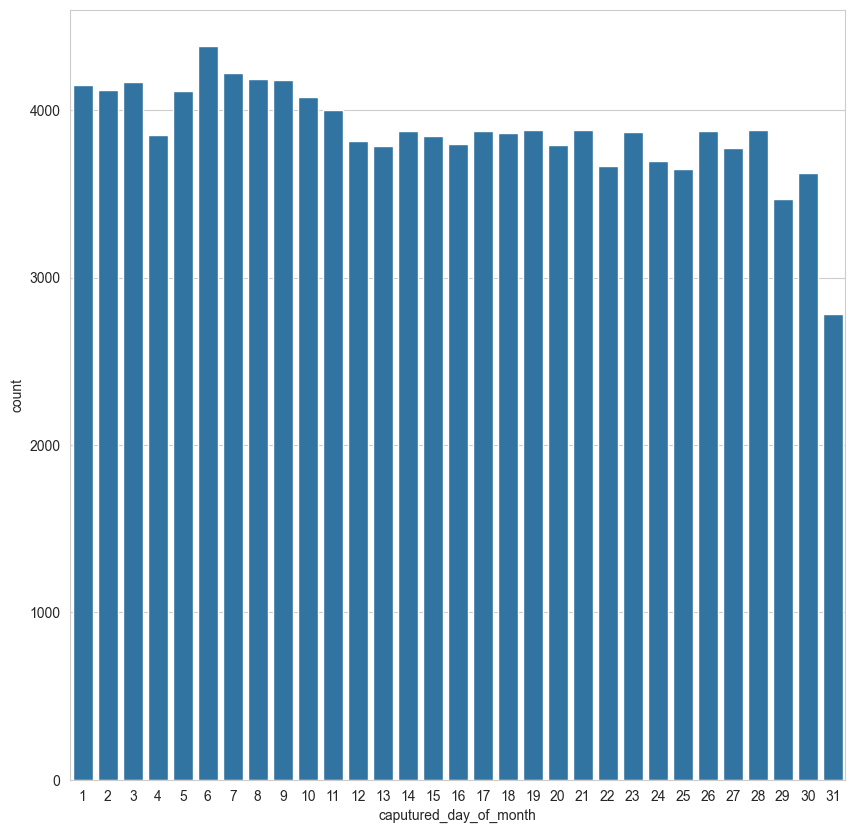

In [22]:

# Extract the day of the month
series_captured_day_of_month = unique_users_df['date_captured'].dt.day
df_capture_day_of_month = unique_users_df.copy()
df_capture_day_of_month['caputured_day_of_month'] = series_captured_day_of_month
#display(df_day_of_month)
plt.figure(figsize=(10, 10))
sns.barplot(df_capture_day_of_month['caputured_day_of_month'].value_counts(),orient = 'x',log_scale = False)

[3.3] Look at the distribution of age of the vehicles per country - look at the
year of the vehicle. Remember to look at the date it was refuelled, not
the current date.

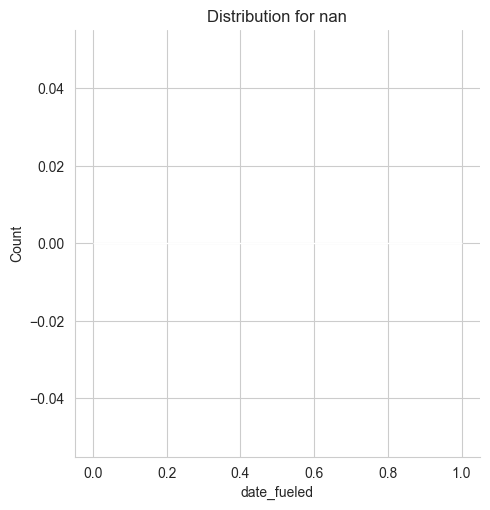

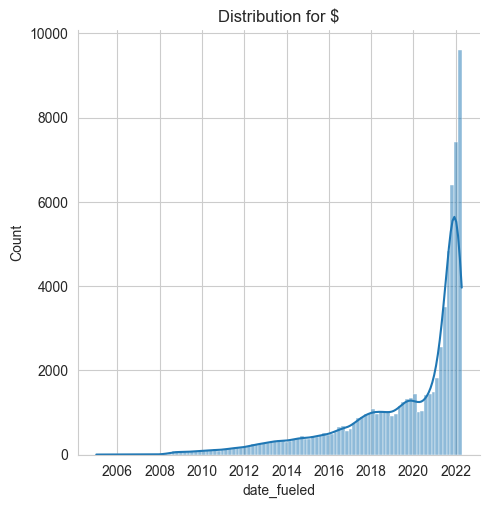

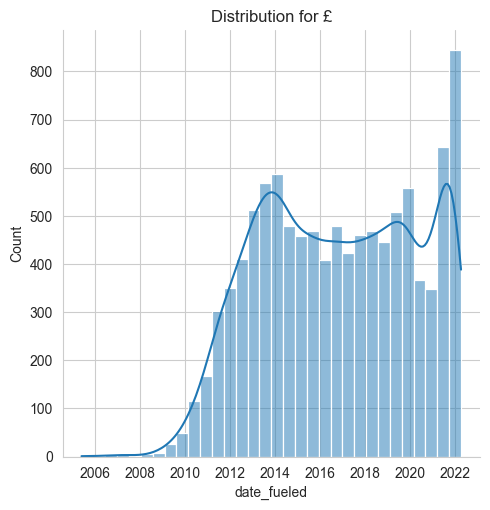

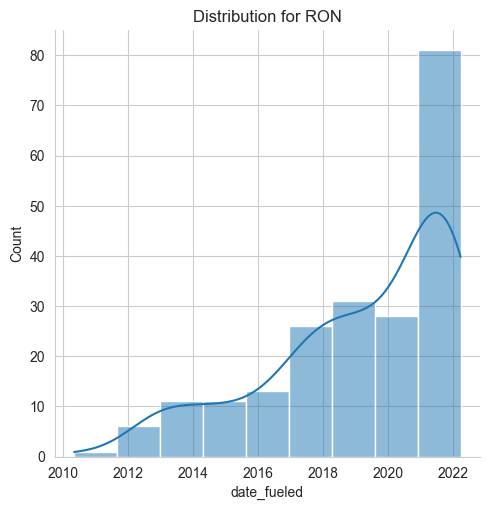

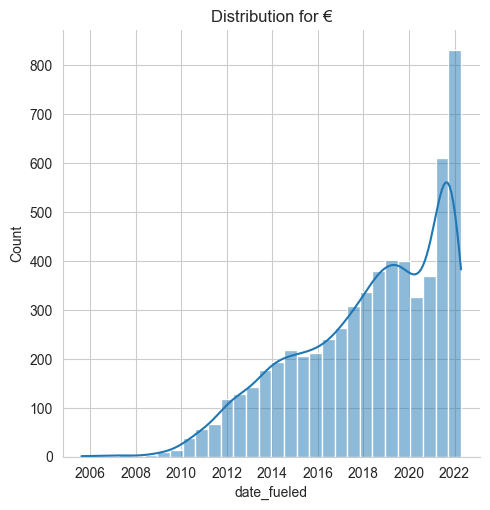

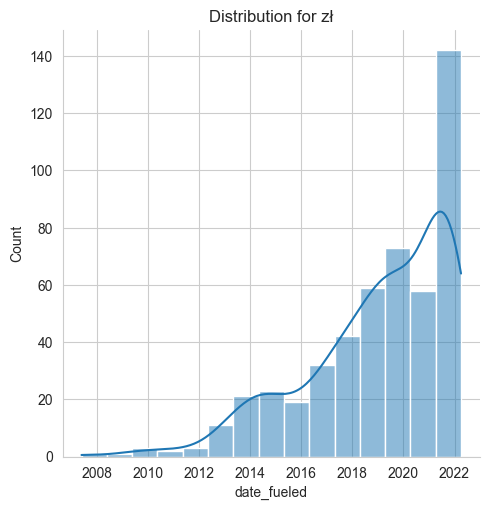

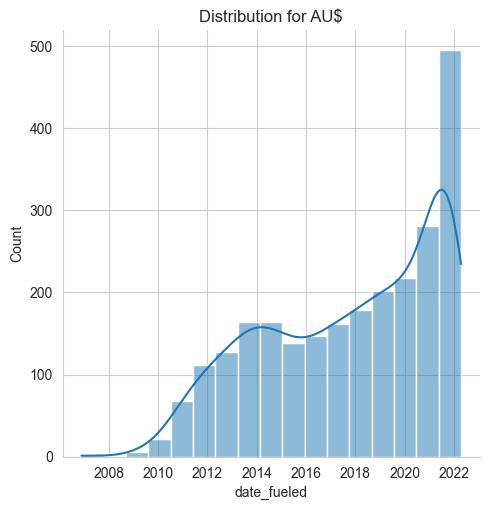

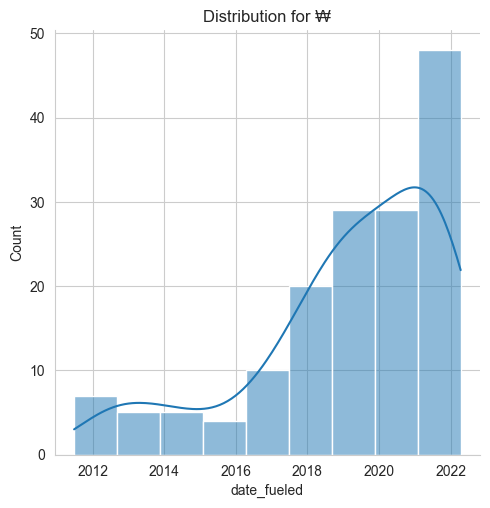

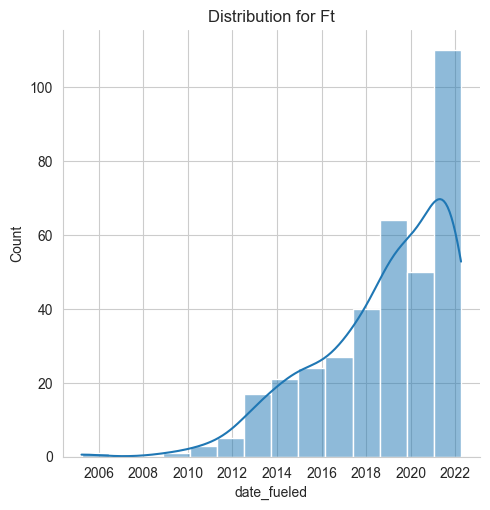

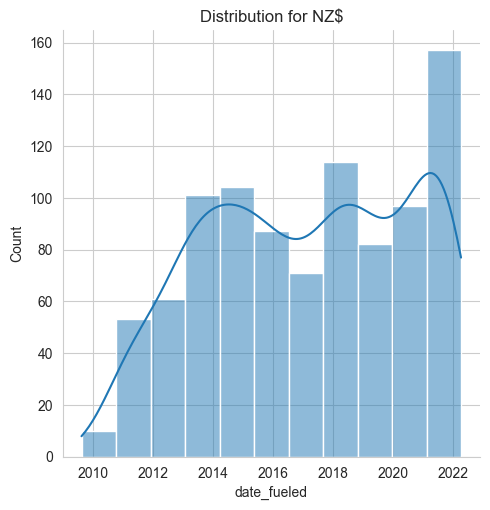

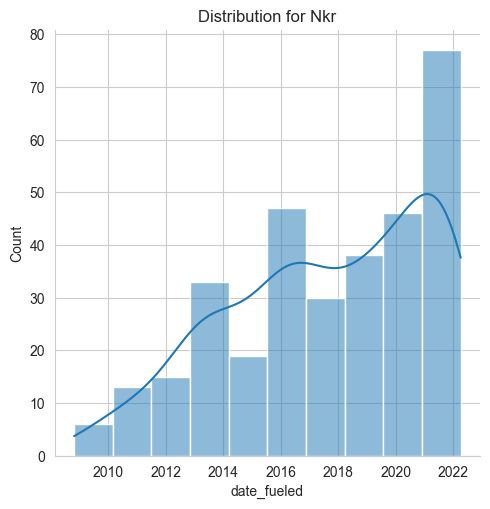

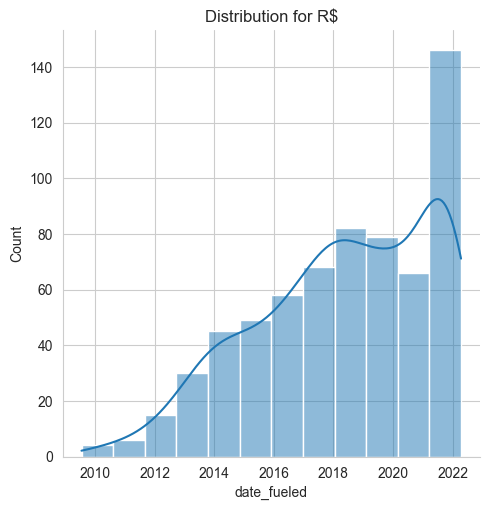

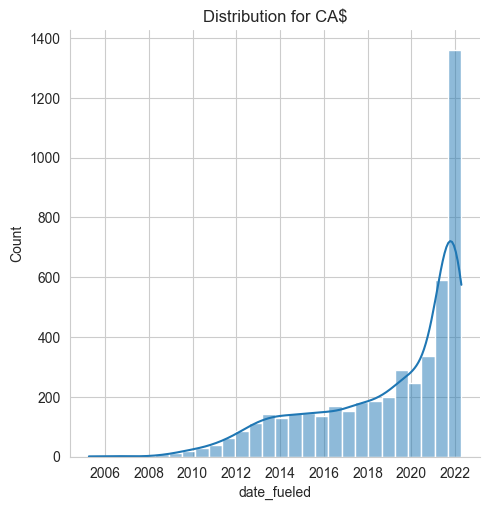

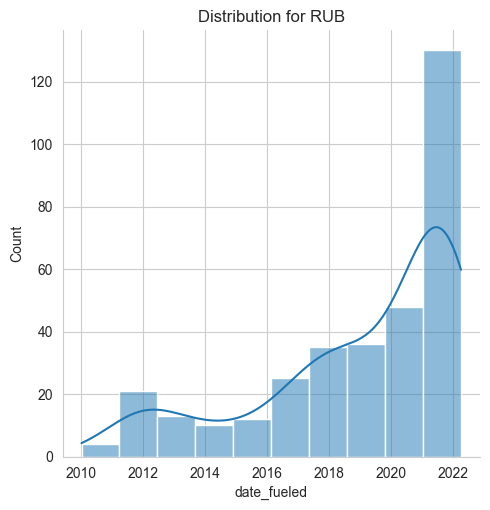

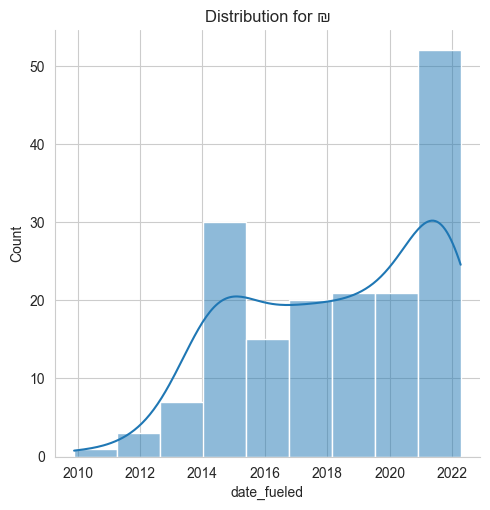

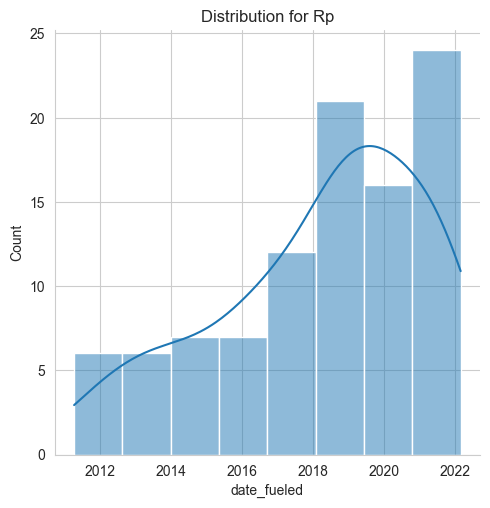

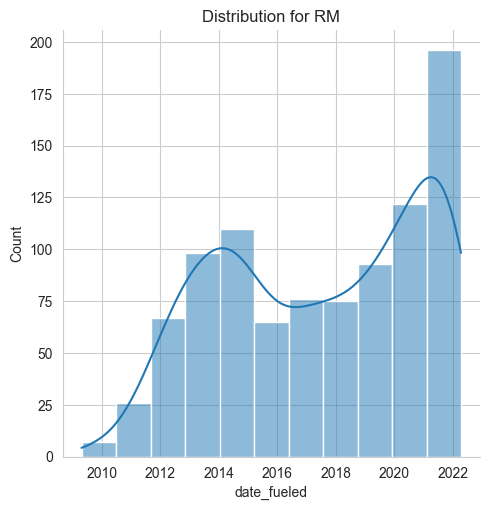

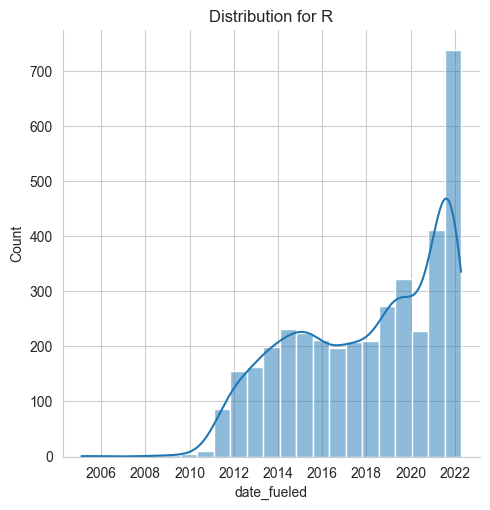

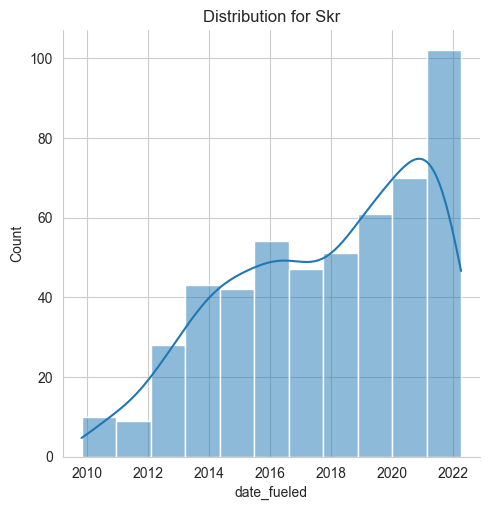

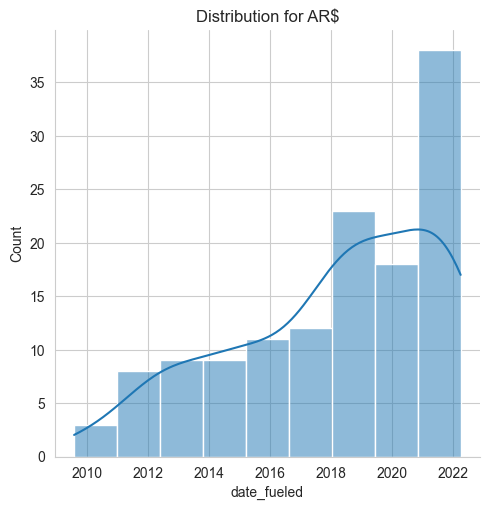

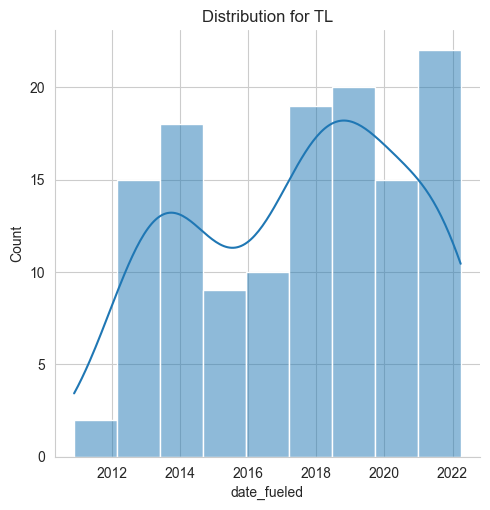

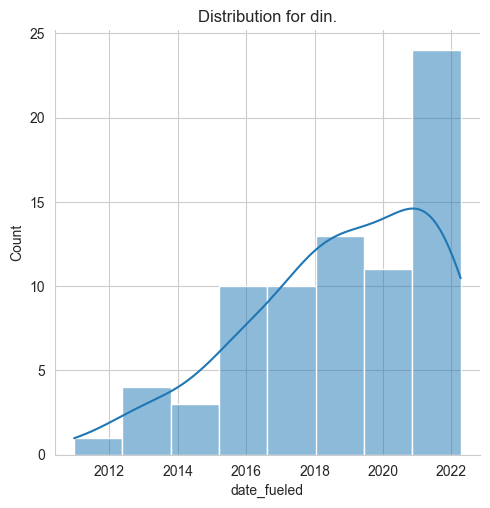

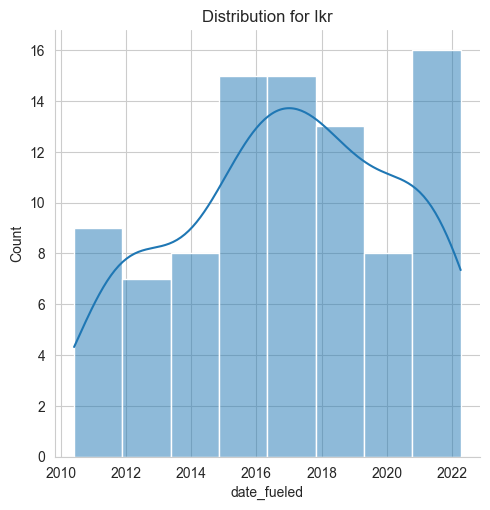

C:\Users\zachs\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3647 (\N{THAI CURRENCY SYMBOL BAHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


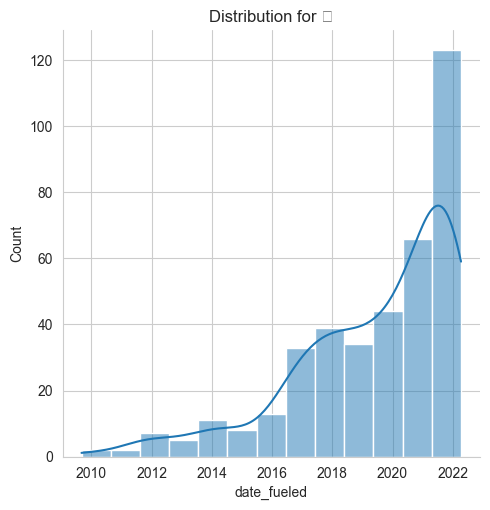

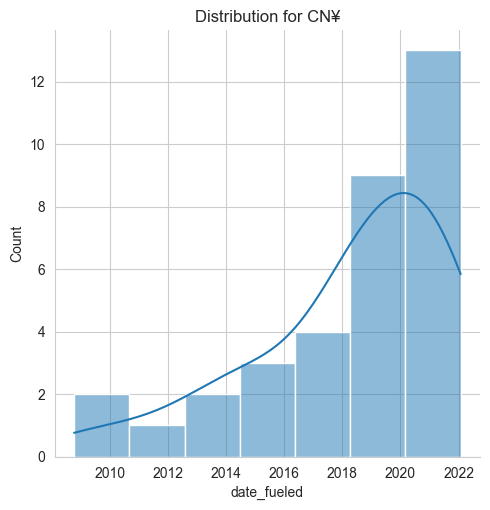

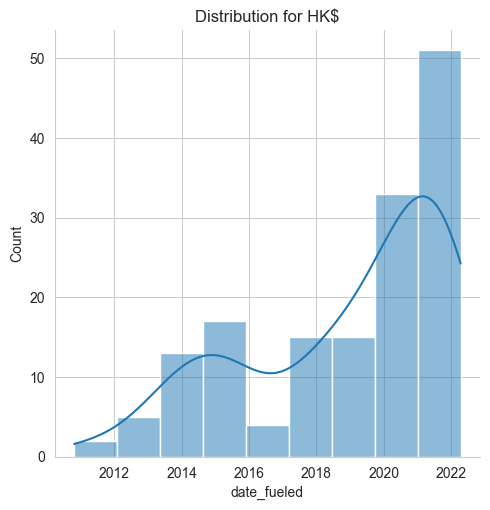

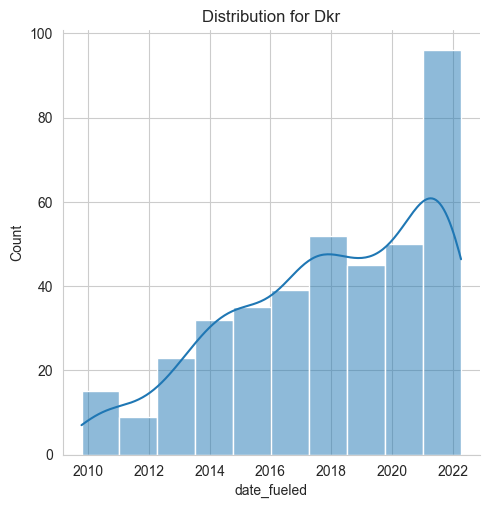

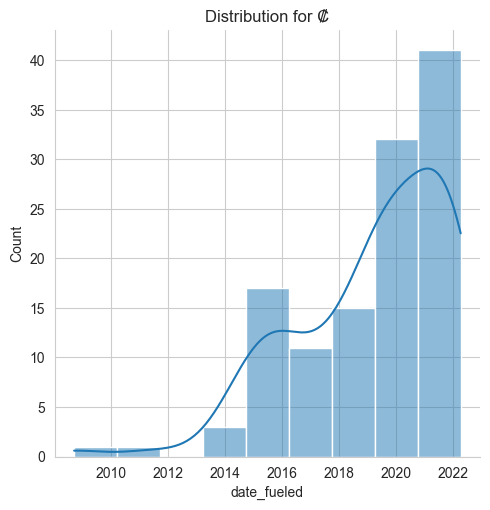

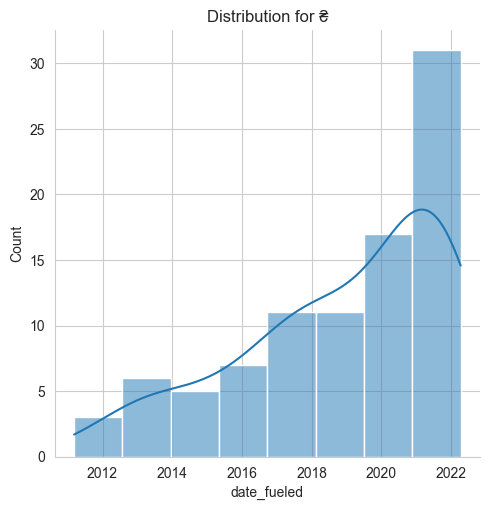

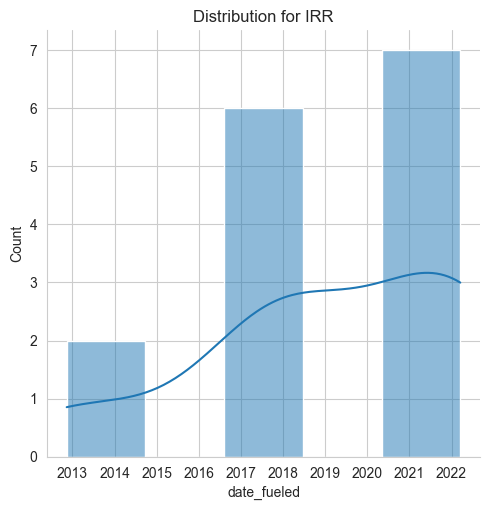

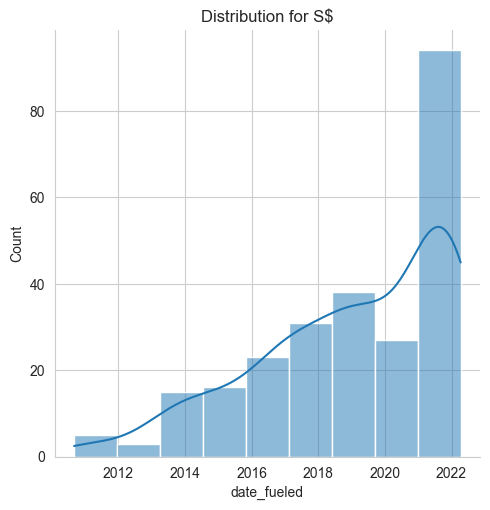

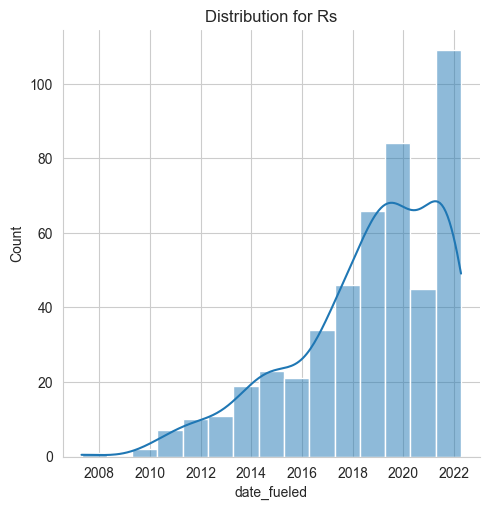

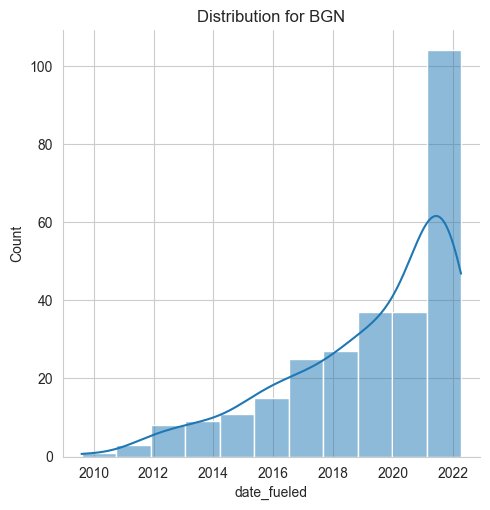

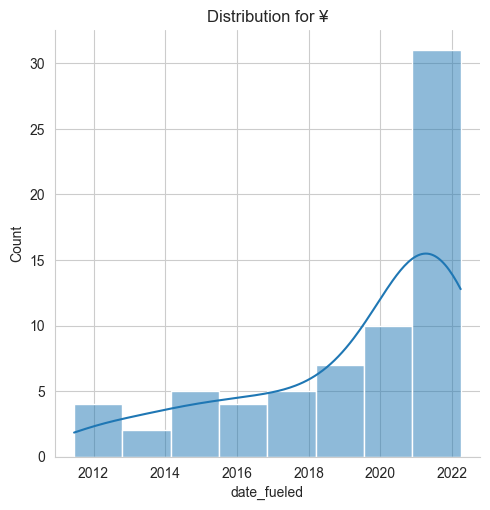

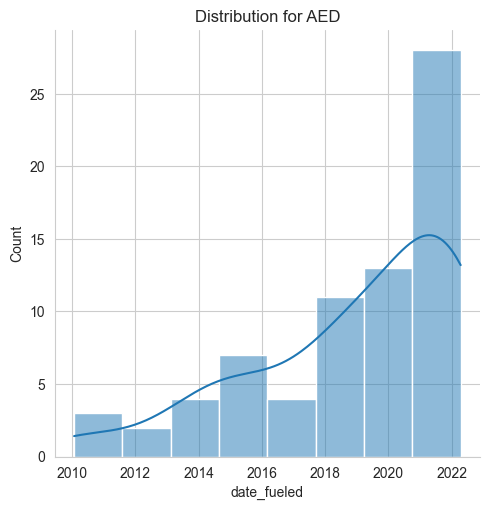

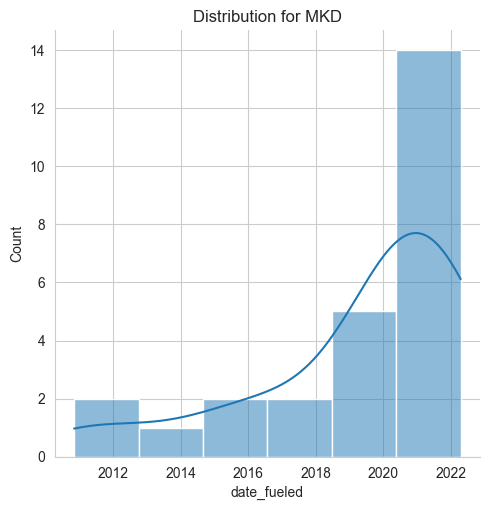

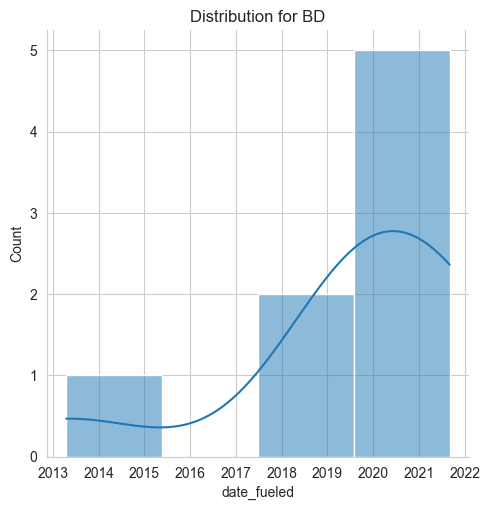

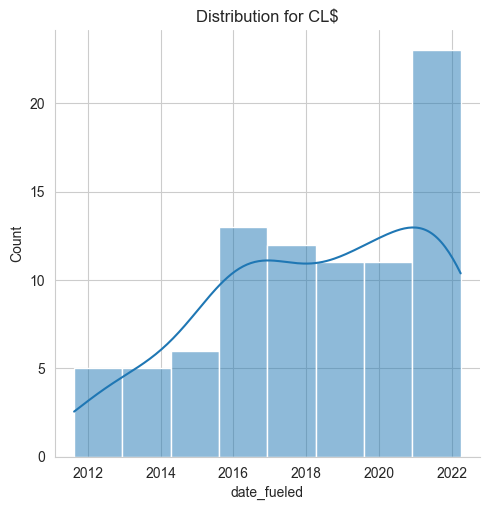

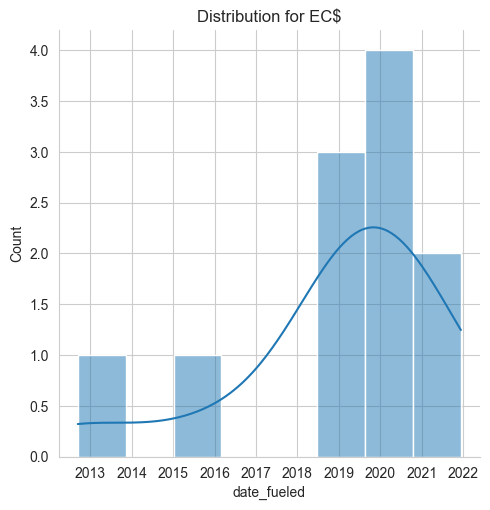

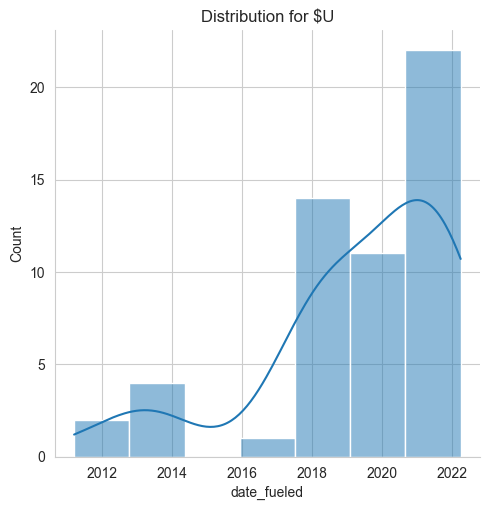

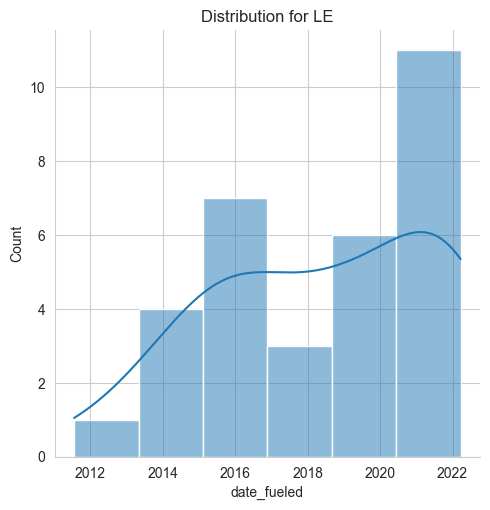

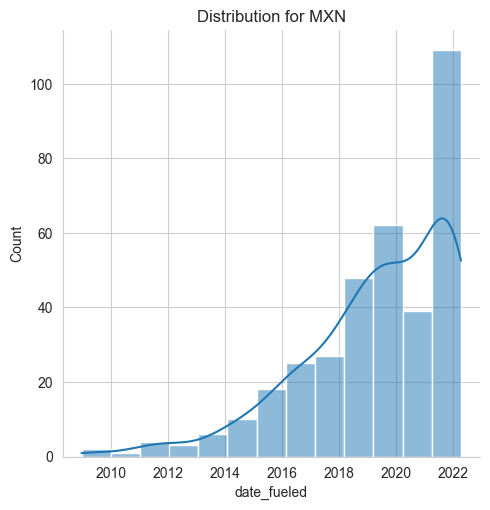

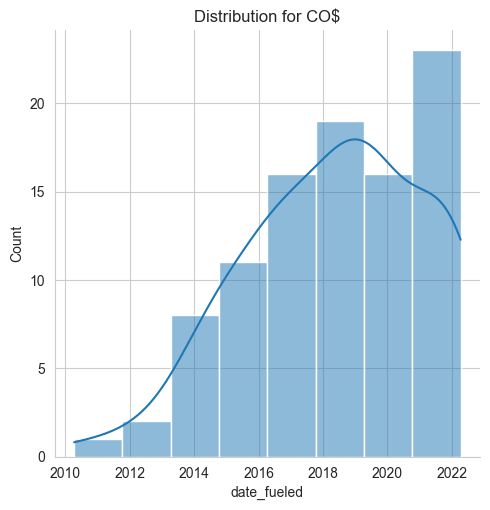

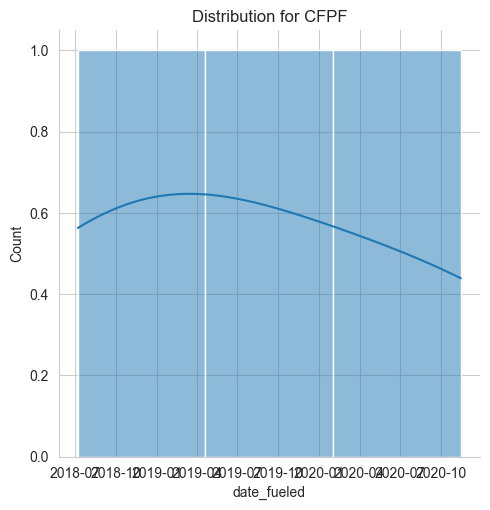

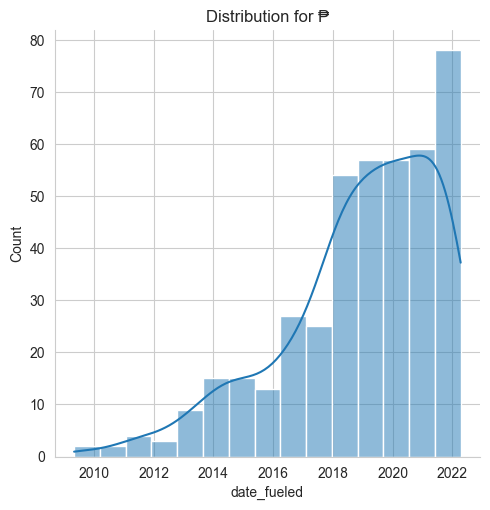

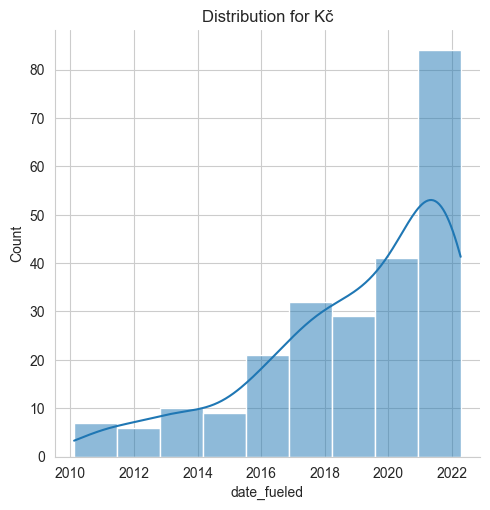

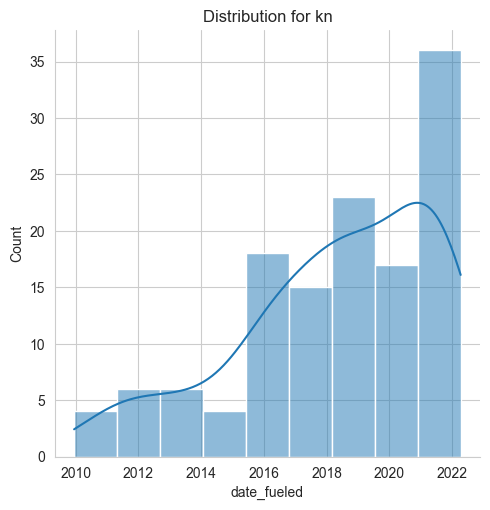

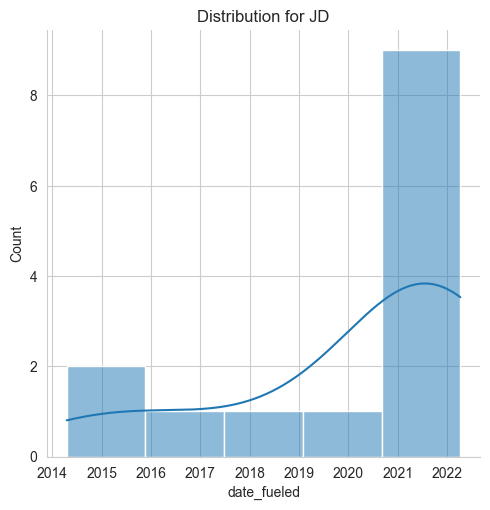

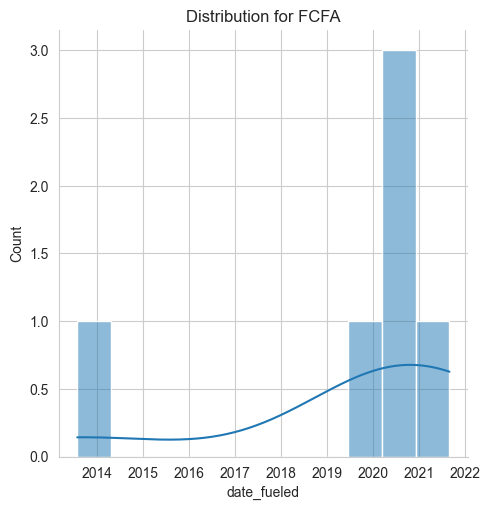

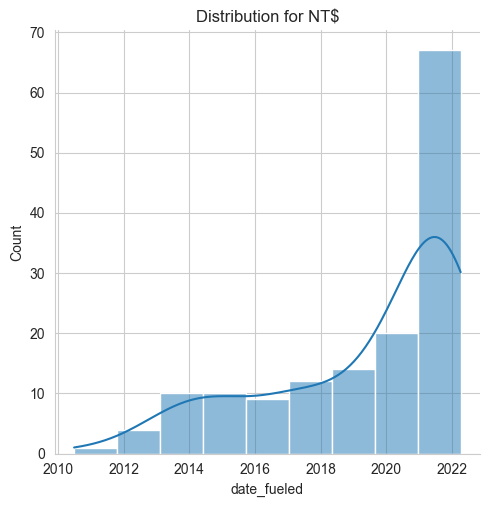

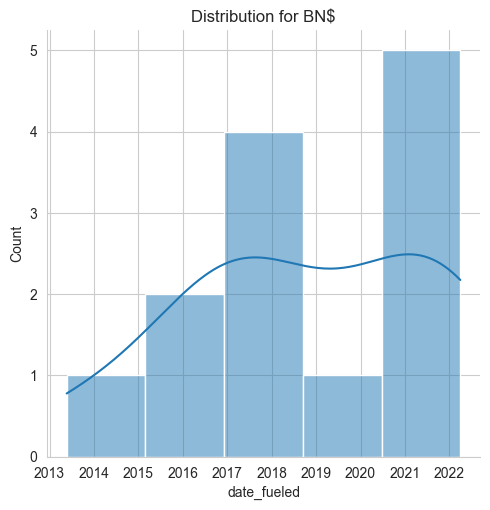

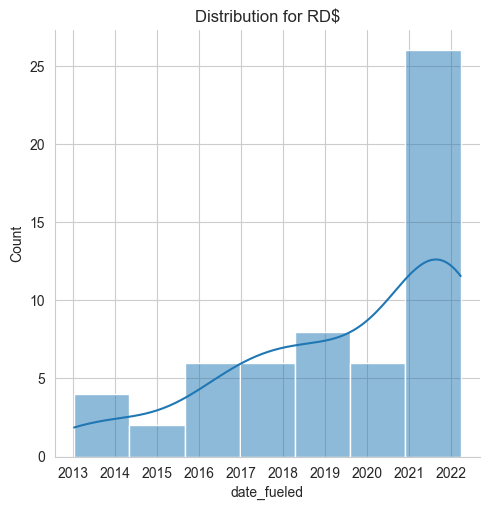

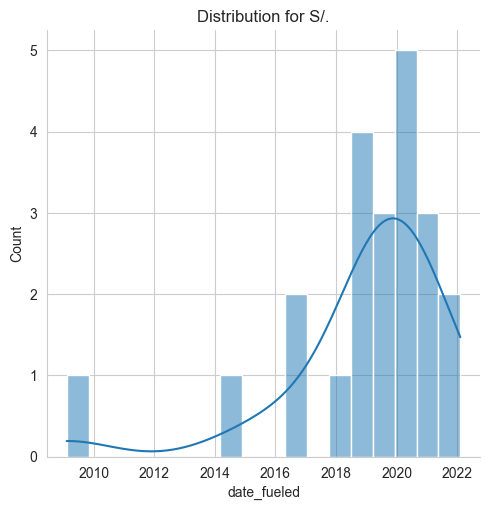

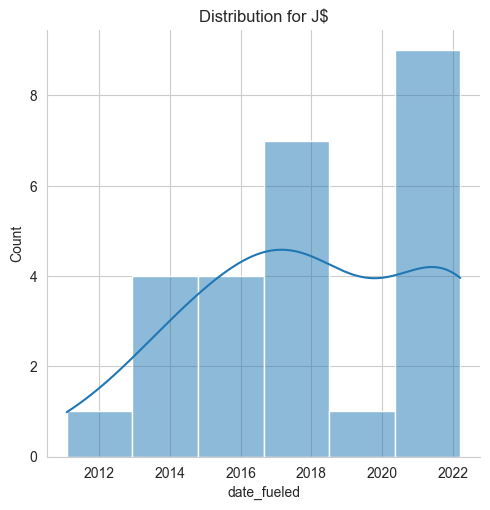

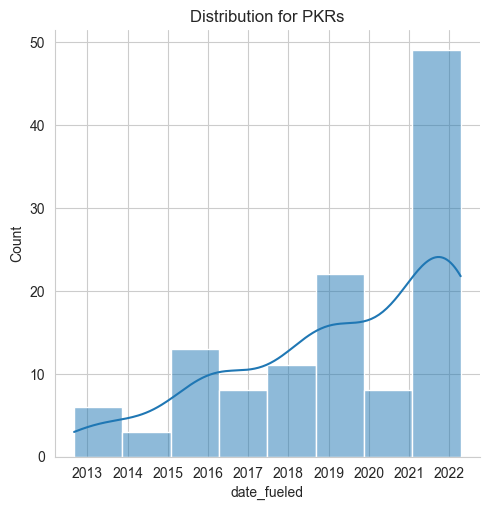

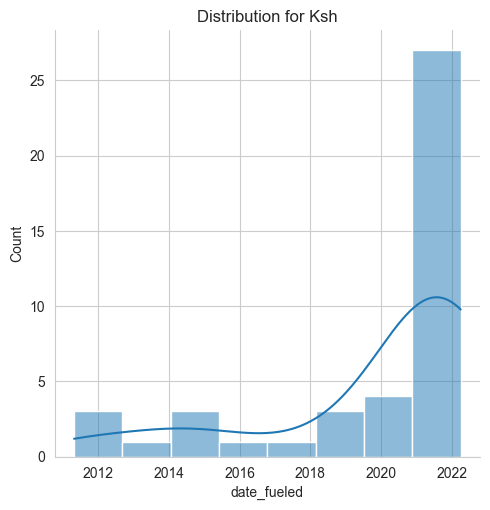

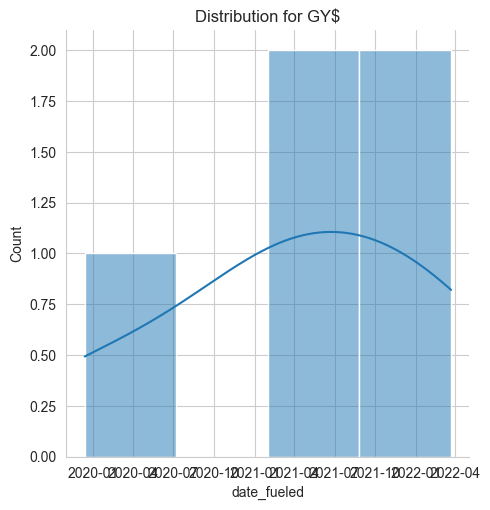

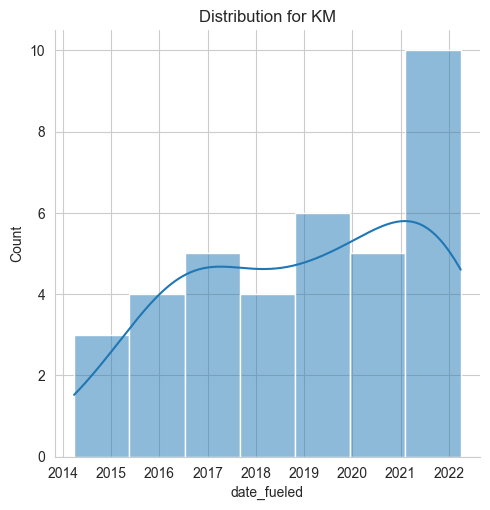

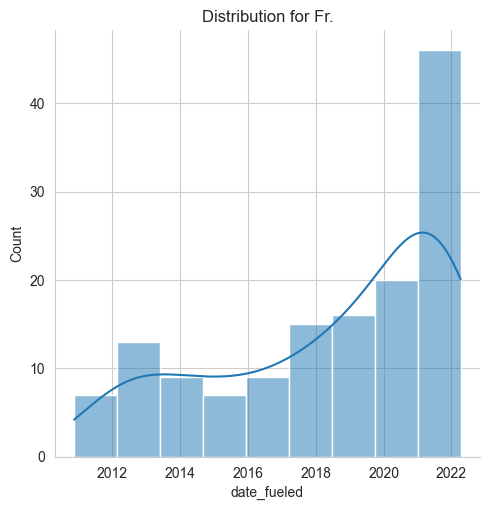

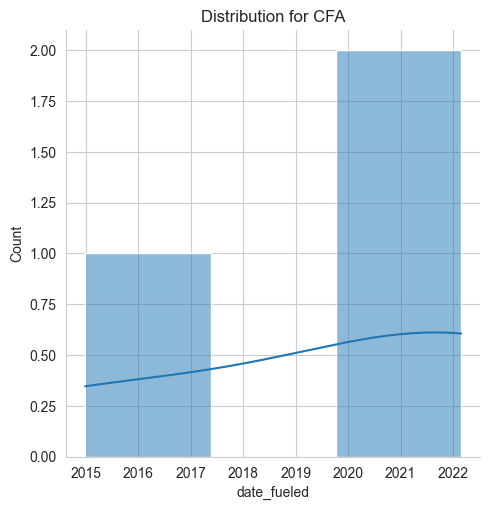

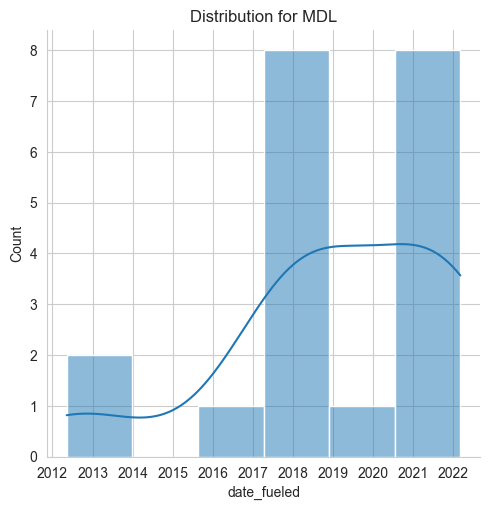

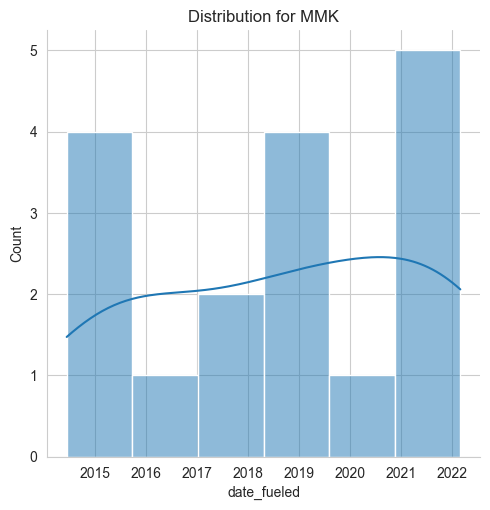

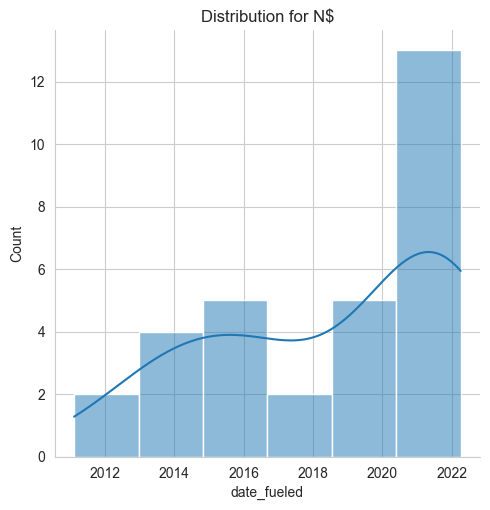

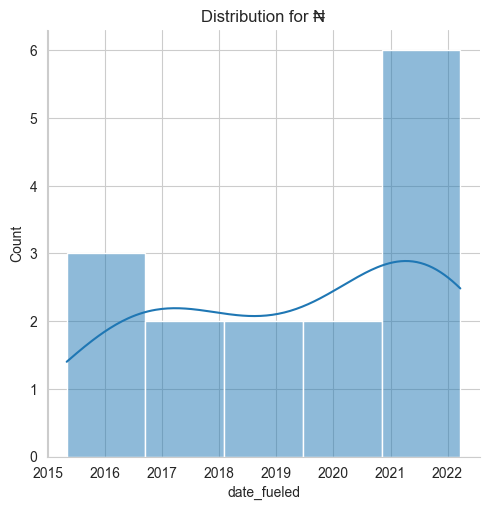

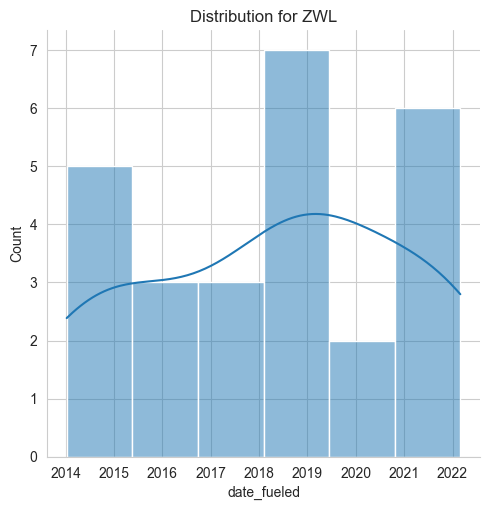

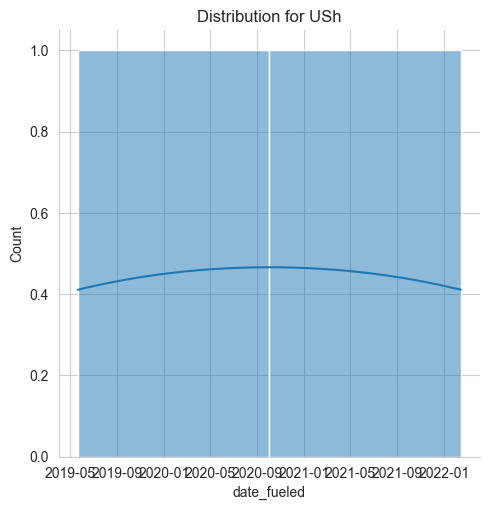

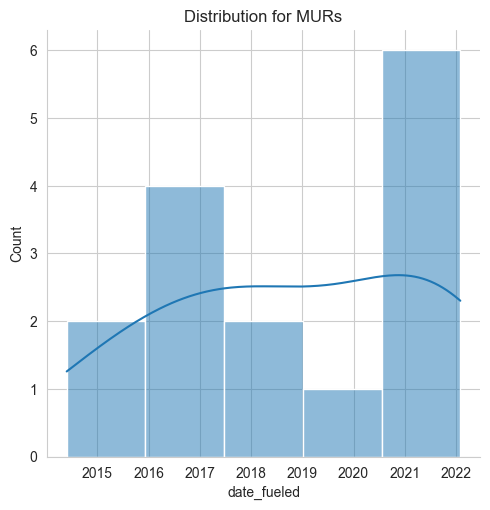

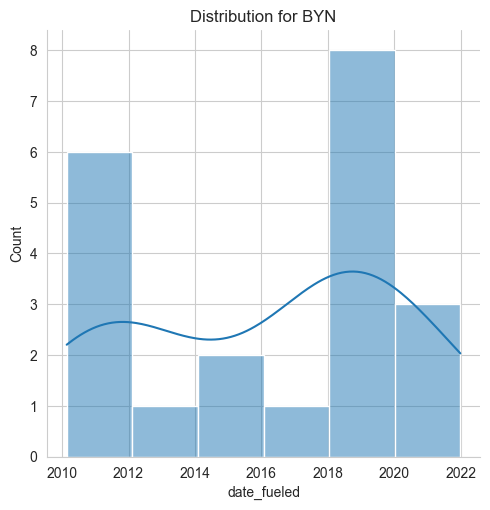

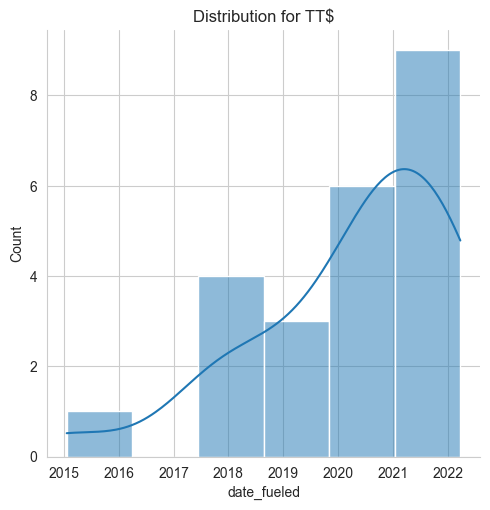

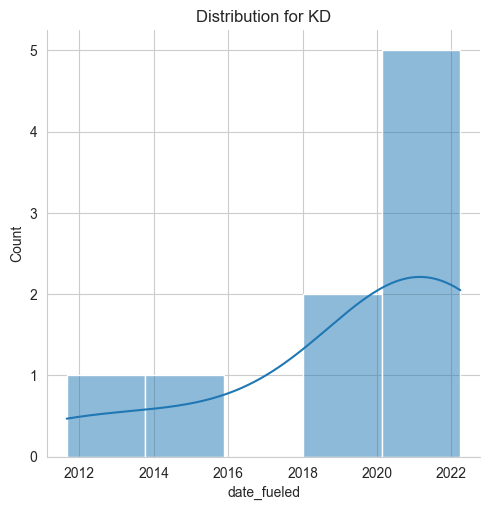

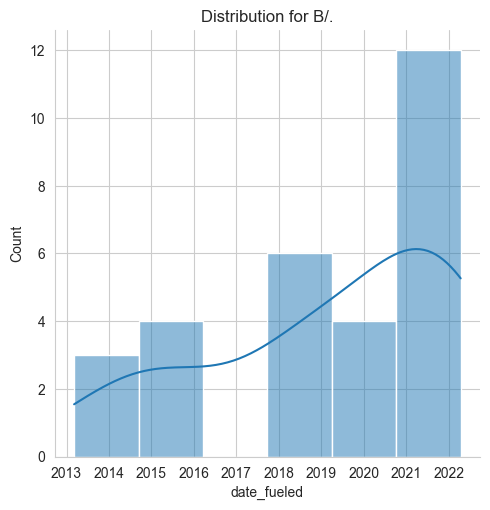

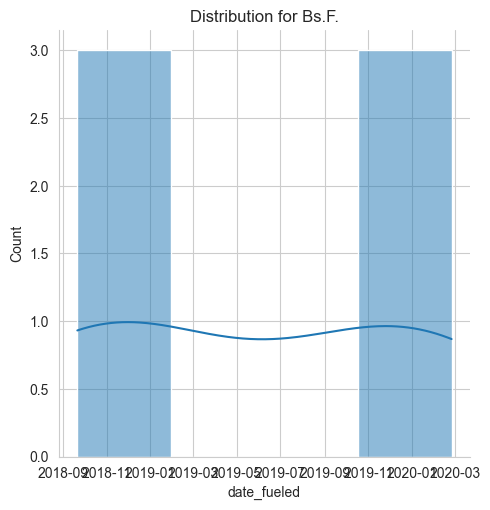

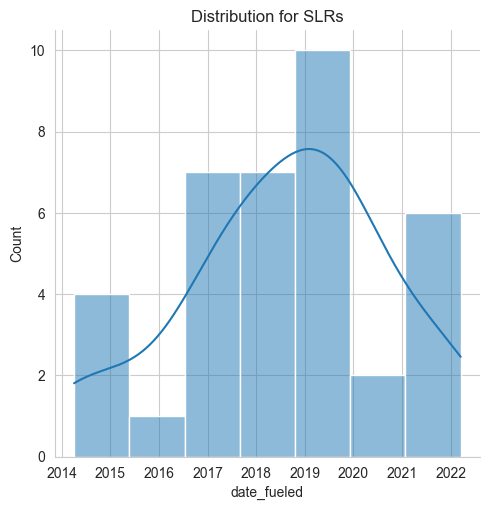

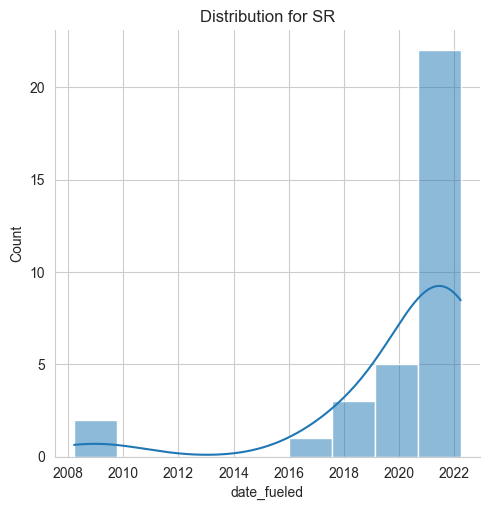

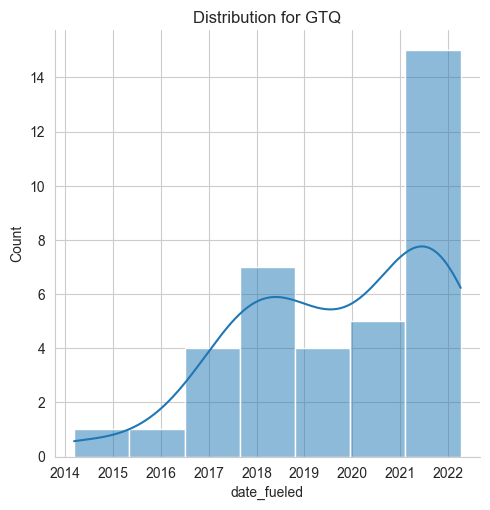

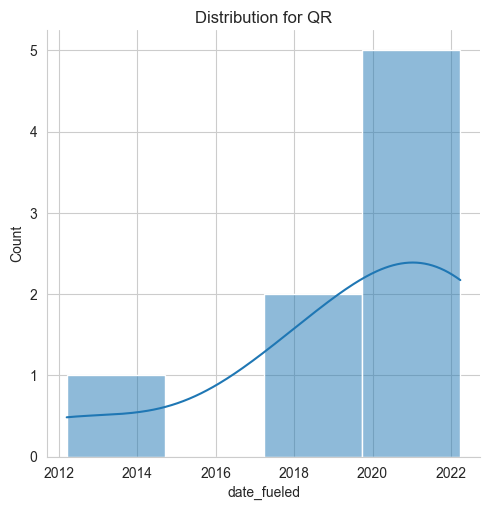

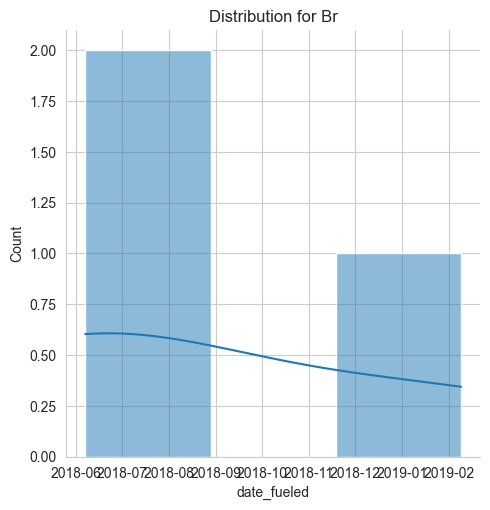

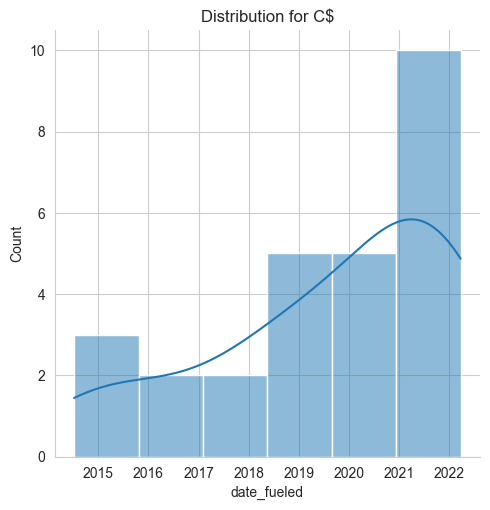

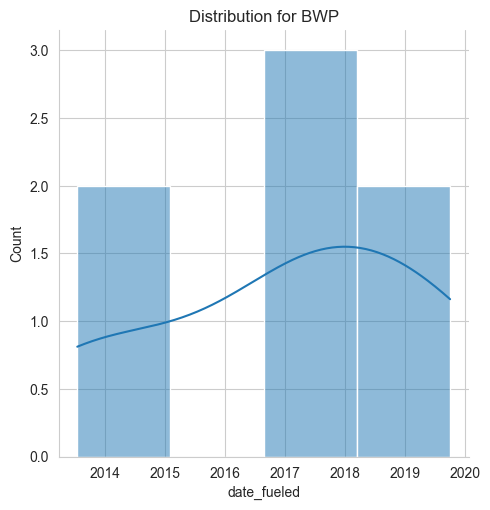

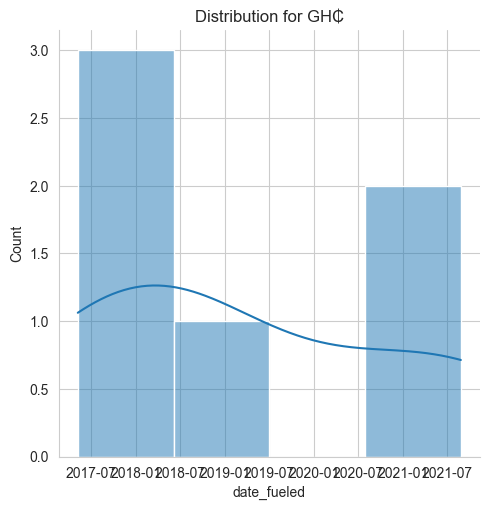

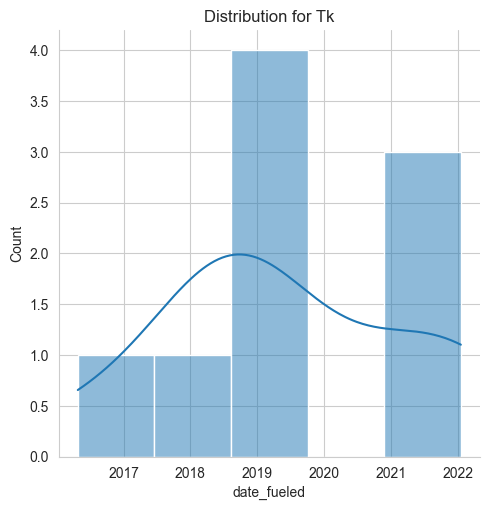

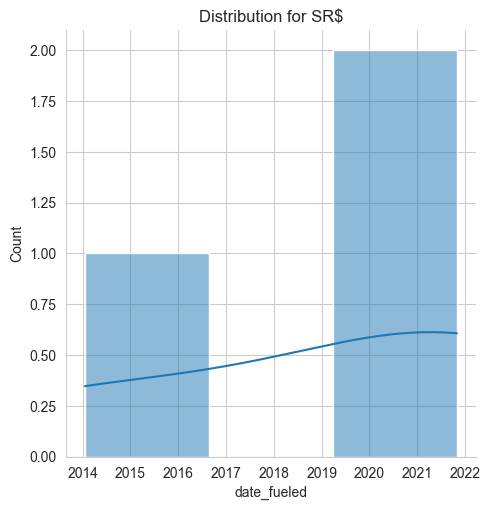

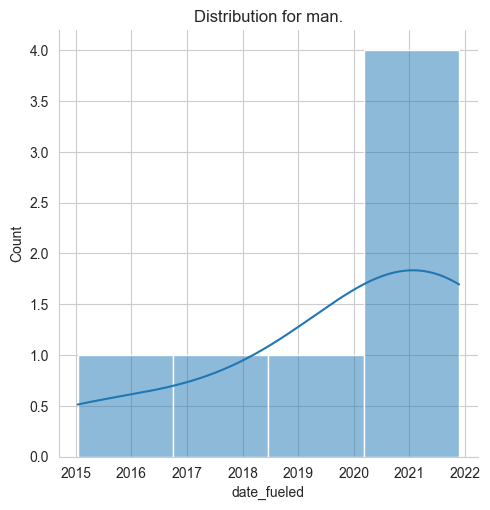

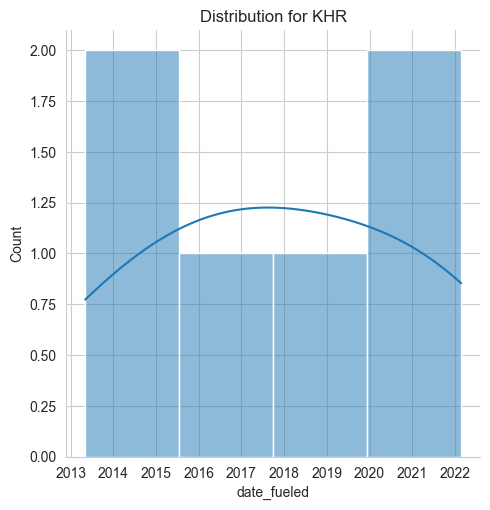

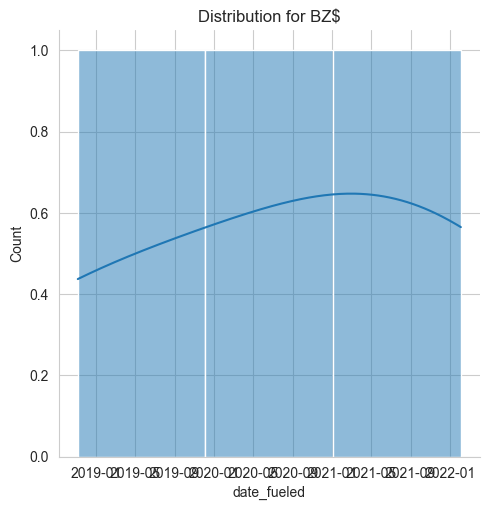

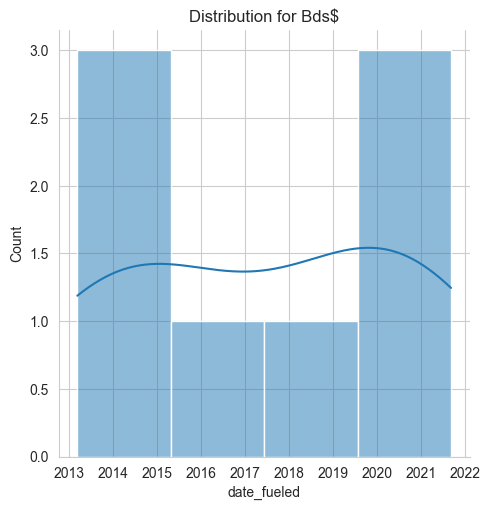

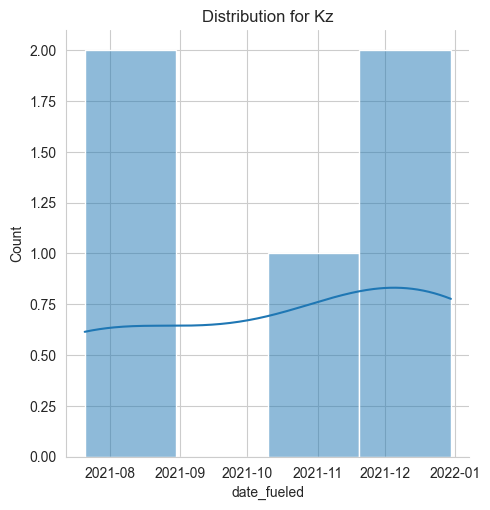

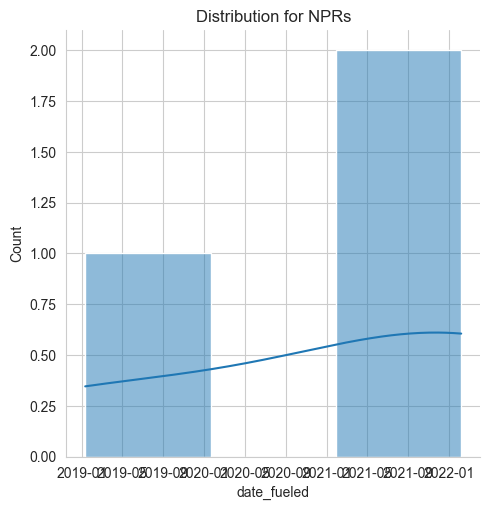

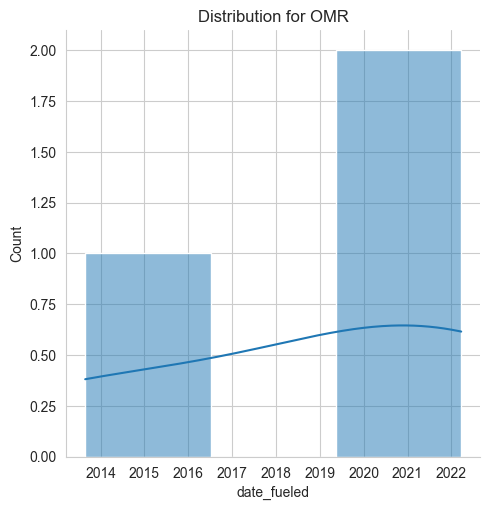

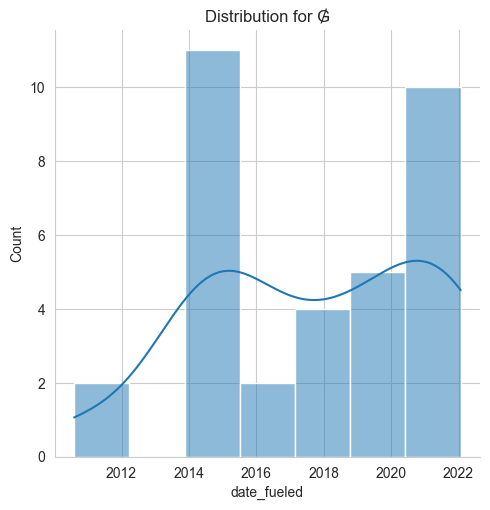

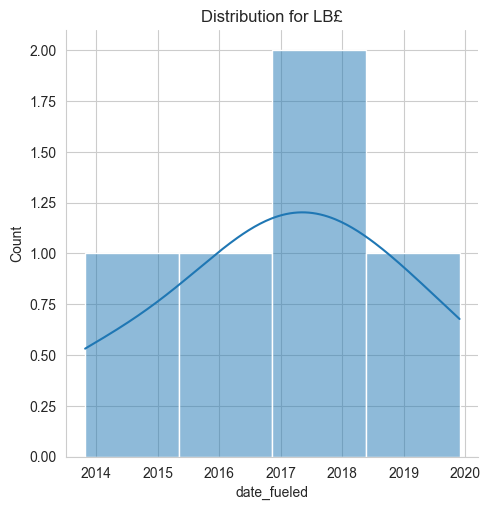

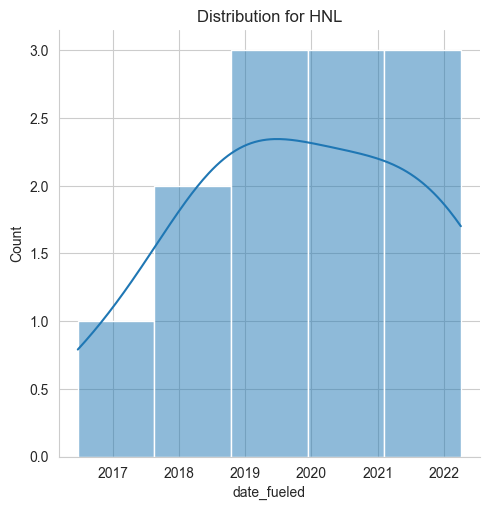

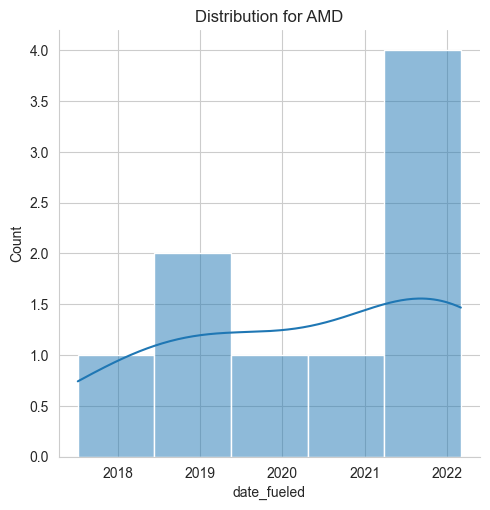

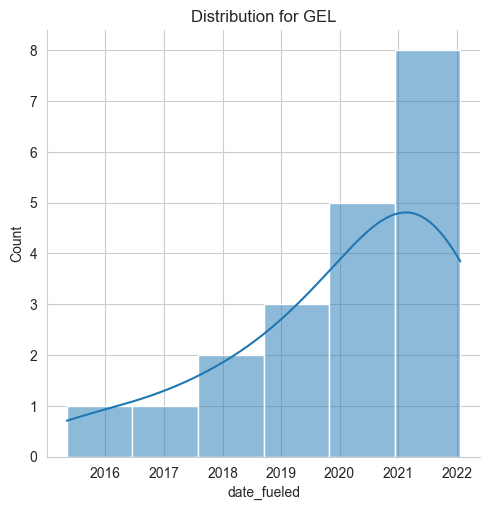

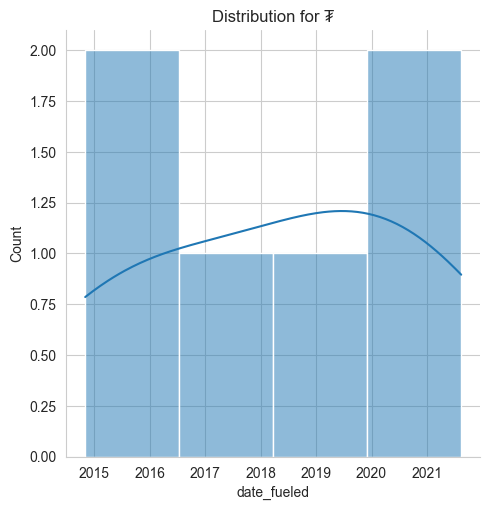

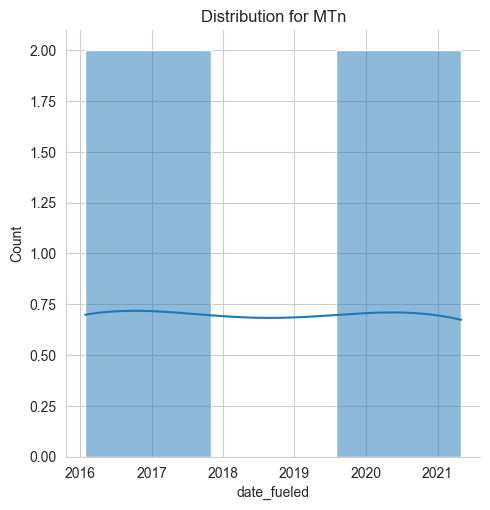

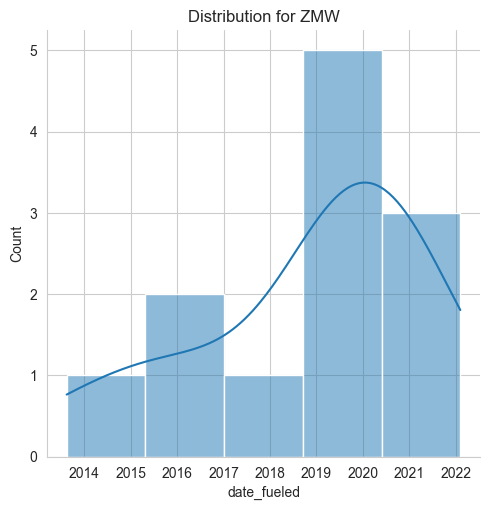

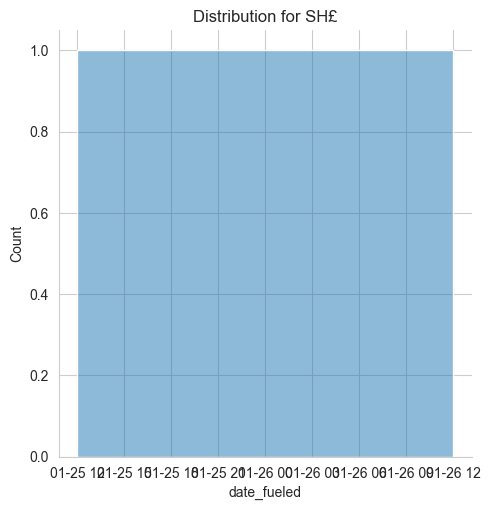

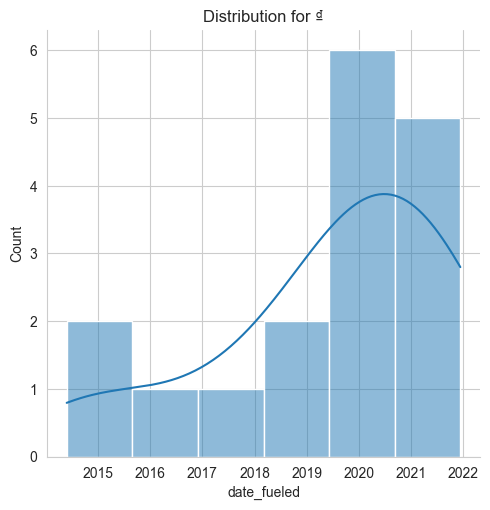

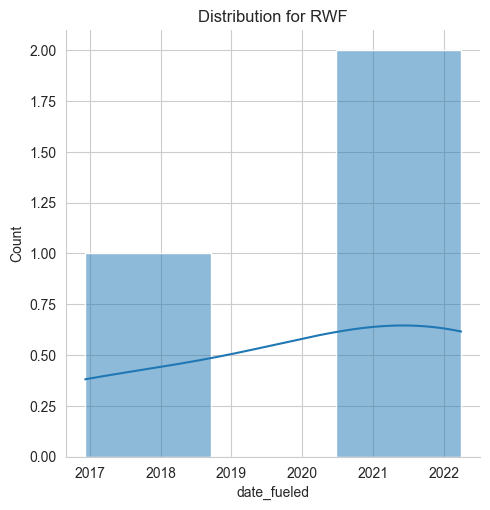

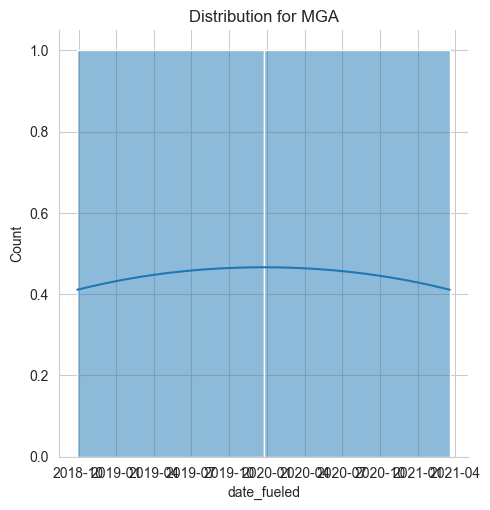

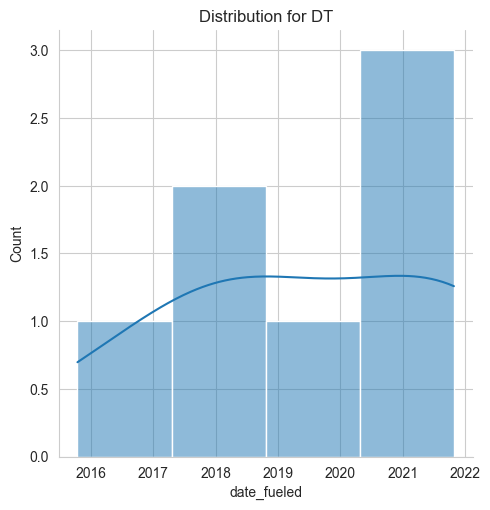

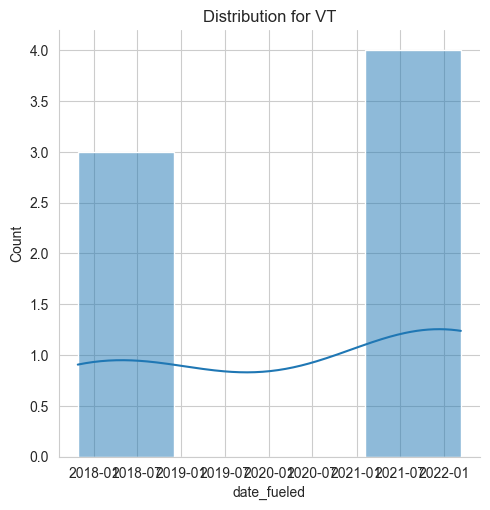

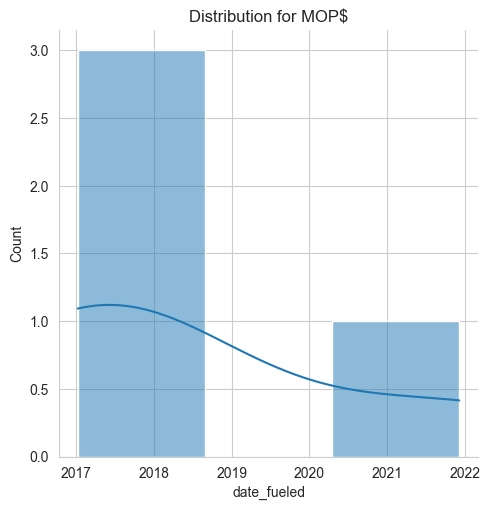

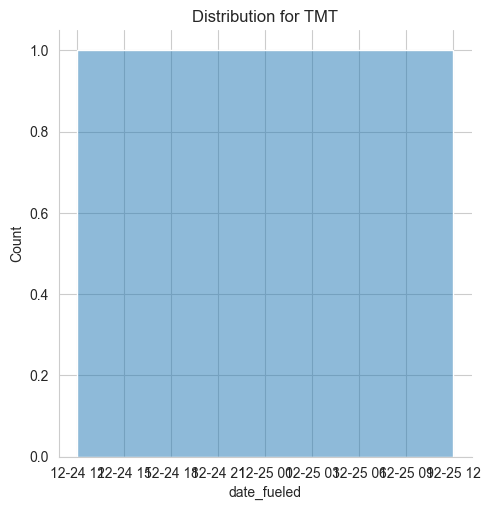

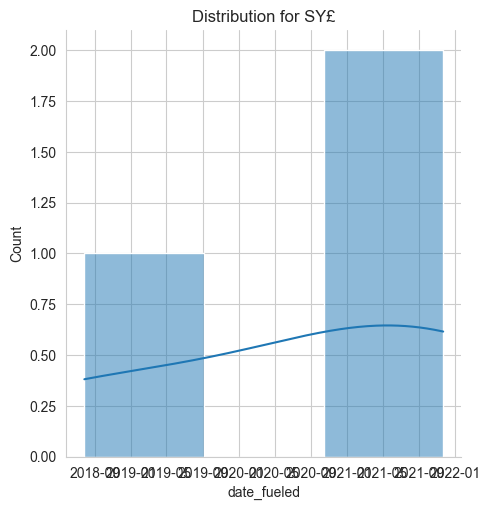

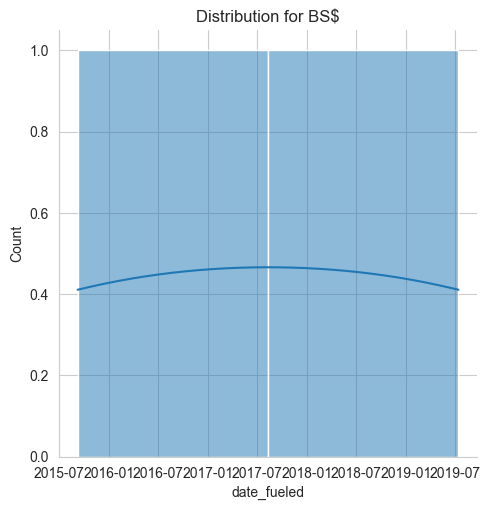

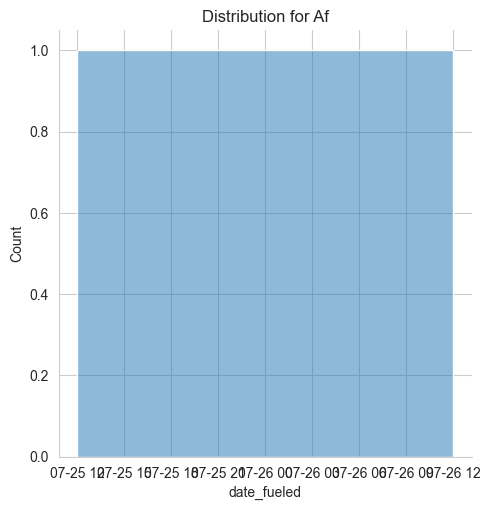

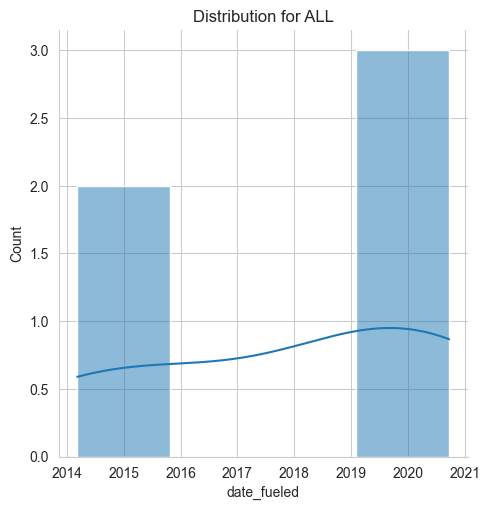

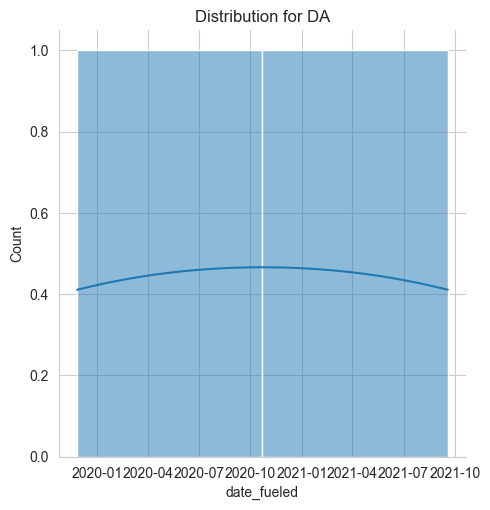

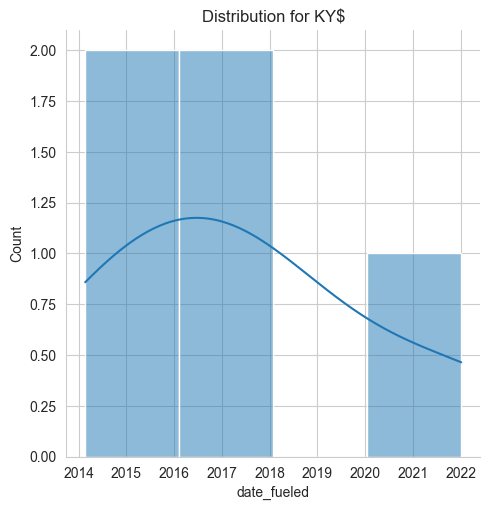

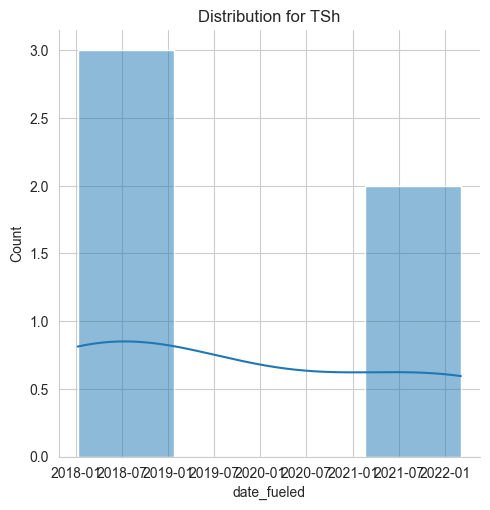

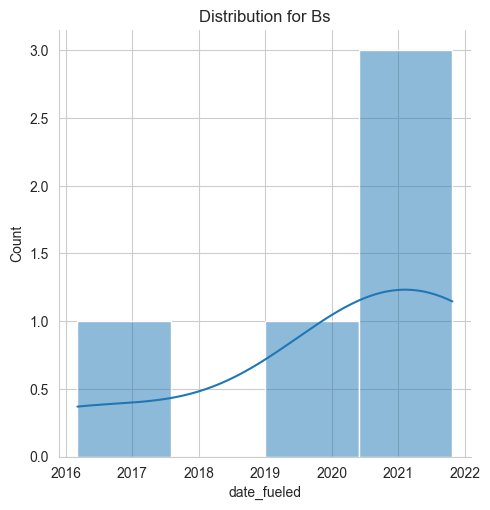

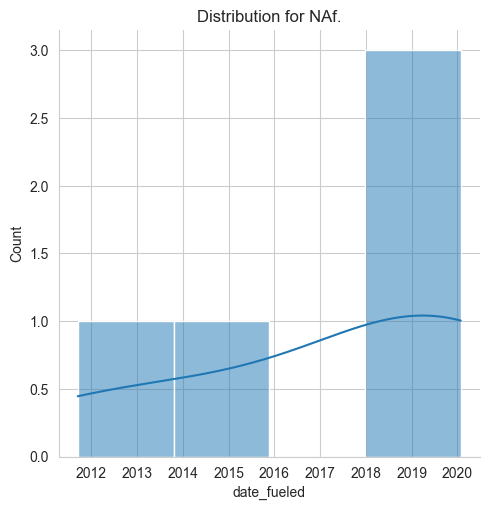

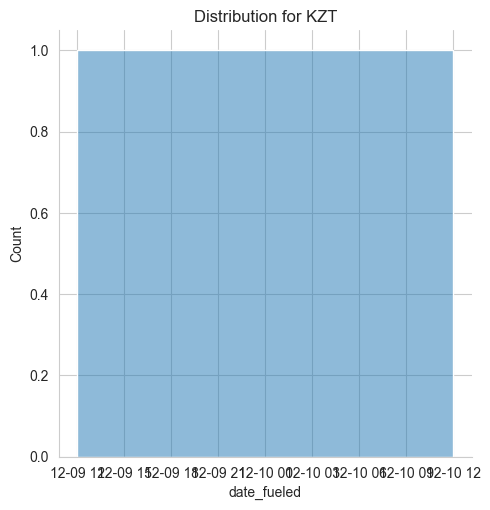

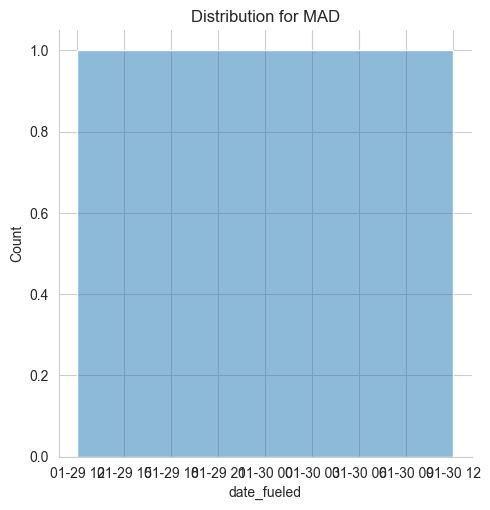

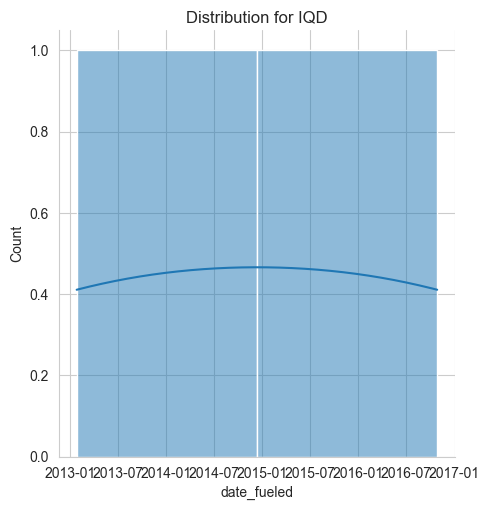

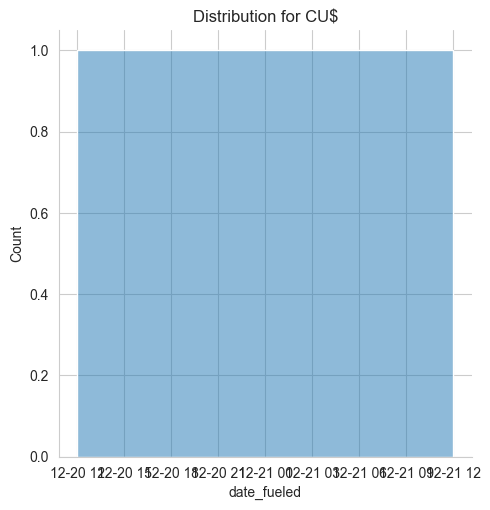

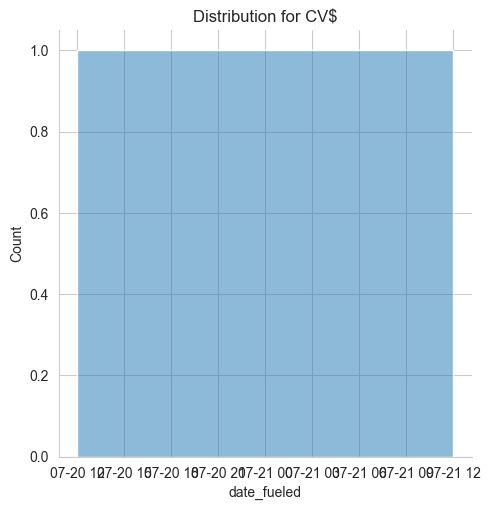

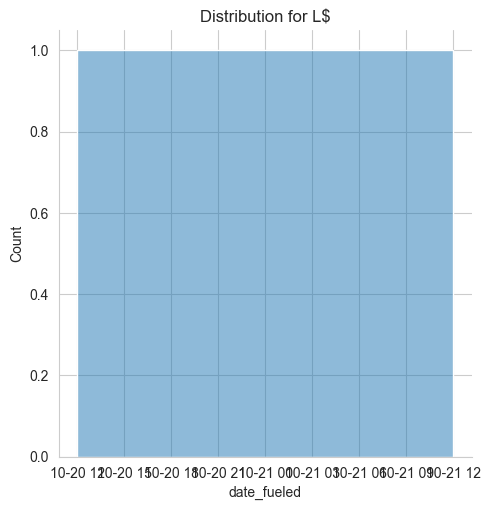

In [56]:
countries = unique_users_df['currency'].unique()

for country in countries:
    sns.displot(data=unique_users_df[unique_users_df['currency'] == country], 
                x="date_fueled", kde=True, height=5, aspect=1)
    plt.title(f'Distribution for {country}')
    plt.show()  # or plt.savefig(f'{country}_distribution.png') to save the plot



[3.4] Which makes and models of vehicles are the most popular?

In [57]:
cars_unique_users_df = unique_users_df.copy()

# Apply the function to extract details and add new columns to the DataFrame
cars_unique_users_df[['make', 'model', 'year', 'user_id']] = cars_unique_users_df['user_url'].apply(extract_car_details)
#cars_unique_users_df.tail()

KeyboardInterrupt: 

In [25]:
# Display examples to show that the handling of car details worked
display(cars_unique_users_df[cars_unique_users_df["make"]=="suzukiry"])
display(cars_unique_users_df[cars_unique_users_df["make"]=="other"])
display(cars_unique_users_df[cars_unique_users_df["make"]=="volkswagenavelle"])

Empty DataFrame
Columns: [date_fueled, date_captured, odometer, gallons, cost_per_gallon, total_spent, mpg, miles, user_url, is_valid_date, cost_per_gallon_float, total_spent_float, currency, total_spend, make, model, year, user_id, currency_type, litres_filled, km_driven, litres_per_100km]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [date_fueled, date_captured, odometer, gallons, cost_per_gallon, total_spent, mpg, miles, user_url, is_valid_date, cost_per_gallon_float, total_spent_float, currency, total_spend, make, model, year, user_id, currency_type, litres_filled, km_driven, litres_per_100km]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [date_fueled, date_captured, odometer, gallons, cost_per_gallon, total_spent, mpg, miles, user_url, is_valid_date, cost_per_gallon_float, total_spent_float, currency, total_spend, make, model, year, user_id, currency_type, litres_filled, km_driven, litres_per_100km]
Index: []

[0 rows x 22 columns]

make
ford              14395
toyota            13452
bmw               11059
nissan             8840
volkswagen         7679
mercedes-benz      6636
honda              6162
audi               5760
hyundai            4983
mazda              4664
lexus              3995
kia                3832
volvo              3680
mitsubishi         3494
jeep               3275
subaru             3207
land_rover         2160
suzuki             2058
peugeot            1890
renault            1741
fiat               1661
citroen            1437
opel               1101
alfa_romeo          908
mini                809
isuzu               630
incorrect_make      486
tata                 94
mahindra             52
Name: count, dtype: int64

model
mustang            815
f-150              780
land_cruiser       751
civic              743
corolla            737
                  ... 
duna                 1
presea               1
e-200_econoline      1
mk_ii                1
a200d                1
Name: count, Length: 2185, dtype: int64

<Axes: xlabel='count', ylabel='model'>

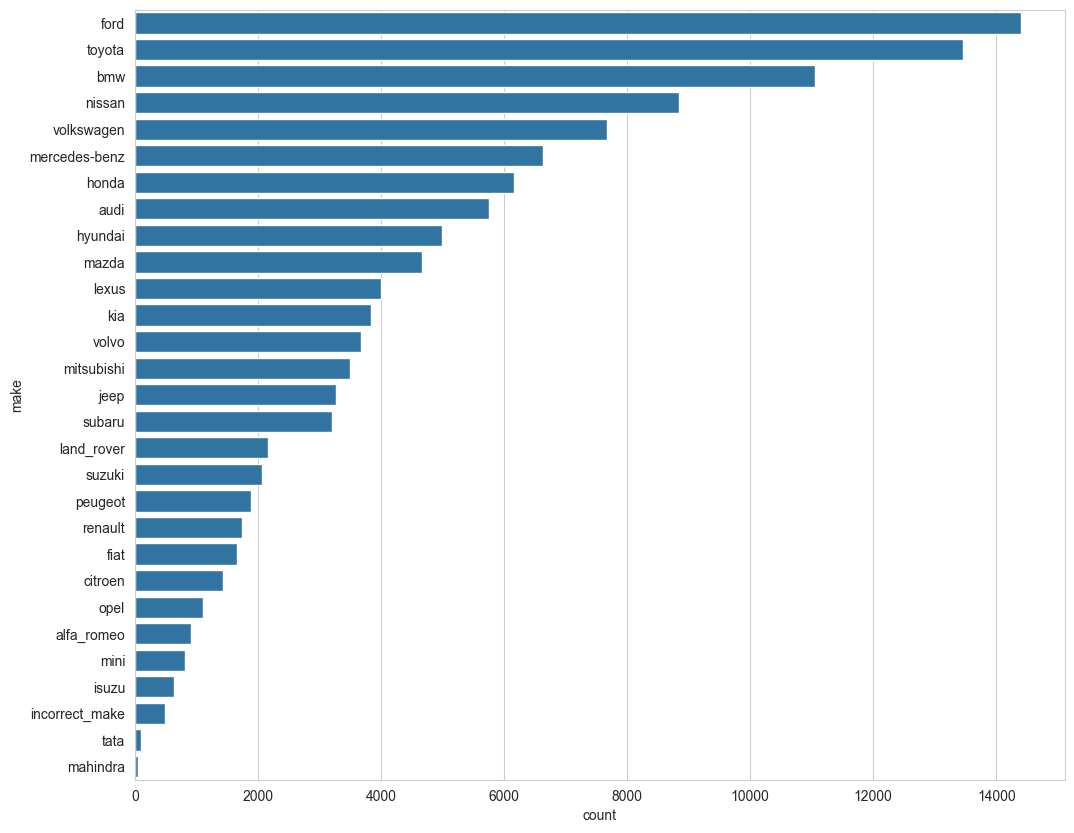

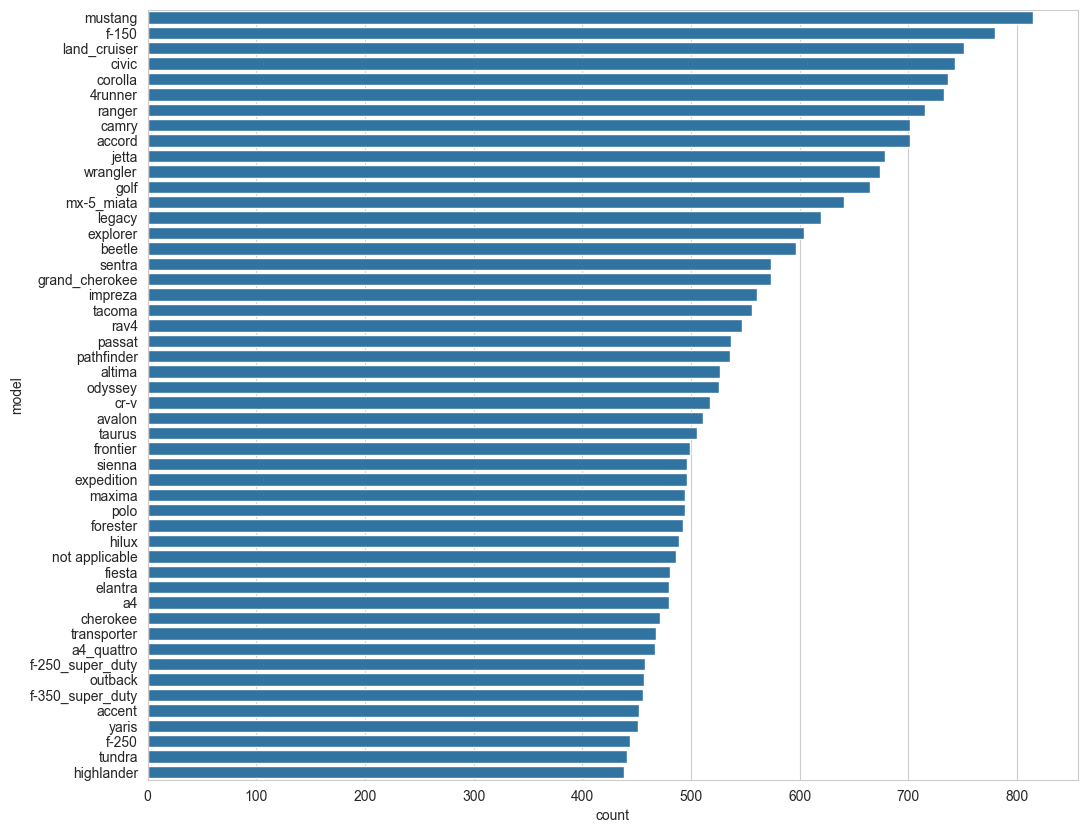

In [26]:
car_make_counts  = cars_unique_users_df['make'].value_counts()
car_model_counts = cars_unique_users_df['model'].value_counts()
car_year_counts  = cars_unique_users_df['year'].value_counts()

plt.figure(figsize=(12,10))
display(car_make_counts)
sns.barplot(car_make_counts, orient='y')
plt.figure(figsize=(12,10))
display(car_model_counts)
sns.barplot(car_model_counts.head(50), orient='y')

### Question 4: Fuel Usage

#### 4.1 Outlier Removal

[4.1] Outlier Removal: 1. Identify the top 5 currencies by number of transactions.

In [27]:
currency_counts = updated_df['currency'].value_counts()
top_5_currencies = currency_counts.head(5)

print(f'The top 5 currencies are:\n{top_5_currencies}')

top_currencies = top_5_currencies.index.tolist()
print(f'Top currencies list: {top_currencies}')

The top 5 currencies are:
currency
$      738396
£       86147
€       58441
CA$     46234
R       36034
Name: count, dtype: int64
Top currencies list: ['$', '£', '€', 'CA$', 'R']


[4.1] Outlier Removal: 2. For each of the top 5 currencies separately, remove outliers by considering
the total spend, litres, cost per litre, gallons, etc.

In [28]:
print(f'Using US gallon to litre conversion factor: {conversion_factor}')

# Create a new column 'cost_per_litre' by dividing the cost per gallon by the conversion factor
updated_df['cost_per_litre'] = updated_df['cost_per_gallon_float'] / conversion_factor

# Filter to only include rows with the top 5 currencies
df_top_5_currencies = updated_df[updated_df['currency'].isin(top_currencies)]
df_top_5_currencies.head()

Using US gallon to litre conversion factor: 3.78541


date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
1  2012-11-07    2016-08-30  11983.000   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28  98233.000    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04 163802.000   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15        NaN   11.651          $3.029      $35.29   
5  2021-10-23    2021-10-23 147567.000    3.413          $3.739      $12.76   

     mpg   miles                                           user_url  \
1 31.600 382.992     https://www.somewebsite.com/bmw/x3/2009/461150   
2 28.500 227.743  https://www.somewebsite.com/mercedes-benz/e300...   
3 46.800 494.910   https://www.somewebsite.com/bmw/320d/2010/247233   
4 21.000 244.400  https://www.somewebsite.com/honda/passport/201...   
5 29.000  98.977  https://www.somewebsite.com/volkswagen/passat/...   

   is_valid_date  ...  total_spend           make     model  year  user_id  \
1           True  ...       67.860            bmw        x3  2009   461150   
2           True  ...       43.551  mercedes-benz      e300  1998   133501   
3           True  ...       54.038            bmw      320d  2010   247233   
4           True  ...       35.291          honda  passport  2019  1038865   
5           True  ...       12.761     volkswagen    passat  2004   445811   

  currency_type litres_filled km_driven litres_per_100km  cost_per_litre  
1            US        45.879   616.364            7.444           1.479  
2            UK        30.249   366.517            8.253           1.440  
3            UK        40.031   796.478            5.026           1.350  
4            US        44.104   393.323           11.213           0.800  
5            US        12.920   159.288            8.111           0.988  

[5 rows x 23 columns]

##### Methodology for Outlier Removal

##### 1. **Determine Thresholds for Outlier Detection**
   - **Objective:** Establish reasonable ranges for different currencies and fields to identify and remove outliers.
   - **Steps:**
     - **Statistical Analysis:** Calculate key statistical measures (mean, median, quartiles, IQR) for each relevant field within each currency type.
       - Use `describe()` method from pandas to get quartiles (25th percentile, median, 75th percentile) and calculate the IQR.
     - **Define Thresholds:** Based on statistical analysis, set thresholds for detecting outliers:
       - For each currency, establish a reasonable range for fields like `total_spent_float`, `gallons`, and `cost_per_gallon_float` or equivalent metrics.
       - Use IQR to set boundaries: `Q1 - 1.5 * IQR` for lower bound and `Q3 + 1.5 * IQR` for upper bound.
       - Adjust thresholds based on practical considerations and known ranges in the real world.

##### 2. **Apply Thresholds to Identify Outliers**
   - **Objective:** Filter out data points that fall outside of the established thresholds.
   - **Steps:**
     - **Filtering Data:** For each currency, use the predefined thresholds to filter the dataset. For example:
       - For USD and CAD, apply thresholds on `total_spent_float`, `gallons`, and `cost_per_gallon_float`.
       - For GBP, Euro, and Rand, apply thresholds on `total_spent_float`, `litres_filled`, and `cost_per_litre`.

In [29]:

# Currencies and corresponding columns to analyze
currency_columns_mapping = {
    '$': ['total_spent_float', 'gallons', 'cost_per_gallon_float'],
    'CA$': ['total_spent_float', 'gallons', 'cost_per_gallon_float'],
    '£': ['total_spent_float', 'litres_filled', 'cost_per_litre'],
    '€': ['total_spent_float', 'litres_filled', 'cost_per_litre'],
    'R': ['total_spent_float', 'litres_filled', 'cost_per_litre']
}

# Analyze statistics for each currency
for currency, columns in currency_columns_mapping.items():
    calculate_stats(df_top_5_currencies, currency, columns)

Statistics for $:
       total_spent_float    gallons  cost_per_gallon_float
count         738396.000 738396.000             738396.000
mean             420.059     13.355                 40.203
std            11136.100     82.942               1047.838
min                0.000      0.000                  0.000
25%               30.000      9.475                  2.779
50%               41.030     12.384                  3.299
75%               55.750     15.311                  3.999
max          2241144.350  28380.000             132489.412

IQR:
total_spent_float       25.750
gallons                  5.836
cost_per_gallon_float    1.220
dtype: float64
Statistics for CA$:
       total_spent_float   gallons  cost_per_gallon_float
count          46234.000 46234.000              46234.000
mean              66.546    12.282                  5.635
std              366.423    66.867                 22.075
min                0.000     0.000                  0.000
25%               41.860   

#### General Approach:
1. **Total Spend (`total_spent_float`)**: I’ll consider values below Q1 - 1.5*IQR and above Q3 + 1.5*IQR as outliers.
2. **Gallons (`gallons`) / Litres (`litres_filled`)**: Similar to total spend, outliers will be those significantly outside the typical range.
3. **Cost per Gallon / Cost per Litre**: This is crucial, especially for identifying incorrect data (e.g., users mistakenly selecting the wrong currency). Extreme outliers could be excluded based on the IQR approach.

#### Suggested Thresholds

#### 1. **USD (`$`)**
- **Total Spend**:
  - Range: `1 to 130` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 30, Q3 = 56. The IQR is 25.75. I’ll consider outliers below 1 and above 130.
- **Gallons**:
  - Range: `1 to 30` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 9.47, Q3 = 15.31, with an IQR of 5.83. I’ll include a buffer and consider outliers below 1 and above 30.
- **Cost per Gallon**:
  - Range: `1 to 5` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 2.78, Q3 = 3.99, with an IQR of 1.22. Extreme values above 5 or below 1 are likely errors.

#### 2. **CAD (`CA$`)**
- **Total Spend**:
  - Range: `1 to 130` (Similar to USD)
  - Reasoning: Q1 = 41.86, Q3 = 72.25. The IQR is 30.39. A conservative range similar to USD is appropriate.
- **Gallons**:
  - Range: `1 to 30` (Similar to USD)
  - Reasoning: Q1 = 8.99, Q3 = 14.36. The IQR is 5.37. Outliers below 1 or above 30 are likely incorrect.
- **Cost per Gallon**:
  - Range: `3 to 7` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 4.31, Q3 = 5.55. The IQR is 1.24. Values below 3 or above 7 are suspect.

#### 3. **GBP (`£`)**
- **Total Spend**:
  - Range: `1 to 120` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 37.96, Q3 = 67.59, with an IQR of 29.63. I’ll consider values below 1 and above 120 as outliers.
- **Litres Filled**:
  - Range: `1 to 85` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 31.26, Q3 = 53.13, with an IQR of 21.87. Outliers below 1 or above 85 are likely incorrect.
- **Cost per Litre**:
  - Range: `0.5 to 2` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 1.16, Q3 = 1.36, with an IQR of 0.2. I’ll exclude extreme values below 0.5 or above 2.

#### 4. **Euro (`€`)**
- **Total Spend**:
  - Range: `1 to 125` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 38.2, Q3 = 70.22, with an IQR of 32.02. Outliers below 1 or above 125 are likely errors.
- **Litres Filled**:
  - Range: `1 to 85` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 29.07, Q3 = 51.0, with an IQR of 21.93. Values below 1 or above 85 are suspect.
- **Cost per Litre**:
  - Range: `0.5 to 2` (Similar to GBP)
  - Reasoning: Q1 = 1.23, Q3 = 1.55, with an IQR of 0.32. Values below 0.5 or above 2 are outliers.

#### 5. **Rand (`R`)**
- **Total Spend**:
  - Range: `100 to 1500` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 469.32, Q3 = 902.52, with an IQR of 433.2. Values below 100 or above 1500 are likely incorrect.
- **Litres Filled**:
  - Range: `1 to 90` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 33.5, Q3 = 61.0, with an IQR of 27.5. Values below 1 or above 90 are likely errors.
- **Cost per Litre**:
  - Range: `10 to 25` (Based on Q1-1.5*IQR and Q3+1.5*IQR)
  - Reasoning: Q1 = 12.79, Q3 = 16.48, with an IQR of 3.69. Outliers below 10 or above 25 are unrealistic.

In [30]:
# Define outlier thresholds for each currency
currency_thresholds = {
    '$': {
        'total_spent_float': (1, 130),  
        'gallons': (1, 30),             
        'cost_per_gallon_float': (1, 5) 
    },
    '£': {
        'total_spent_float': (1, 120),  
        'litres_filled': (1, 85),       
        'cost_per_litre': (0.5, 2)      
    },
    '€': {
        'total_spent_float': (1, 125),  
        'litres_filled': (1, 85),       
        'cost_per_litre': (0.5, 2)      
    },
    'CA$': {
        'total_spent_float': (1, 130),  
        'gallons': (1, 30),            
        'cost_per_gallon_float': (3, 7) 
    },
    'R': {
        'total_spent_float': (100, 1500),  
        'litres_filled': (1, 90),         
        'cost_per_litre': (10, 25)     
    }
}


# Apply outlier removal for each currency
cleaned_dfs = []
for currency, thresholds in currency_thresholds.items():
    cleaned_df = remove_outliers_by_currency(df_top_5_currencies, currency, thresholds)
    cleaned_dfs.append(cleaned_df)

# Combine cleaned data back into one DataFrame
df_top_5_curr_cleaned = pd.concat(cleaned_dfs, ignore_index=True)

# Check the shape before and after to see how many rows were removed
print(f"Original Top 5 Currency dataset shape: {df_top_5_currencies.shape}")
print(f"Cleaned Top 5 Currency dataset shape: {df_top_5_curr_cleaned.shape}")


Original Top 5 Currency dataset shape: (965252, 23)
Cleaned Top 5 Currency dataset shape: (854761, 23)


[4.1] Outlier Removal: 3. How many values have been removed after accounting for outliers?

In [31]:
num_values_removed = df_top_5_currencies.shape[0] - df_top_5_curr_cleaned.shape[0]
print(f'Number of values removed after accounting for outliers: {num_values_removed}')

Number of values removed after accounting for outliers: 110491


In [32]:
updated_df.head()

date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07  73370.000      NaN             NaN         NaN   
1  2012-11-07    2016-08-30  11983.000   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28  98233.000    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04 163802.000   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15        NaN   11.651          $3.029      $35.29   

     mpg   miles                                           user_url  \
0    NaN     NaN  https://www.somewebsite.com/suzuki/swift/2015/...   
1 31.600 382.992     https://www.somewebsite.com/bmw/x3/2009/461150   
2 28.500 227.743  https://www.somewebsite.com/mercedes-benz/e300...   
3 46.800 494.910   https://www.somewebsite.com/bmw/320d/2010/247233   
4 21.000 244.400  https://www.somewebsite.com/honda/passport/201...   

   is_valid_date  ...  total_spend           make     model  year  user_id  \
0           True  ...          NaN         suzuki     swift  2015   674857   
1           True  ...       67.860            bmw        x3  2009   461150   
2           True  ...       43.551  mercedes-benz      e300  1998   133501   
3           True  ...       54.038            bmw      320d  2010   247233   
4           True  ...       35.291          honda  passport  2019  1038865   

  currency_type litres_filled km_driven litres_per_100km  cost_per_litre  
0         Other           NaN       NaN              NaN             NaN  
1            US        45.879   616.364            7.444           1.479  
2            UK        30.249   366.517            8.253           1.440  
3            UK        40.031   796.478            5.026           1.350  
4            US        44.104   393.323           11.213           0.800  

[5 rows x 23 columns]

#### 4.2 Fuel Efficiency

[4.2] 1. Fuel Efficiency: Look at the difference in cost per litre per country for January 2022 - use the average currency conversion rate to Rands (quote your values and source). Are there any notable differences? Discuss reasons why this may/may not be the case. (https://www.x-rates.com/average/?from=USD&to=ZAR&amount=1&year=2022#google_vignette)
1. USD (`$`) to Rands (`R`) - $1 = R15.518617
2. CAD (`CA$`) to Rands (`R`) - CA$ = R12.289890
3. GBP (`£`) to Rands (`R`) - £1 = R21.037880 
4. Euro (`€`) to Rands (`R`) - €1 = R17.575064

In [33]:
conversion_rates = {
    '$': 15.518617,
    'CA$': 12.289890,
    '£' : 21.037880,
    '€': 17.575064
}

# Convert cost per litre to ZAR directly
df_top_5_curr_cleaned['cost_per_litre_zar'] = df_top_5_curr_cleaned.apply(
    lambda row: row['cost_per_litre'] * conversion_rates.get(row['currency'], 1),
    axis=1
)

df_top_5_curr_cleaned.head()

# Optional: Analyze and discuss differences
min_cost = df_top_5_curr_cleaned['cost_per_litre_zar'].min()
max_cost = df_top_5_curr_cleaned['cost_per_litre_zar'].max()
average_cost = df_top_5_curr_cleaned['cost_per_litre_zar'].mean()

print(f"\nMinimum cost per litre (ZAR): {min_cost:.2f} ZAR")
print(f"Maximum cost per litre (ZAR): {max_cost:.2f} ZAR")
print(f"Average cost per litre (ZAR): {average_cost:.2f} ZAR")


Minimum cost per litre (ZAR): 4.10 ZAR
Maximum cost per litre (ZAR): 42.07 ZAR
Average cost per litre (ZAR): 15.44 ZAR


Average cost per litre (ZAR) for January 2022 by currency:
currency
$     14.090
CA$   17.965
R     18.925
£     30.702
€     27.666
Name: cost_per_litre_zar, dtype: float64


C:\Users\zachs\AppData\Local\Temp\ipykernel_34404\1109402833.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, average_cost_per_litre[i] + 0.5, f'{average_cost_per_litre[i]:.2f}',


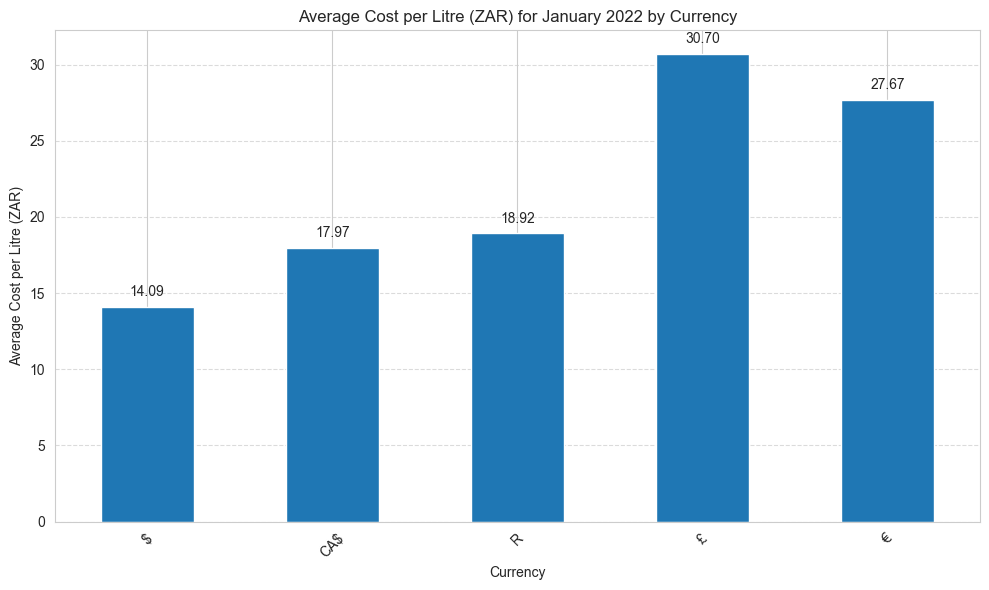

In [34]:
df_jan_2022 = df_top_5_curr_cleaned[df_top_5_curr_cleaned['date_fueled'].dt.month == 1]
df_jan_2022 = df_jan_2022[df_jan_2022['date_fueled'].dt.year == 2022]

# Calculate average cost per litre (ZAR) by currency
average_cost_per_litre = df_jan_2022.groupby('currency')['cost_per_litre_zar'].mean()

print("Average cost per litre (ZAR) for January 2022 by currency:")
print(average_cost_per_litre)

plt.figure(figsize=(10, 6))
average_cost_per_litre.plot(kind='bar')
plt.title('Average Cost per Litre (ZAR) for January 2022 by Currency')
plt.xlabel('Currency')
plt.ylabel('Average Cost per Litre (ZAR)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the value labels on top of the bars
for i in range(len(average_cost_per_litre)):
    plt.text(i, average_cost_per_litre[i] + 0.5, f'{average_cost_per_litre[i]:.2f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

[4.2] 2. Looking at the odometer readings, find examples of where users have missed logging a fill-up. Give a basic rule for identifying this, and estimate how many there are in the dataset.

In [35]:
df_odometer = df_top_5_curr_cleaned.copy()
df_odometer = df_odometer.sort_values(by=['user_id', 'date_fueled'])
df_odometer = df_odometer.dropna(subset=['odometer'])

df_odometer['odometer_diff'] = df_odometer.groupby('user_id')['odometer'].diff()
#more than 500 miles between two fill-ups
threshold = 500 
df_odometer['potential_missed_fill_up'] = df_odometer['odometer_diff'] > threshold
missed_fill_ups = df_odometer['potential_missed_fill_up'].sum()
print(f"Estimated number of potential missed fill-ups: {missed_fill_ups}")

Estimated number of potential missed fill-ups: 326057


In [36]:
df_odometer.head(20)

date_fueled date_captured   odometer  gallons cost_per_gallon  \
515895  2021-02-07    2021-02-09 104824.000    9.272          $2.199   
836156  2011-12-19    2012-01-02  73864.000   15.090          R43.99   
826090  2012-01-03    2012-01-02  74605.000   14.289          R43.30   
826923  2012-01-05    2012-01-05  75000.000   12.736          R42.59   
845805  2012-01-19    2012-01-23  76322.000   15.303          R42.59   
850457  2012-01-23    2012-01-23  76733.000   14.149          R42.59   
844530  2012-02-12    2012-03-11  78909.000   10.361          R42.74   
853125  2012-02-13    2012-03-11  79370.000   16.125          R42.51   
827749  2012-03-08    2012-03-11  82317.000   14.210          R42.47   
840739  2012-03-11    2012-03-11  82723.000   14.075          R42.47   
842396  2012-03-17    2012-04-09  83525.000   15.882          R43.15   
833689  2012-03-27    2012-04-09  84193.000   12.556          R42.85   
838224  2012-03-29    2012-04-09  84541.000   11.473          R42.85   
826300  2012-04-05    2012-04-09  85202.000   11.293          R44.90   
387214  2020-05-24    2020-05-24  33742.000   16.790          $2.339   
456951  2021-03-06    2021-03-06  35204.000   19.050          $3.019   
32518   2021-04-03    2021-04-03  35543.000   18.420          $3.099   
553900  2021-04-12    2021-04-12  35947.000   20.001          $3.069   
206365  2021-09-26    2021-09-26  37456.000   19.180          $3.349   
186695  2020-04-20    2020-04-20 185401.000    9.830          $2.470   

       total_spent    mpg   miles  \
515895      $20.39 23.100 214.183   
836156     R663.75 30.600 461.754   
826090     R618.79 26.900 384.374   
826923     R542.38 31.000 394.816   
845805     R651.69 28.300 433.075   
850457     R602.55 29.000 410.321   
844530     R442.80 30.800 319.119   
853125     R685.47 28.600 461.175   
827749     R603.53 28.000 397.880   
840739     R597.79 28.800 405.360   
842396     R685.37 27.700 439.931   
833689     R538.04 26.700 335.245   
838224     R491.63 30.300 347.632   
826300     R507.00 25.600 289.101   
387214      $39.27 21.400 359.306   
456951      $57.51 18.500 352.425   
32518       $57.08 18.400 338.928   
553900      $61.38 20.200 404.020   
206365      $64.23 21.600 414.288   
186695      $24.28 16.700 164.161   

                                                 user_url  is_valid_date  ...  \
515895  https://www.somewebsite.com/volkswagen/fox/198...           True  ...   
836156  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
826090  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
826923  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
845805  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
850457  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
844530  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
853125  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
827749  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
840739  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
842396  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
833689  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
838224  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
826300  https://www.somewebsite.com/mercedes-benz/c220...           True  ...   
387214  https://www.somewebsite.com/mercedes-benz/sl50...           True  ...   
456951  https://www.somewebsite.com/mercedes-benz/sl50...           True  ...   
32518   https://www.somewebsite.com/mercedes-benz/sl50...           True  ...   
553900  https://www.somewebsite.com/mercedes-benz/sl50...           True  ...   
206365  https://www.somewebsite.com/mercedes-benz/sl50...           True  ...   
186695  https://www.somewebsite.com/nissan/frontier/20...           True  ...   

        year  

A basic rule for identifying missed fill-ups is to calculate the difference in odometer readings between consecutive fill-ups. If the difference exceeds 500 miles, it can be assumed that a fill-up was missed. This rule was applied by sorting the data by user_id and date_fueled to accurately calculate the odometer difference for each user's consecutive entries.

[4.2] 3. Plot the average distance (in km) per tank per country. Which country has the largest average distance? Provide some explanations for why this might be the case.

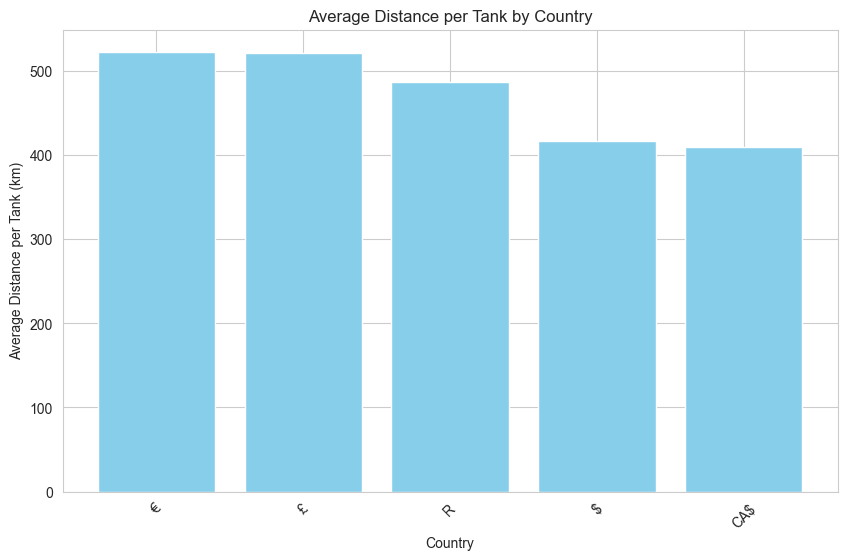

Country with the largest average distance per tank: € with 522.5636636344653 km.


In [37]:
average_distance_per_country = df_top_5_curr_cleaned.groupby('currency')['km_driven'].mean().reset_index()

# Sort values to identify the country with the largest average distance
average_distance_per_country = average_distance_per_country.sort_values(by='km_driven', ascending=False)

# Plotting the average distance per tank per country
plt.figure(figsize=(10, 6))
plt.bar(average_distance_per_country['currency'], average_distance_per_country['km_driven'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Average Distance per Tank (km)')
plt.title('Average Distance per Tank by Country')
plt.xticks(rotation=45)
plt.show()

# Identify the country with the largest average distance
largest_avg_distance_country = average_distance_per_country.iloc[0]
print(f"Country with the largest average distance per tank: {largest_avg_distance_country['currency']} with {largest_avg_distance_country['km_driven']} km.")

[4.2] 4. Do newer vehicles drive further distances between fill-ups? Provide a plot to show this.

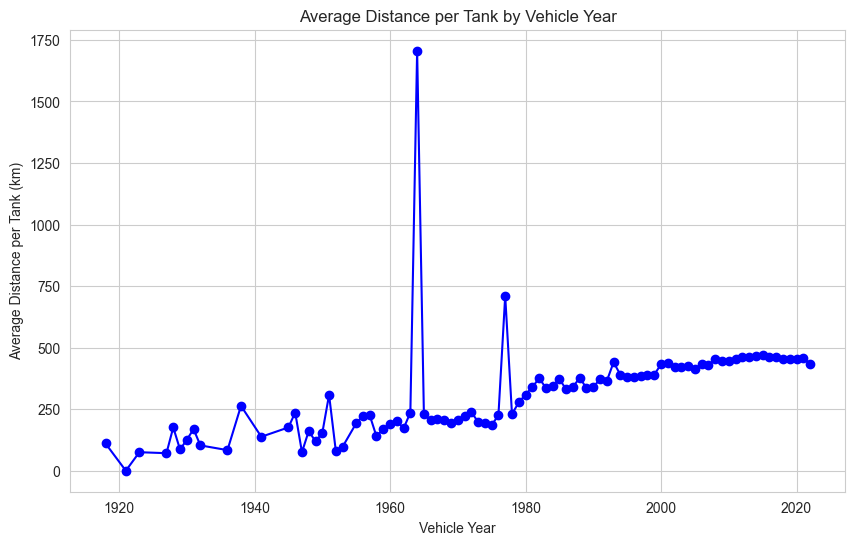

In [38]:
df_year = df_top_5_curr_cleaned.copy()

df_year['year'] = pd.to_datetime(df_year['year'], format='%Y', errors='coerce')
# year_counts = df_year.groupby('year').size().reset_index(name='count')
# display all years that have at least one car
# print("Car counts by year:")
# print(year_counts)

df_year = df_year.dropna(subset=['year'])
df_year['year'] = df_year['year'].dt.year
average_distance_per_year = df_year.groupby('year')['km_driven'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(average_distance_per_year['year'], average_distance_per_year['km_driven'], marker='o', linestyle='-', color='blue')
plt.xlabel('Vehicle Year')
plt.ylabel('Average Distance per Tank (km)')
plt.title('Average Distance per Tank by Vehicle Year')
plt.grid(True)
plt.show()

[4.2] 5. Take the top 5 most popular vehicles in SA (ie, those with currency set to R). Compute their fuel efficiency and discuss whether these values are realistic. 

In [39]:
df_top_5_curr_cleaned.head()

date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
0  2022-02-15    2022-02-15        NaN   11.651          $3.029      $35.29   
1  2021-10-23    2021-10-23 147567.000    3.413          $3.739      $12.76   
2  2021-11-20    2021-12-12 105929.000    9.044          $4.639      $41.96   
3  2022-01-20    2022-01-20  59475.000   14.962          $2.929      $43.82   
4  2020-11-29    2020-11-29  99296.000    2.710          $1.999       $5.42   

     mpg   miles                                           user_url  \
0 21.000 244.400  https://www.somewebsite.com/honda/passport/201...   
1 29.000  98.977  https://www.somewebsite.com/volkswagen/passat/...   
2 29.500 266.798  https://www.somewebsite.com/mazda/3_sport/2010...   
3 27.300 408.463  https://www.somewebsite.com/subaru/forester/20...   
4  0.000   0.000  https://www.somewebsite.com/lexus/rx350/2012/8...   

   is_valid_date  ...        make     model  year  user_id currency_type  \
0           True  ...       honda  passport  2019  1038865            US   
1           True  ...  volkswagen    passat  2004   445811            US   
2           True  ...       mazda   3_sport  2010   529810            US   
3           True  ...      subaru  forester  2020  1087864            US   
4           True  ...       lexus     rx350  2012   898688            US   

  litres_filled km_driven litres_per_100km cost_per_litre  cost_per_litre_zar  
0        44.104   393.323           11.213          0.800              12.418  
1        12.920   159.288            8.111          0.988              15.328  
2        34.235   429.369            7.973          1.225              19.018  
3        56.637   657.355            8.616          0.774              12.008  
4        10.258     0.000              NaN          0.528               8.195  

[5 rows x 24 columns]

In [40]:
df_sa = df_top_5_curr_cleaned.copy()
df_sa = df_top_5_curr_cleaned[df_top_5_curr_cleaned['currency'] == 'R']

vehicle_popularity = df_sa['make'].value_counts()
top_5_vehicles = vehicle_popularity.head(5).index
df_top_vehicles = df_sa[df_sa['make'].isin(top_5_vehicles)].copy()

df_top_vehicles = df_top_vehicles[df_top_vehicles['km_driven'] != 0]
df_top_vehicles = df_top_vehicles[df_top_vehicles['litres_filled'] != 0]
df_top_vehicles['fuel_efficiency'] = df_top_vehicles['km_driven'] / df_top_vehicles['litres_filled']
average_fuel_efficiency = df_top_vehicles.groupby('make')['fuel_efficiency'].mean().reset_index()
average_fuel_efficiency.columns = ['make', 'average_fuel_efficiency']
print("Top 5 most popular vehicles and their average fuel efficiency (km per liter):")
print(average_fuel_efficiency)

Top 5 most popular vehicles and their average fuel efficiency (km per liter):
         make  average_fuel_efficiency
0         bmw                   11.486
1        ford                   12.380
2      nissan                   11.431
3      toyota                   12.971
4  volkswagen                   12.485


In [41]:
df_top_vehicles.head()

date_fueled date_captured   odometer  gallons cost_per_gallon  \
822497  2018-08-12    2019-08-04  41111.000    6.763          R60.19   
822499  2022-01-31    2022-01-31 111820.000   17.055          R76.50   
822501  2021-08-15    2021-08-18 104329.000   12.038          R59.39   
822502  2015-07-03    2015-07-06  86194.000    7.479          R50.50   
822506  2021-11-13    2021-12-08  94048.000   16.202          R66.32   

       total_spent    mpg   miles  \
822497     R407.04 40.700 275.254   
822499   R1,304.76 19.100 325.751   
822501     R714.99 18.800 226.314   
822502     R377.67 19.900 148.832   
822506   R1,074.49 30.900 500.642   

                                                 user_url  is_valid_date  ...  \
822497  https://www.somewebsite.com/ford/ecosport/2013...           True  ...   
822499  https://www.somewebsite.com/toyota/fortuner/20...           True  ...   
822501  https://www.somewebsite.com/toyota/fortuner/20...           True  ...   
822502  https://www.somewebsite.com/nissan/1400/2005/2...           True  ...   
822506  https://www.somewebsite.com/ford/ranger/2015/9...           True  ...   

           model  year user_id  currency_type litres_filled km_driven  \
822497  ecosport  2013  942891          Other        25.601   442.977   
822499  fortuner  2011  445133          Other        64.560   524.243   
822501  fortuner  2012  878394          Other        45.569   364.217   
822502      1400  2005  274539          Other        28.311   239.521   
822506    ranger  2015  976264          Other        61.331   805.703   

       litres_per_100km cost_per_litre cost_per_litre_zar  fuel_efficiency  
822497            5.779         15.901             15.901           17.303  
822499           12.315         20.209             20.209            8.120  
822501           12.511         15.689             15.689            7.993  
822502           11.820         13.341             13.341            8.460  
822506            7.612         17.520             17.520           13.137  

[5 rows x 25 columns]

[4.2] 6. Which vehicles are the most fuel efficient in each country? (Make sure the values are reasonable!!! You can look up values of fuel efficiency online to do a sanity check, but a value of 1l per 100km, or 100l per 100km are clearly wrong). 

In [42]:
currencies = ['$', '£', '€', 'CA$', 'R']

top_5_fuel_efficient_vehicles = []

for currency in currencies:
    df_currency = df_top_5_curr_cleaned[df_top_5_curr_cleaned['currency'] == currency].copy()
    df_currency = df_currency[(df_currency['km_driven'] != 0) & (df_currency['litres_filled'] != 0)]
    df_currency['fuel_efficiency'] = df_currency['km_driven'] / df_currency['litres_filled']
    average_fuel_efficiency = df_currency.groupby('make')['fuel_efficiency'].mean().reset_index()
    average_fuel_efficiency.columns = ['make', 'average_fuel_efficiency']
    average_fuel_efficiency['currency'] = currency
    
    top_5 = average_fuel_efficiency.nsmallest(5, 'average_fuel_efficiency')
    top_5_fuel_efficient_vehicles.append(top_5)

final_top_5_df = pd.concat(top_5_fuel_efficient_vehicles, ignore_index=True)
print("Top 5 most fuel-efficient vehicles by currency:")
print(final_top_5_df)


Top 5 most fuel-efficient vehicles by currency:
                make  average_fuel_efficiency currency
0              truck                    3.872        $
1         land_rover                    7.263        $
2              isuzu                    7.497        $
3               jeep                    7.560        $
4               ford                    8.053        $
5               jeep                    8.276        £
6   volkswagenavelle                    9.474        £
7         land_rover                    9.747        £
8              isuzu                    9.841        £
9             subaru                   10.316        £
10        land_rover                    9.837        €
11            subaru                   10.279        €
12          kianival                   10.302        €
13             isuzu                   10.911        €
14              jeep                   11.164        €
15             isuzu                    6.935      CA$
16        land_ro

[4.2] 7. Plot the difference in fuel efficiency for the top 5 Canadian vehicles between seasons. Would you expect to see big differences, and do you see them?

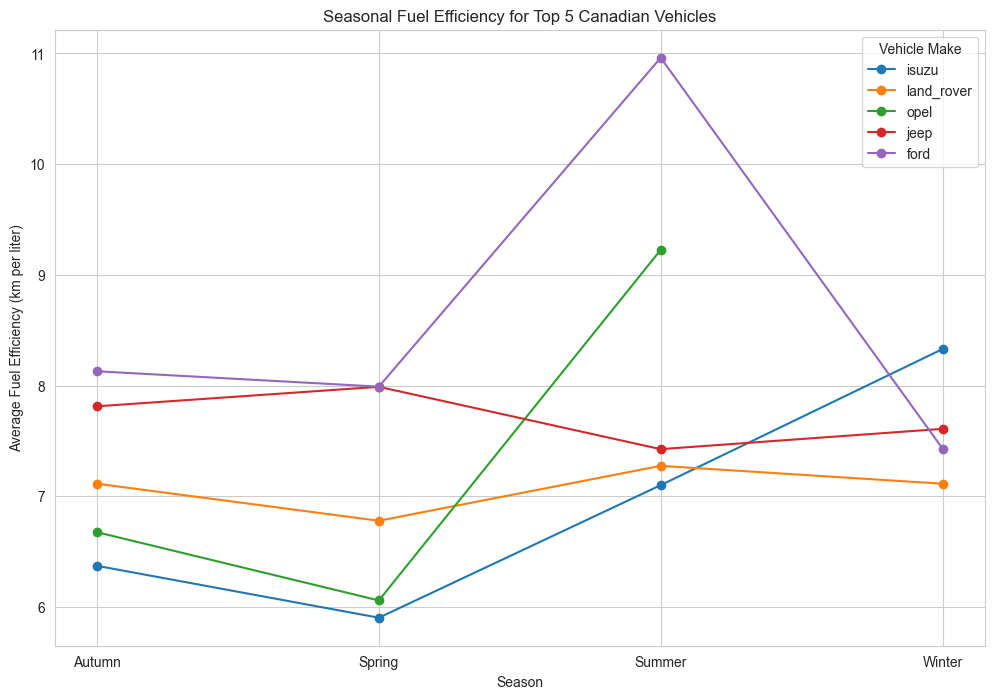

In [43]:
df_canada = df_top_5_curr_cleaned[df_top_5_curr_cleaned['currency'] == 'CA$'].copy()
df_canada = df_canada[(df_canada['km_driven'] != 0) & (df_canada['litres_filled'] != 0)]
df_canada['fuel_efficiency'] = df_canada['km_driven'] / df_canada['litres_filled']

df_canada['month'] = (df_canada['date_fueled']).dt.month
#Canadian seasons - winter is December
df_canada['season'] = df_canada['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] 
                                               else 'Spring' if x in [3, 4, 5]
                                               else 'Summer' if x in [6, 7, 8]
                                               else 'Autumn')

seasonal_efficiency = df_canada.groupby(['make', 'season'])['fuel_efficiency'].mean().reset_index()
overall_efficiency = df_canada.groupby('make')['fuel_efficiency'].mean().reset_index()
top_5_makes = overall_efficiency.nsmallest(5, 'fuel_efficiency')['make']
seasonal_efficiency_top_5 = seasonal_efficiency[seasonal_efficiency['make'].isin(top_5_makes)]

plt.figure(figsize=(12, 8))
for make in top_5_makes:
    make_data = seasonal_efficiency_top_5[seasonal_efficiency_top_5['make'] == make]
    plt.plot(make_data['season'], make_data['fuel_efficiency'], marker='o', label=make)
plt.title('Seasonal Fuel Efficiency for Top 5 Canadian Vehicles')
plt.xlabel('Season')
plt.ylabel('Average Fuel Efficiency (km per liter)')
plt.legend(title='Vehicle Make')
plt.grid(True)
plt.show()

[4.2] 8. Show the correlations between fuel efficiency and other features. You should find that there is a relative strongly correlation with distance travelled, the age of the vehicle, and the model of vehicle. 

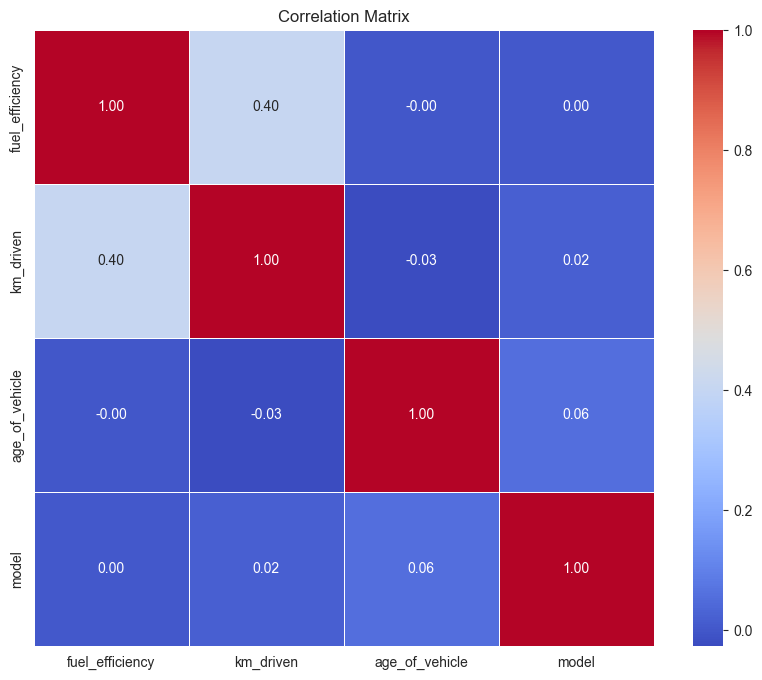

In [44]:
'''

This cell reuses and edits df_cleaned 

'''


df_top_5_curr_cleaned = df_top_5_curr_cleaned.copy()

df_top_5_curr_cleaned['year'] = pd.to_datetime(df_top_5_curr_cleaned['year'], format='%Y', errors='coerce')
df_top_5_curr_cleaned = df_top_5_curr_cleaned.dropna(subset=['year'])
df_top_5_curr_cleaned['year'] = df_top_5_curr_cleaned['year'].dt.year

current_year = datetime.now().year
df_top_5_curr_cleaned['age_of_vehicle'] = current_year - df_top_5_curr_cleaned['year']
df_top_5_curr_cleaned['fuel_efficiency'] = df_top_5_curr_cleaned['km_driven'] / df_top_5_curr_cleaned['litres_filled']
df_top_5_curr_cleaned['model'] = pd.factorize(df_top_5_curr_cleaned['model'])[0]


correlation_matrix = df_top_5_curr_cleaned[['fuel_efficiency', 'km_driven', 'age_of_vehicle', 'model']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


[4.2] 9. Use a random forest to get a list of the most important variables. How different are they from each other, and how do these relate to the variables from the correlations above?

#### Question 4.3 Fuel Usage in SA

##### [4.3.1]  Filter into SA drivers only

In [45]:
# I am using my unique_users_df for this question as it contains all the previous stuff from df_copy 
# but just isolates the unique users in order to focus on SA driver


#unique_users_df = updated_df.drop_duplicates(subset ='user_url')

'''
I am going to use df_cleaned for question 4.3.

df_cleaned has only the top 5 currencies and has outliers for those currencies removed. 

The outliers were removed for the columns that were specified in cell with tag "currency_outlier_removal"

As seen here: 
    # Currencies and corresponding columns to analyze
    currency_columns_mapping = {
        '$': ['total_spent_float', 'gallons', 'cost_per_gallon_float'],
        'CA$': ['total_spent_float', 'gallons', 'cost_per_gallon_float'],
        '£': ['total_spent_float', 'litres_filled', 'cost_per_litre'],
        '€': ['total_spent_float', 'litres_filled', 'cost_per_litre'],
        'R': ['total_spent_float', 'litres_filled', 'cost_per_litre']
    }


It must be noted that this df_cleaned does not account for unique users.


I will copy df_cleaned and filter the new dataframe in order to get only the unique drivers for south africa.


'''


south_african_drivers_df = df_top_5_curr_cleaned.copy()
south_african_drivers_df = south_african_drivers_df.drop_duplicates(subset ='user_url')
south_african_drivers_df = south_african_drivers_df.query("currency == 'R'")

#df.query("cost_per_gallon == 'R4,200.22'")

##### [4.3.2] Fuel Usage in SA

date_fueled date_captured   odometer  gallons cost_per_gallon  \
822494  2022-04-05    2022-04-05  78429.000   10.567          R73.85   
822495  2013-06-06    2013-06-08        NaN   17.937          R47.05   
822496  2019-01-23    2019-02-01 169070.000   22.011          R54.59   
822497  2018-08-12    2019-08-04  41111.000    6.763          R60.19   
822498  2016-06-16    2016-06-16   2430.000   18.011          R48.45   
...            ...           ...        ...      ...             ...   
854110  2013-01-03    2013-01-06 141203.000   14.009          R44.82   
854169  2021-03-02    2021-03-02        NaN   15.399          R59.32   
854195  2015-09-24    2015-09-24  98620.000    5.753          R45.96   
854600  2021-05-14    2021-05-19  69997.000   20.922          R52.47   
854662  2011-12-10    2011-12-11  77801.000   13.758          R39.22   

       total_spent    mpg   miles  \
822494     R780.40  0.000   0.000   
822495     R843.99 23.300 418.400   
822496   R1,201.47  0.000   0.000   
822497     R407.04 40.700 275.254   
822498     R872.69 15.500 279.171   
...            ...    ...     ...   
854110     R627.87 12.300 172.311   
854169     R913.40 12.800 197.400   
854195     R264.38 27.300 157.057   
854600   R1,097.71 19.000 397.518   
854662     R539.55 23.400 321.937   

                                                 user_url  is_valid_date  ...  \
822494  https://www.somewebsite.com/ford/transit_conne...           True  ...   
822495  https://www.somewebsite.com/land_rover/discove...           True  ...   
822496  https://www.somewebsite.com/nissan/patrol/1999...           True  ...   
822497  https://www.somewebsite.com/ford/ecosport/2013...           True  ...   
822498  https://www.somewebsite.com/land_rover/discove...           True  ...   
...                                                   ...            ...  ...   
854110  https://www.somewebsite.com/nissan/patrol/2004...           True  ...   
854169  https://www.somewebsite.com/nissan/350z/2007/7...           True  ...   
854195   https://www.somewebsite.com/bmw/320i/1998/365146           True  ...   
854600  https://www.somewebsite.com/toyota/prado/2015/...           True  ...   
854662     https://www.somewebsite.com/audi/s3/2007/98486           True  ...   

        year  user_id currency_type  litres_filled km_driven  \
822494  2015  1103772         Other         40.000     0.000   
822495  1996   123580         Other         67.899   673.348   
822496  1999   254197         Other         83.321     0.000   
822497  2013   942891         Other         25.601   442.977   
822498  2016   426622         Other         68.179   449.280   
...      ...      ...           ...            ...       ...   
854110  2004   141746         Other         53.030   277.307   
854169  2007    71258         Other         58.292   317.684   
854195  1998   365146         Other         21.777   252.758   
854600  2015   989952         Other         79.198   639.742   
854662  2007    98486         Other         52.080   518.106   

        litres_per_100km  cost_per_litre cost_per_litre_zar age_of_vehicle  \
822494               NaN          19.509             19.509              9   
822495            10.084          12.429             12.429             28   
822496               NaN          14.421             14.421             25   
822497             5.779          15.901             15.901             11   
822498            15.175          12.799             12.799              8   
...                  ...             ...                ...            ...   
854110            19.123          11.840             11.840             20   
854169            18.349          15.671             15.671             17   
854195             8.616          12.141             12.141             26   
854600            12.380          13.861             13.861              9   
854662            10.052          10.361             10.361             17   

        fuel_effic

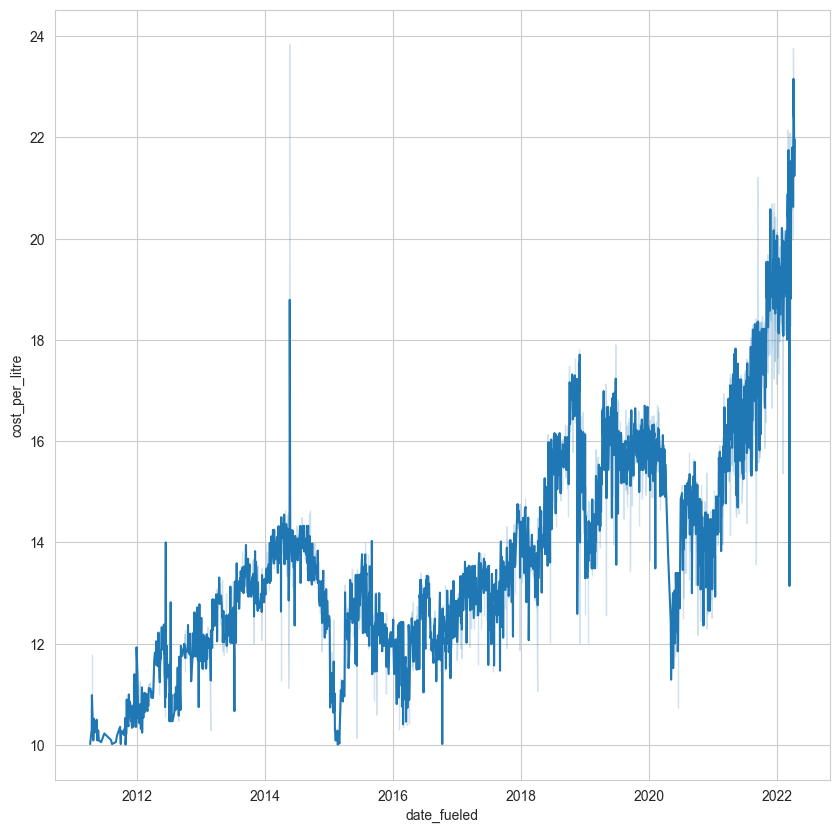

In [46]:
plt.figure(figsize=(10,10))
sns.lineplot(data = south_african_drivers_df, x = "date_fueled", y= "cost_per_litre")
#plt.plot(south_african_drivers_df["date_fueled"],south_african_drivers_df["cost_per_gallon"])
south_african_drivers_df

##### [4.3.3] Num people, Tuesday vs Other days

<BarContainer object of 2 artists>

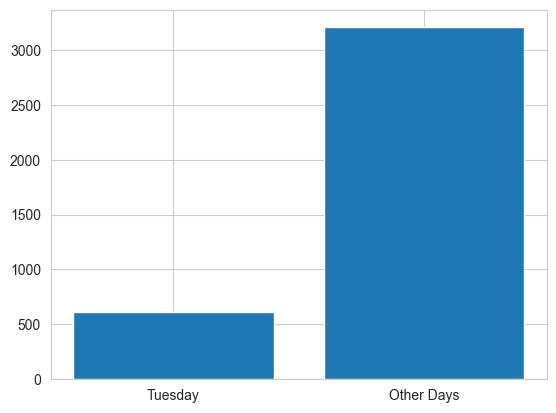

In [47]:
# weekday = 1 is Tuesday
tuesday_df = south_african_drivers_df[south_african_drivers_df["date_fueled"].dt.weekday == 1]
tuesday_df["user_url"].count()

other_days_df = south_african_drivers_df[south_african_drivers_df["date_fueled"].dt.weekday != 1]
other_days_df["user_url"].count()

days = ["Tuesday", "Other Days"]
num_refueling_per_day = [tuesday_df["user_url"].count(), other_days_df["user_url"].count()]

plt.bar(days,num_refueling_per_day)

##### [4.3.4] Now reduce your dataset to only the entries on the 1st Tuesday and 1st Wednesday in SA every month.

In [48]:
wed_df = south_african_drivers_df[south_african_drivers_df["date_fueled"].dt.weekday == 2]
tues_wed_df = pd.concat([wed_df,tuesday_df])
first_tues_wed_df = tues_wed_df[tues_wed_df["date_fueled"].dt.day < 7]
first_tues_wed_df = first_tues_wed_df[first_tues_wed_df["cost_per_litre"]!=0.0]
sorted_first_tues_wed_df = first_tues_wed_df.sort_values("date_fueled", ignore_index=True)
sorted_first_tues_wed_df

date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
0    2011-10-05    2011-10-05   9403.000   18.794          R38.84     R729.92   
1    2011-11-01    2011-11-01 152242.000    9.029          R38.76     R349.99   
2    2011-11-01    2011-11-02  97918.000   13.790          R38.76     R534.54   
3    2011-11-02    2011-11-09  25341.000    9.867          R40.12     R395.91   
4    2011-11-02    2011-11-02 144978.000    2.576          R38.84     R100.05   
..          ...           ...        ...      ...             ...         ...   
271  2022-04-05    2022-04-05  78429.000   10.567          R73.85     R780.40   
272  2022-04-05    2022-04-05        NaN   17.007          R81.76   R1,390.61   
273  2022-04-05    2022-04-08  59325.000   13.520          R73.17     R989.31   
274  2022-04-05    2022-04-05 136412.000    5.071          R78.89     R400.00   
275  2022-04-06    2022-04-06    706.000   10.239          R81.05     R829.85   

       mpg   miles                                           user_url  \
0   20.600 387.156  https://www.somewebsite.com/nissan/np300/2011/...   
1    0.000   0.000  https://www.somewebsite.com/nissan/sentra/1995...   
2   11.500 158.585    https://www.somewebsite.com/bmw/318i/2001/83609   
3   27.500 271.343  https://www.somewebsite.com/suzuki/jimny/2010/...   
4    0.000   0.000    https://www.somewebsite.com/bmw/318i/1994/95779   
..     ...     ...                                                ...   
271  0.000   0.000  https://www.somewebsite.com/ford/transit_conne...   
272 14.200 242.000  https://www.somewebsite.com/toyota/hilux/2006/...   
273 23.500 317.720  https://www.somewebsite.com/isuzu/d-max/2016/1...   
274  0.000   0.000  https://www.somewebsite.com/mitsubishi/triton/...   
275 29.500 302.050  https://www.somewebsite.com/toyota/corolla/202...   

     is_valid_date  ...  year  user_id currency_type  litres_filled km_driven  \
0             True  ...  2011    76782         Other         71.143   623.066   
1             True  ...  1995    95886         Other         34.178     0.000   
2             True  ...  2001    83609         Other         52.201   255.217   
3             True  ...  2010    64386         Other         37.351   436.682   
4             True  ...  1994    95779         Other          9.751     0.000   
..             ...  ...   ...      ...           ...            ...       ...   
271           True  ...  2015  1103772         Other         40.000     0.000   
272           True  ...  2006   411959         Other         64.378   389.460   
273           True  ...  2016  1124531         Other         51.179   511.320   
274           True  ...  2007  1021137         Other         19.196     0.000   
275           True  ...  2022  1129179         Other         38.759   486.102   

     litres_per_100km  cost_per_litre cost_per_litre_zar age_of_vehicle  \
0              11.418          10.260             10.260             13   
1                 NaN          10.239             10.239             29   
2              20.453          10.239             10.239             23   
3               8.553          10.599             10.599             14   
4                 NaN          10.260             10.260             30   
..                ...             ...                ...            ...   
271               NaN          19.509             19.509              9   
272            16.530          21.599             21.599             18   
273            10.009          19.329             19.329              8   
274               NaN          20.841             20.841             17   
275             7.973          21.411             21.411              2   

     fuel_efficiency  
0              8.758  
1              0.000  
2              4.889  
3             11.691  
4              0.000  
..               ...  
271            0.000  
272            6.050  
273            9.991  
274            0.000  
275           12.542  

[27

##### [4.3.5] add an indicator for whether the price goes up or the price goes down that month

In [49]:


price_change_indicator_df = sorted_first_tues_wed_df.copy()
price_change_indicator_df['price_change_indicator'] = ""


for i in range(len(price_change_indicator_df)):
    if i == 0:
        continue
    else:
        prev_index = i-1
        if price_change_indicator_df.loc[i,'cost_per_litre'] < price_change_indicator_df.loc[prev_index,'cost_per_litre']:
            price_change_indicator_df.loc[i,'price_change_indicator'] = "down"
        elif price_change_indicator_df.loc[i,"cost_per_litre"] > price_change_indicator_df.loc[i-1,"cost_per_litre"]:
            price_change_indicator_df.loc[i,"price_change_indicator"] = "up"
        else:
            price_change_indicator_df.loc[i,"price_change_indicator"] = "no change"
display(price_change_indicator_df)

date_fueled date_captured   odometer  gallons cost_per_gallon total_spent  \
0    2011-10-05    2011-10-05   9403.000   18.794          R38.84     R729.92   
1    2011-11-01    2011-11-01 152242.000    9.029          R38.76     R349.99   
2    2011-11-01    2011-11-02  97918.000   13.790          R38.76     R534.54   
3    2011-11-02    2011-11-09  25341.000    9.867          R40.12     R395.91   
4    2011-11-02    2011-11-02 144978.000    2.576          R38.84     R100.05   
..          ...           ...        ...      ...             ...         ...   
271  2022-04-05    2022-04-05  78429.000   10.567          R73.85     R780.40   
272  2022-04-05    2022-04-05        NaN   17.007          R81.76   R1,390.61   
273  2022-04-05    2022-04-08  59325.000   13.520          R73.17     R989.31   
274  2022-04-05    2022-04-05 136412.000    5.071          R78.89     R400.00   
275  2022-04-06    2022-04-06    706.000   10.239          R81.05     R829.85   

       mpg   miles                                           user_url  \
0   20.600 387.156  https://www.somewebsite.com/nissan/np300/2011/...   
1    0.000   0.000  https://www.somewebsite.com/nissan/sentra/1995...   
2   11.500 158.585    https://www.somewebsite.com/bmw/318i/2001/83609   
3   27.500 271.343  https://www.somewebsite.com/suzuki/jimny/2010/...   
4    0.000   0.000    https://www.somewebsite.com/bmw/318i/1994/95779   
..     ...     ...                                                ...   
271  0.000   0.000  https://www.somewebsite.com/ford/transit_conne...   
272 14.200 242.000  https://www.somewebsite.com/toyota/hilux/2006/...   
273 23.500 317.720  https://www.somewebsite.com/isuzu/d-max/2016/1...   
274  0.000   0.000  https://www.somewebsite.com/mitsubishi/triton/...   
275 29.500 302.050  https://www.somewebsite.com/toyota/corolla/202...   

     is_valid_date  ...  user_id  currency_type litres_filled  km_driven  \
0             True  ...    76782          Other        71.143    623.066   
1             True  ...    95886          Other        34.178      0.000   
2             True  ...    83609          Other        52.201    255.217   
3             True  ...    64386          Other        37.351    436.682   
4             True  ...    95779          Other         9.751      0.000   
..             ...  ...      ...            ...           ...        ...   
271           True  ...  1103772          Other        40.000      0.000   
272           True  ...   411959          Other        64.378    389.460   
273           True  ...  1124531          Other        51.179    511.320   
274           True  ...  1021137          Other        19.196      0.000   
275           True  ...  1129179          Other        38.759    486.102   

    litres_per_100km  cost_per_litre  cost_per_litre_zar age_of_vehicle  \
0             11.418          10.260              10.260             13   
1                NaN          10.239              10.239             29   
2             20.453          10.239              10.239             23   
3              8.553          10.599              10.599             14   
4                NaN          10.260              10.260             30   
..               ...             ...                 ...            ...   
271              NaN          19.509              19.509              9   
272           16.530          21.599              21.599             18   
273           10.009          19.329              19.329              8   
274              NaN          20.841              20.841             17   
275            7.973          21.411              21.411              2   

    fuel_efficiency  price_change_indicator  
0             8.758                          
1             0.000                    down  
2             4.889               no change  
3            11.691                      up  
4             0.000                    down  
..              ...                     ...  
271           0.00

##### [4.3.6] and [4.3.7] 
Do more people refuel on the first Wednesday of the month when the prices goes down?
 
Do more people refuel on the first Tuesday of the month when the prices
goes up?

<BarContainer object of 4 artists>

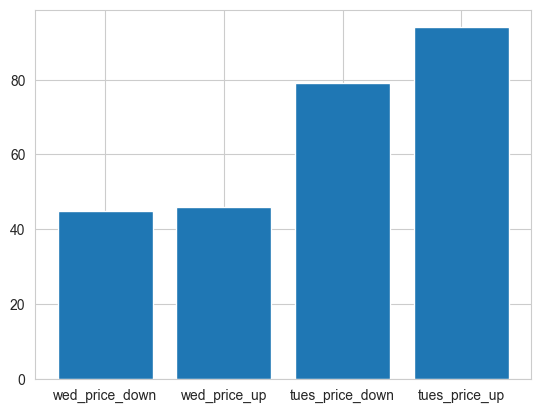

In [50]:
num_wed_price_down = len(price_change_indicator_df.query('date_fueled.dt.weekday == 2 & price_change_indicator == "down"'))
num_wed_price_up = len(price_change_indicator_df.query('date_fueled.dt.weekday == 2 & price_change_indicator == "up"'))

num_tues_price_down = len(price_change_indicator_df.query('date_fueled.dt.weekday == 1 & price_change_indicator == "down"'))
num_tues_price_up = len(price_change_indicator_df.query('date_fueled.dt.weekday == 1 & price_change_indicator == "up"'))

labels = ["wed_price_down", "wed_price_up", "tues_price_down", "tues_price_up"]
values = [num_wed_price_down,num_wed_price_up,num_tues_price_down,num_tues_price_up]
plt.bar(labels,values)
